In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
import random
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from sklearn.model_selection import KFold

#then import my own modules
# from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight
from timeit import default_timer as timer
from AttentiveFP.featurizing import graph_dict
from AttentiveFP.AttentiveLayers_new2 import Fingerprint, graph_dataset, null_collate, Graph, Logger, time_to_str



In [2]:
cuda_aviable = torch.cuda.is_available()
device = torch.device(0)

SEED = 28
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic=True


In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set_style("darkgrid")
from IPython.display import SVG, display
import sascorer
import itertools
from sklearn.metrics import r2_score
import scipy

number of all smiles:  133885
number of successfully processed smiles:  133247


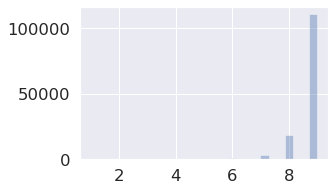

In [4]:
task_name = 'qm9'
tasks = [
   "mu","alpha","homo","lumo","gap","r2","zpve","u0","u298","h298","g298","cv"
]

raw_filename = "../data/gdb9_smiles.csv"
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)

smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ", len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
#         print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)].reset_index()
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()


In [5]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 500
epochs = 300

p_dropout= 0.5
fingerprint_dim = 280

weight_decay = 4.9 # also known as l2_regularization_lambda
learning_rate = 3.4
K = 2
T = 2
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num


In [6]:
test_df = smiles_tasks_df.sample(frac=1/10, random_state=SEED) # test set
training_data = smiles_tasks_df.drop(test_df.index) # training data

# get the stats of the seen dataset (the training data)
# which will be used to noramlize the dataset. 
columns = ['Task','Mean','Standard deviation', 'Mean absolute deviation','ratio']
mean_list=[]
std_list=[]
mad_list=[]
ratio_list=[]
training_label_list = []
test_label_list = []
for task in tasks:
    mean = training_data[task].mean()
    mean_list.append(mean)
    std = training_data[task].std()
    std_list.append(std)
    mad = training_data[task].mad()
    mad_list.append(mad)
    ratio_list.append(std/mad)
    training_data[task+'_normalized'] = (training_data[task]- mean)/std
    # the mean and standard deviation of training data is also used in test set
    test_df[task+'_normalized'] = (test_df[task]- mean)/std
    training_label_list.append(training_data[task+'_normalized'].values)
    test_label_list.append(test_df[task+'_normalized'].values)

training_label = np.array(training_label_list).astype(np.float).transpose()
test_label = np.array(test_label_list).astype(np.float).transpose()

    
# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=SEED) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

while (len(train_df) % batch_size) / batch_size <0.8:
    batch_size +=1
print("batch size: ", batch_size)

list_of_tuples = list(zip(tasks, mean_list, std_list, mad_list, ratio_list))
stats  = pd.DataFrame(list_of_tuples, columns = columns)
stats


batch size:  503


,Task,Mean,Standard deviation,Mean absolute deviation,ratio
0,mu,2.708713,1.531956,1.191056,1.286217
1,alpha,75.190920,8.197607,6.308065,1.299544
2,homo,-0.239974,0.022176,0.016340,1.357178
3,lumo,0.011026,0.046912,0.038618,1.214779
4,gap,0.250999,0.047505,0.039648,1.198148
5,r2,1190.034973,279.648930,202.109506,1.383651
6,zpve,0.148522,0.033298,0.026472,1.257836
7,u0,-411.587569,40.087880,31.106651,1.288724
8,u298,-411.579095,40.087661,31.106518,1.288722
9,h298,-411.578151,40.087661,31.106518,1.288722


In [7]:
# # check the value distribution of different tasks
# plt.figure(figsize=(28, 8),dpi=300)
# gs = gridspec.GridSpec(2, 6)
# sns.set(font_scale=1.8)
# for i, task in enumerate(tasks):
#     plt.subplot(gs[(i)])
#     x = pd.Series(training_data[task].values, name=task)
#     ax = sns.distplot(x, bins=28, kde=False)
#     plt.tight_layout()
# plt.show()
# plt.close()

In [8]:
# # check the distribution after normalization (should be the same)

# plt.figure(figsize=(28, 8),dpi=300)
# gs = gridspec.GridSpec(2, 6)
# sns.set(font_scale=1.8)
# for i, task in enumerate(tasks):
#     plt.subplot(gs[(i)])
#     x = pd.Series(training_data[task+"_normalized"].values, name=task)
#     ax = sns.distplot(x, bins=28, kde=False)
#     plt.tight_layout()
# plt.show()
# plt.close()

In [9]:
training_smiles = training_data['smiles'].values
test_smiles = test_df['smiles'].values
training_graph_dict = graph_dict(training_smiles, list(training_label), filename+'_training_seed'+str(SEED))
test_graph_dict = graph_dict(test_smiles, list(test_label), filename+'_test_seed'+str(SEED))
whole_graph_dict = {**training_graph_dict, **test_graph_dict}

graph dicts loaded from ../data/gdb9_smiles_training_seed28.pkl
graph dicts loaded from ../data/gdb9_smiles_test_seed28.pkl


In [10]:
ratio_array = torch.from_numpy(np.array(ratio_list).astype(np.float)).float()
ratio_array = ratio_array.to(device)
std_array = torch.from_numpy(np.array(std_list).astype(np.float)).float()
std_array = ratio_array.to(device)

ratio_array_square = ratio_array[None,:]**2
loss_function = nn.MSELoss()
model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
model.to(device)
# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in  model.parameters()])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

2936777
preprocess.0.linear.weight torch.Size([280, 39])
preprocess.0.linear.bias torch.Size([280])
preprocess.0.bn.weight torch.Size([280])
preprocess.0.bn.bias torch.Size([280])
encoder.0.linear.weight torch.Size([280, 49])
encoder.0.linear.bias torch.Size([280])
encoder.0.bn.weight torch.Size([280])
encoder.0.bn.bias torch.Size([280])
align.weight torch.Size([1, 560])
align.bias torch.Size([1])
attend.linear.weight torch.Size([280, 280])
attend.linear.bias torch.Size([280])
attend.bn.weight torch.Size([280])
attend.bn.bias torch.Size([280])
gru.weight_ih torch.Size([840, 280])
gru.weight_hh torch.Size([840, 280])
gru.bias_ih torch.Size([840])
gru.bias_hh torch.Size([840])
propagate.0.align.weight torch.Size([1, 560])
propagate.0.align.bias torch.Size([1])
propagate.0.attend.linear.weight torch.Size([280, 280])
propagate.0.attend.linear.bias torch.Size([280])
propagate.0.attend.bn.weight torch.Size([280])
propagate.0.attend.bn.bias torch.Size([280])
propagate.0.gru.weight_ih torch.Si

In [11]:
# def train(model, smiles_list):
#     model.train()
#     train_loader = DataLoader(graph_dataset(smiles_list, whole_graph_dict), batch_size, collate_fn=null_collate, \
#                               num_workers=1, pin_memory=True, shuffle=True, worker_init_fn=np.random.seed(SEED))
#     losses = []
#     for b, (smiles, atom, bond, bond_index, mol_index, label) in tqdm(enumerate(train_loader)):
#         atom = atom.to(device)
#         bond = bond.to(device)
#         bond_index = bond_index.to(device)
#         mol_index = mol_index.to(device)
#         label = label.to(device)
        
#         mol_prediction = model(atom, bond, bond_index, mol_index)
        
#         loss = 0.0
#         for i,task in enumerate(tasks):
#             y_pred = mol_prediction[:, i]
#             loss += loss_function(y_pred, label[:,i])*ratio_list[i]**2
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#         losses.append(loss.item())

#     return np.mean(losses)

        
# def eval(model, smiles_list):
#     model.eval()
#     eval_MAE_list = {}
#     eval_MSE_list = {}
#     y_val_list = {}
#     y_pred_list = {}
#     for i,task in enumerate(tasks):
#         y_pred_list[task] = np.array([])
#         y_val_list[task] = np.array([])
#         eval_MAE_list[task] = np.array([])
#         eval_MSE_list[task] = np.array([])
        
#     eval_loader = DataLoader(graph_dataset(smiles_list, whole_graph_dict), batch_size, collate_fn=null_collate, \
#                               num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
#     for b, (smiles, atom, bond, bond_index, mol_index, label) in tqdm(enumerate(eval_loader)):
#         atom = atom.to(device)
#         bond = bond.to(device)
#         bond_index = bond_index.to(device)
#         mol_index = mol_index.to(device)
#         label = label.to(device)
        
#         mol_prediction = model(atom, bond, bond_index, mol_index)
#         for i,task in enumerate(tasks):
#             y_pred = mol_prediction[:, i]

#             MAE = F.l1_loss(y_pred, label[:,i], reduction='none')        
#             MSE = F.mse_loss(y_pred, label[:,i], reduction='none')
        
#             y_pred_list[task] = np.concatenate([y_pred_list[task], y_pred.cpu().detach().numpy()])
#             y_val_list[task] = np.concatenate([y_val_list[task], label[:,i].cpu().detach().numpy()])
#             eval_MAE_list[task] = np.concatenate([eval_MAE_list[task],MAE.data.squeeze().cpu().numpy()])
#             eval_MSE_list[task] = np.concatenate([eval_MSE_list[task],MSE.data.squeeze().cpu().numpy()])
# #     r2_score_list = [r2_score(y_val_list[task], y_pred_list[task]) for task in tasks]
#     eval_MAE_normalized = np.array([eval_MAE_list[task].mean() for i, task in enumerate(tasks)])
#     eval_MAE = np.multiply(eval_MAE_normalized, np.array(std_list))
#     eval_RMSE_normalized = np.sqrt(np.array([eval_MSE_list[task].mean() for i, task in enumerate(tasks)]))
#     eval_RMSE = np.multiply(eval_RMSE_normalized, np.array(std_list))

#     return eval_MAE_normalized, eval_MAE, eval_RMSE_normalized, eval_RMSE #, r2_score_list



In [12]:
def train(model, smiles_list):
    model.train()
    train_loader = DataLoader(graph_dataset(smiles_list, whole_graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=True, worker_init_fn=np.random.seed(SEED))
    losses = []
    for b, (smiles, atom, bond, bond_index, mol_index, label) in tqdm(enumerate(train_loader)):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device) * ratio_array_square # set STD/MAD ratio as the weights
        mol_prediction = model(atom, bond, bond_index, mol_index) * ratio_array_square
        
        loss = loss_function(mol_prediction.reshape(-1), label.reshape(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    return np.mean(losses)

def eval(model, smiles_list):
    model.eval()
    MAE_array = np.array([])
    MSE_array = np.array([])
    mol_prediction_array = np.array([])
    label_array = np.array([])
        
    eval_loader = DataLoader(graph_dataset(smiles_list, whole_graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
    for b, (smiles, atom, bond, bond_index, mol_index, label) in tqdm(enumerate(eval_loader)):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        MAE = F.l1_loss(mol_prediction.reshape(-1), label.reshape(-1), reduction='none').cpu().detach().numpy()      
        MSE = F.mse_loss(mol_prediction.reshape(-1), label.reshape(-1), reduction='none').cpu().detach().numpy()
        
#         mol_prediction_array = np.concatenate([mol_prediction_array, mol_prediction.cpu().detach().numpy()])
        label = label.reshape(-1,12).cpu().detach().numpy()
        label_array = np.concatenate([label_array.reshape(-1,12),label])
#         print(label_array.shape)
        MAE_array = np.concatenate([MAE_array.reshape(-1,12),MAE.reshape(-1,12)])
        MSE_array = np.concatenate([MSE_array.reshape(-1,12),MSE.reshape(-1,12)])
#     mol_prediction_array = mol_prediction_array.data.squeeze().cpu().numpy()
#     label_array = label_array.data.squeeze().cpu().numpy()    
#     r2_score_list = [r2_score(mol_prediction_array[:,i], label_array[:,i]) for i, task in enumerate(tasks)]
    MAE_normalized = MAE_array.mean(0).reshape(-1)    
    MAE_raw = MAE_normalized * np.array(std_list)
    RMSE_normalized = np.sqrt(MAE_array.mean().reshape(-1))
    RMSE_raw = RMSE_normalized * np.array(std_list)

    return MAE_normalized, MAE_raw, RMSE_normalized, RMSE_raw #, r2_score_list




# def eval(model, smiles_list):
#     model.eval()
#     MAE_array = torch.Tensor()
#     RMSE_array = torch.Tensor()
#     mol_prediction_array = torch.Tensor()
#     label_array = torch.Tensor()
        
#     eval_loader = DataLoader(graph_dataset(smiles_list, whole_graph_dict), batch_size, collate_fn=null_collate, \
#                               num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
#     for b, (smiles, atom, bond, bond_index, mol_index, label) in tqdm(enumerate(eval_loader)):
#         atom = atom.to(device)
#         bond = bond.to(device)
#         bond_index = bond_index.to(device)
#         mol_index = mol_index.to(device)
#         label = label.to(device)
        
#         mol_prediction = model(atom, bond, bond_index, mol_index)
#         MAE = F.l1_loss(mol_prediction.reshape(-1), label.reshape(-1), reduction='none')        
#         MSE = F.mse_loss(mol_prediction.reshape(-1), label.reshape(-1), reduction='none')
        
#         mol_prediction_array = torch.cat([mol_prediction_array.reshape(-1,12), mol_prediction.reshape(-1,12)],0)
        
#         label_array = torch.cat([label_array.reshape(-1,12),label.reshape(-1,12)])
#         MAE_array = torch.cat([MAE.reshape(-1,12),MAE.reshape(-1,12)])
#         MSE_array = torch.cat([MSE.reshape(-1,12),MSE.reshape(-1,12)])
# #     mol_prediction_array = mol_prediction_array.data.squeeze().cpu().numpy()
# #     label_array = label_array.data.squeeze().cpu().numpy()    
# #     r2_score_list = [r2_score(mol_prediction_array[:,i], label_array[:,i]) for i, task in enumerate(tasks)]
#     MAE_normalized = MAE_array.mean(0).reshape(-1)    
#     MAE_raw = MAE_normalized * std_array
#     RMSE_normalized = torch.sqrt(MAE_array.mean().reshape(-1))
#     RMSE_raw = RMSE_normalized * std_array

#     return MAE_normalized, MAE_raw, RMSE_normalized, RMSE_raw #, r2_score_list



In [13]:
# log = Logger()
# log.open(f'{prefix_filename}_{start_time}.txt')

# f = '{:^5} | {:^7.4f} | {:^7.4f} | {:^7.4f} | {:^7} \n'
# log.write('epoch | loss | train MSE |  valid MSE |  time \n')
# start = timer()

# best_param ={}
# best_param["train_epoch"] = 0
# best_param["valid_epoch"] = 0
# best_param["train_MSE"] = 9e8
# best_param["valid_MSE"] = 9e8

# fold_index = 3
# for epoch in range(800):
#     losses = train(smiles_list[train_fold[fold_index]])
#     traine_MAE, train_MSE = eval(smiles_list[train_fold[fold_index]])
#     valid_MAE, valid_MSE = eval(smiles_list[valid_fold[fold_index]])

#     timing = time_to_str((timer() - start), 'min')  
#     log.write(f.format(epoch, losses, train_MSE, valid_MSE, timing))

#     if train_MSE < best_param["train_MSE"]:
#         best_param["train_epoch"] = epoch
#         best_param["train_MSE"] = train_MSE
#     if valid_MSE < best_param["valid_MSE"]:
#         best_param["valid_epoch"] = epoch
#         best_param["valid_MSE"] = valid_MSE
# #         if valid_MSE < 0.35:
# #              torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
#     if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
#         break
# print(best_param["valid_epoch"],best_param["train_MSE"],best_param["valid_MSE"])

In [14]:
# bug_list1 = ['C[NH2+]C1C[C@H](C(N)=O)O1', 'C[C@@H](O)[C@H]1CCC([NH-])O1', '[NH-]c1nc(N)c(O)[cH+]o1', 'O=CN1[C@H]2[C@H]3[C@@H]4[C@H]3[C@H]2[C@@H]41', 'C[NH2+]C1O[CH+]N=C[CH+]1C', 'C[C@H]1O[C@@H](CO)C1NO', 'CCO[C@H]1[C@@H](C)C1(C)C', 'COCc1c[nH]c(O)n1', 'O=CCCc1ccon1', 'C#CC1=C[C@@H]2[C@@H]3[C@H]1O[C@@H]32', 'CC1=C[C@H](C#N)COC1', 'C1CC12[C@H]1[C@@H]3[C@H]1[C@H]1[C@@H]3[N@H+]12', 'CCC[C@H]1C[C@@](C)(O)C1', 'C[C@H]1C[C@@]12C[C@@H](O)C2=O', 'O[C@H]1CC=C2CCO[C@H]21', 'CC(C)(O)CCCO', 'CC[C@]12C[N@H+]1C[C@@]21CN1', 'C#C[C@H]1C[C@H](COC)C1', '[NH-]c1nc(O)nc(N)[nH+]1', 'C[C@H]1C[C@]2(CN2)[C@@]12CN2', 'C[C@@]1(O)C[C@H]2OC[C@@H]1O2', 'C[C@@]12O[C@H]3[C@@H]4C[N@@H+]([C@@H]41)[C@H]32', 'C1=C[C@]2(CC1)[C@@]13C[C@]12O3', 'C[C@H]1[C@@H](O)C(=O)C1(C)C', 'C[N@H+]1[C@H]2[C@H]3C[C@H]3[C@@H]1[C@H]2O', 'O=C1C[C@H]2COC(=O)N12', 'CC[C@H]1CC2=CCO[C@H]21', 'O=C1CC[C@H]2C[C@@H](C1)O2', 'CCn1cnc(NC)c1', 'C#CC#C[C@H](O)CCC', 'Nc1[nH]c(O)cc1O', 'O=C1COCC=C[C@@H]1O', 'O=C1O[C@H]2CO[C@@H]1OC2', 'OCC[N@H+]1[C@H]2[C@H]3C[C@H]3[C@H]21', 'O=c1[nH]ncnc1F', '[NH-]c1[nH+]cc(N)[nH]c1=O', 'C[C@H]1O[C@]12C=CCC2', '[NH-]c1[nH+]c(O)cnc1O', 'O=C[C@H]1[C@@H]2C=C[C@H]1[C@H]2O', 'C[C@H]1CC12CC1(CC1)C2', 'N#CC1(N)CC1', 'C#C[C@@](C)(C=O)C(N)=O', 'C[C@H]1OC[C@H]2N[C@H]2[C@H]1O', 'Cc1c[nH+]c([NH-])nc1F', 'O=C1C[C@@H]2NC(=O)[C@@H]2C1', 'C[C@H]1C[C@H]([C@@]2(C)CO2)O1', 'c1cnc([C@H]2CN2)cn1', 'CC[C@@H]1[C@H](C)C=C[C@@H]1C', 'C[C@]12C[C@H]1[C@H]1C=CC[C@H]12', 'C[C@]12C[C@H]1C[C@H]2CCO']

# bug_list2 = ['NC(=O)[C@H]1O[C@H]1C=O', 'CC(=O)c1n[nH]cc1O', 'Cc1c[nH]c(O)c1C=O', 'OC[C@@H](O)[C@H]1CCCO1', 'CCC1=CCCNC1=O', 'CNc1cnc(O)[nH]1', 'C[C@H]1C[N@H+]2[C@@H]3[C@H](O)[C@H]2[C@@H]31', 'C[N+]1=CNNC([NH-])C1=O', 'CNC(=N)CCC(=O)O', '[NH-]c1nn[nH+]c(N)c1F', 'C[NH2+]C1OCC12CC2', 'CC(C)(O)[C@H]1CCCO1', 'CC1(C)N[C@@]12COC2=O', '[NH-]c1n[cH+]occ1N', 'C#Cc1[nH]ccc1N', 'N#C[C@H]1CCC[C@H]2O[C@@H]12', 'COC[C@@H](C)[C@H]1C[C@H]1C', 'C[C@@H]1[C@@H]2C[C@H]1[C@@]2(C)CO', 'CC(C)C(=O)C[C@@H](C)O', 'Nc1oncc1NC=O', 'C[C@H]1C[C@]2(C)[C@H]1[C@@H]1N[C@@H]12', 'C[C@@H]1C=C[C@]2(CC1)CO2', 'NCC[C@@H](O)CC(=O)O', '[NH-]C1OC[C@@H]2[C@H]1[C@@H]2C=O', 'CC1(C)[C@H]2O[CH+][NH2+][C@]21C', 'CO[C@@H]1C([NH-])OC[C@@H]1O', 'C#C[C@H](C=O)CCCC', 'Cc1ccnc(C)c1', 'C[C@H]1C[N@H+](CC(N)=O)C1', 'O=CO[CH+][NH2+]C[C@H]1CO1', 'C#CC(=O)N[C@H](C)C=O', 'C#C[C@]1(CC#CC)CN1', 'C[C@@H](O)CC(=O)C1CC1', 'CC[N@@H+]1[C@H](C#N)[C@@H]2C[C@@H]21', 'C[C@]12C(=O)O[C@]13C[C@H]2C3', 'CCCCOC(=O)CN', 'CCC#C[C@@]1(C=O)CN1', 'c1nc2ocnc2[nH]1', 'N#C[C@@]1(O)C[C@@H]1N', 'O=C1CNC2(COC2)C1', 'CC[C@H]1C[C@@]2(C)O[C@@]12C', 'CC[C@@]12C[C@@H](O1)[C@H]1O[C@H]12', 'CCc1cc([NH-])nn[nH+]1', 'C#C[C@H](C)[C@@H](C)C#N', 'CCn1cnc(NC)n1', 'C1CC1[NH+]1CC1', 'CC(=O)[C@H]1COC(N)[NH2+]1', 'C#CC1(C#C)C[C@H]2C[C@H]21', 'O=C[C@@]1(O)[C@@H]2O[C@H]3[C@@H]2[C@H]31', 'C1[C@H]2C[C@]3(C[C@H]4O[C@H]43)[C@@H]12']

# bug_list3 = ['c1cc2n[nH+]ccc2[nH]1', 'COCC[C@@H]1C=CCO1', 'C#C[C@@H]1C[C@@H]1CCO', 'C[C@@]12CC[C@@H](O)[C@]1(C)N2', 'C[C@@]1(O)CC(=O)[C@@]12CN2', 'Nc1cc(N2CC2)c[nH]1', '[NH-]C1CN=CN1C(N)=O', 'CNC[C@@]1(C#N)CN1', 'Cn1ccc(O)c1C#N', 'C[C@]12C([NH-])O[C@@H]3[C@]14O[C@@]324', 'O=C[C@@H]1[C@@H]2OCC[C@@]21O', 'CC1=C[C@H]2C[C@@]13OC[C@@H]23', 'Cc1n[nH+]c(O)nc1[NH-]', 'CCOC[C@H]1[C@H]2CC[C@H]21', 'CN/C=N/c1nc[nH]n1', 'CC(C)[C@H]1[C@@H](O)[C@]1(C)O', 'C[C@@]12[C@H]3[NH2+]C[C@@H]1[C@@H]2CO3', 'C[C@]12CC[C@H](CC1)O2', 'CCc1c(C)c[nH]c1C', 'C[C@@]12C[C@H]3[C@H]4[C@@H]1[C@@H]2C[N@@H+]34', 'C[C@H]1O[C@]23CO[C@H](C2)[C@@H]13', 'CCCOCCC1CC1', 'O=C1CN=CO[C@H]2C[C@@H]12', 'O=C1CCCOCCO1', 'C#C[C@]12C[C@@H]3C(=O)N1[C@@H]32', 'C[C@@]12C[C@H]3[N@@H+]1[C@@]3(C)[C@@H]2O', 'NC1=CC(=O)OC12CC2', 'C#CC[C@H](CC)[NH+]1CC1', 'C[C@H]1O[C@@]1(C=O)CC=O', 'O[C@H]1C[C@]12[C@H]1[C@@H]3C[C@H]1[C@@H]32', 'O[C@@H]1C=C[C@@H]2C[N@@H+]2CC1', 'C[C@@]12CC[C@H]3[C@H](O)[C@@H]1[C@H]32', 'CC(=O)OCC[C@@H](C)O', 'C#CC[C@]12CC[C@H]1CC2', 'C1C[C@@]23C[C@@H](O1)O[C@@H]2C3', 'c1cc2[nH]nnc2cn1', 'C[C@H]1CC2(CC2)O[C@H]1C', 'O=CN1[C@H]2[C@@H]3[C@H](O)[C@H]2[C@@H]31', 'CC(=O)CC12CC(C1)C2', 'C1=C[C@H]2[C@@H]3CC[C@H]2O[C@H]13', 'OCC[C@]12C[C@H]1[NH2+][CH+]O2', 'C[C@]12C[C@@H]3C[C@H](C1)[N@@H+]32', 'O=C1CN[C@@H]1CCCO', 'CC#C[C@]12C[N@H+](C1)[C@H]2C', 'CC[C@H]1O[C@H]2[C@@H]1C2(C)C', 'C[C@@H]1O[C@@H]2[C@H](O1)C2(C)C', 'C[C@H]1OC([NH-])[C@H]2C[C@H]21', 'N#C[C@@H]1C[C@@H]1NCC=O', 'C[C@@H](C=O)[C@@](C)(O)CO', 'CC[C@@H](C)n1nnnn1']

In [15]:
# losses = train(model, bug_list1)
# print(losses)

In [16]:
# train_df_smiles = train_df.smiles.values
# valid_df_smiles = valid_df.smiles.values
# test_df_smiles = test_df.smiles.values


In [17]:
# losses = train(model, train_df_smiles)
# print(losses)

In [18]:
# valid_MAE_normalized, valid_MAE, valid_RMSE_normalized, valid_RMSE, = eval(model, train_df_smiles)
# print(valid_MAE_normalized[0])

In [19]:
best_param ={}
best_param["train_epoch"] = 0
best_param["valid_epoch"] = 0
best_param["train_MSE_normalized"] = 800
best_param["valid_MSE_normalized"] = 800
train_df_smiles = train_df.smiles.values
valid_df_smiles = valid_df.smiles.values

for epoch in range(300):
    losses = train(model, train_df_smiles)
    train_MAE_normalized, train_MAE, train_MSE_normalized, train_MSE = eval(model, train_df_smiles)
    valid_MAE_normalized, valid_MAE, valid_MSE_normalized, valid_MSE, = eval(model, valid_df_smiles)
    print("EPOCH:\t"+str(epoch)+' '+str(losses)+'\n'\
#         +"train_MAE_normalized: "+str(train_MAE_normalized)+'\n'\
#         +"valid_MAE_normalized: "+str(valid_MAE_normalized)+'\n'\
        +"train_MAE"+":"+"\n"+str(train_MAE)+'\n'\
        +"valid_MAE"+":"+"\n"+str(valid_MAE)+'\n'\
          
        +"train_MSE_normalized_mean: "+str(train_MSE_normalized.mean())+'\n'\
        +"valid_MSE_normalized_mean: "+str(valid_MSE_normalized.mean())+'\n'\
#         +"train_MSE_normalized: "+str(train_MSE_normalized)+'\n'\
#         +"valid_MSE_normalized: "+str(valid_MSE_normalized)+'\n'\
        )
    if train_MSE_normalized.mean() < best_param["train_MSE_normalized"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE_normalized"] = train_MSE_normalized.mean()
    if valid_MSE_normalized.mean() < best_param["valid_MSE_normalized"]:
        best_param["valid_epoch"] = epoch
        best_param["valid_MSE_normalized"] = valid_MSE_normalized.mean()
        if valid_MSE_normalized.mean() < 0.06:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
#     if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
#         break
    


212it [00:11, 18.39it/s]
212it [00:03, 56.92it/s]
27it [00:00, 22.85it/s]

EPOCH:	0 0.5740779288253695
train_MAE:
[7.77888796e-01 1.14027528e+00 8.44184007e-03 1.01856115e-02
 1.21782593e-02 5.74871384e+01 3.48591111e-03 4.54217872e+00
 5.54008819e+00 4.26285029e+00 5.80071849e+00 4.93852391e-01]
valid_MAE:
[7.68128926e-01 1.13944382e+00 8.38328189e-03 1.02928773e-02
 1.22671102e-02 5.78508050e+01 3.51492180e-03 4.56599132e+00
 5.56029147e+00 4.30224858e+00 5.81786282e+00 4.97472993e-01]
train_MSE_normalized_mean: 0.4504947372575872
valid_MSE_normalized_mean: 0.45055162079298827




212it [00:11, 18.03it/s]
212it [00:03, 58.72it/s]
27it [00:00, 44.65it/s]

EPOCH:	1 0.32628662420331306
train_MAE:
[7.32197697e-01 9.83179687e-01 7.79810032e-03 8.66525248e-03
 1.14514456e-02 5.22573820e+01 3.34286200e-03 4.55097321e+00
 4.25403818e+00 3.83478871e+00 4.30827326e+00 4.57838822e-01]
valid_MAE:
[7.26350997e-01 9.88104336e-01 7.80963640e-03 8.67380108e-03
 1.14901989e-02 5.23027378e+01 3.36325032e-03 4.58623095e+00
 4.28973133e+00 3.87535364e+00 4.34088162e+00 4.60374269e-01]
train_MSE_normalized_mean: 0.4279790286213865
valid_MSE_normalized_mean: 0.4282997994018137




212it [00:11, 19.74it/s]
212it [00:03, 59.37it/s]
27it [00:00, 44.39it/s]

EPOCH:	2 0.28225721812473153
train_MAE:
[7.00331897e-01 1.00616654e+00 6.94802327e-03 9.20508275e-03
 1.16239464e-02 4.96638284e+01 4.44442619e-03 4.76025024e+00
 4.54424029e+00 4.65454996e+00 4.44407376e+00 4.98212883e-01]
valid_MAE:
[6.94232935e-01 1.01355399e+00 6.94966399e-03 9.18503142e-03
 1.16513049e-02 5.00355435e+01 4.47036056e-03 4.72814866e+00
 4.50911079e+00 4.62494096e+00 4.41273367e+00 4.99342450e-01]
train_MSE_normalized_mean: 0.43077839618973407
valid_MSE_normalized_mean: 0.43042337222352145




212it [00:12, 17.28it/s]
212it [00:04, 50.92it/s]
27it [00:00, 43.98it/s]

EPOCH:	3 0.2637870994941244
train_MAE:
[7.07083811e-01 1.57440666e+00 6.63020146e-03 1.08148215e-02
 1.25563632e-02 5.23247991e+01 5.32832489e-03 1.67352069e+00
 1.62622593e+00 1.65325503e+00 1.64627184e+00 6.92958930e-01]
valid_MAE:
[7.02404628e-01 1.57315939e+00 6.64761834e-03 1.07583218e-02
 1.25761887e-02 5.27072064e+01 5.34474131e-03 1.66522236e+00
 1.61668853e+00 1.64361247e+00 1.63831045e+00 6.92162489e-01]
train_MSE_normalized_mean: 0.4212785068048909
valid_MSE_normalized_mean: 0.4210383225564459




212it [00:11, 19.18it/s]
212it [00:03, 56.87it/s]
27it [00:00, 47.38it/s]

EPOCH:	4 0.2508453461077978
train_MAE:
[6.67304792e-01 1.07946299e+00 6.57721035e-03 8.34935217e-03
 1.05275655e-02 4.52333289e+01 2.53931302e-03 2.52112105e+00
 2.54461901e+00 2.49543734e+00 2.42625758e+00 4.39799788e-01]
valid_MAE:
[6.61231592e-01 1.08079798e+00 6.59000968e-03 8.36231871e-03
 1.06123047e-02 4.57083208e+01 2.54176897e-03 2.53026952e+00
 2.55490136e+00 2.51011679e+00 2.43946526e+00 4.40577727e-01]
train_MSE_normalized_mean: 0.3935754073404417
valid_MSE_normalized_mean: 0.39378496333856144




212it [00:11, 18.34it/s]
212it [00:03, 56.96it/s]
27it [00:00, 43.05it/s]

EPOCH:	5 0.24451538175344467
train_MAE:
[6.70228412e-01 7.85307305e-01 6.46150130e-03 8.13496630e-03
 9.74395094e-03 4.74073455e+01 2.51061087e-03 1.68076387e+00
 1.66585092e+00 1.68210486e+00 1.70119838e+00 4.14125366e-01]
valid_MAE:
[6.66848758e-01 7.89011809e-01 6.46350262e-03 8.13559974e-03
 9.79627419e-03 4.77749330e+01 2.52497165e-03 1.68603374e+00
 1.67126073e+00 1.68478132e+00 1.70382284e+00 4.13888728e-01]
train_MSE_normalized_mean: 0.3783623121453594
valid_MSE_normalized_mean: 0.3785315498705597




212it [00:11, 18.21it/s]
212it [00:03, 60.61it/s]
27it [00:00, 39.01it/s]

EPOCH:	6 0.2350080133468475
train_MAE:
[6.63245130e-01 8.54107655e-01 6.17309101e-03 7.53980558e-03
 9.68837629e-03 4.42784457e+01 2.47423400e-03 3.19911639e+00
 3.20680216e+00 3.18810561e+00 3.16645229e+00 5.64677571e-01]
valid_MAE:
[6.56890367e-01 8.58055876e-01 6.22610037e-03 7.49360671e-03
 9.74437569e-03 4.43979763e+01 2.47163840e-03 3.20548605e+00
 3.21253373e+00 3.19608297e+00 3.17424624e+00 5.67027345e-01]
train_MSE_normalized_mean: 0.39476427338701664
valid_MSE_normalized_mean: 0.3948213550413304




212it [00:12, 18.35it/s]
212it [00:03, 53.20it/s]
27it [00:00, 35.16it/s]

EPOCH:	7 0.22723634562121248
train_MAE:
[6.72344081e-01 7.77408363e-01 5.98300710e-03 7.55710038e-03
 9.14640026e-03 4.53887424e+01 1.97395606e-03 2.92294362e+00
 2.89052306e+00 2.88019636e+00 2.87729222e+00 3.81796683e-01]
valid_MAE:
[6.70271468e-01 7.77532318e-01 6.01937903e-03 7.58030984e-03
 9.21035228e-03 4.55548768e+01 1.98856525e-03 2.91821760e+00
 2.88586308e+00 2.87686382e+00 2.87405540e+00 3.83170897e-01]
train_MSE_normalized_mean: 0.3831133969622099
valid_MSE_normalized_mean: 0.3834521673247717




212it [00:11, 18.20it/s]
212it [00:03, 55.77it/s]
27it [00:00, 42.75it/s]

EPOCH:	8 0.22108170207379
train_MAE:
[6.26050592e-01 6.98408153e-01 5.90634779e-03 6.81540916e-03
 8.79505976e-03 4.13049687e+01 2.24304503e-03 1.23603602e+00
 1.24050834e+00 1.25697407e+00 1.24903127e+00 4.08364310e-01]
valid_MAE:
[6.27430441e-01 6.99871589e-01 5.98467499e-03 6.81534966e-03
 8.86207247e-03 4.16741065e+01 2.27137809e-03 1.23654631e+00
 1.24092289e+00 1.25703778e+00 1.24917790e+00 4.09931856e-01]
train_MSE_normalized_mean: 0.3571248873719948
valid_MSE_normalized_mean: 0.35812751838159623




212it [00:11, 19.57it/s]
212it [00:03, 56.30it/s]
27it [00:00, 44.86it/s]

EPOCH:	9 0.21555655379340333
train_MAE:
[6.08515490e-01 7.63213739e-01 6.02427759e-03 7.99016830e-03
 8.89977539e-03 4.21557550e+01 1.89793987e-03 2.25572465e+00
 2.26262624e+00 2.24417316e+00 2.24606423e+00 3.94503000e-01]
valid_MAE:
[6.11935877e-01 7.69473289e-01 6.11818641e-03 8.03225110e-03
 8.98528818e-03 4.25636701e+01 1.92805012e-03 2.28382200e+00
 2.29079207e+00 2.27241956e+00 2.27426266e+00 3.94628505e-01]
train_MSE_normalized_mean: 0.3707176740256683
valid_MSE_normalized_mean: 0.37241470993501874




212it [00:11, 21.13it/s]
212it [00:04, 51.96it/s]
27it [00:00, 39.29it/s]

EPOCH:	10 0.2106892025836234
train_MAE:
[5.98965128e-01 9.67245693e-01 6.15965983e-03 7.20947348e-03
 8.29415531e-03 4.50673711e+01 3.03733102e-03 2.35947831e+00
 2.35485421e+00 2.33717345e+00 2.34056005e+00 5.22490817e-01]
valid_MAE:
[6.00330018e-01 9.68281298e-01 6.18019313e-03 7.15204508e-03
 8.33183599e-03 4.53848150e+01 3.04828736e-03 2.34098225e+00
 2.33648023e+00 2.32045891e+00 2.32379053e+00 5.22870488e-01]
train_MSE_normalized_mean: 0.37971891172998307
valid_MSE_normalized_mean: 0.37986316216612803




212it [00:11, 17.96it/s]
212it [00:03, 54.23it/s]
27it [00:00, 45.47it/s]

EPOCH:	11 0.20740449667539237
train_MAE:
[5.96406399e-01 9.40898853e-01 5.54966411e-03 6.99694127e-03
 8.46571951e-03 4.54509969e+01 2.41865160e-03 3.42747007e+00
 3.41976070e+00 3.38806753e+00 3.39003497e+00 5.38305067e-01]
valid_MAE:
[5.98254765e-01 9.41607231e-01 5.59115230e-03 6.97397691e-03
 8.59189653e-03 4.57546840e+01 2.43747867e-03 3.43944954e+00
 3.43169742e+00 3.40094207e+00 3.40277323e+00 5.42114345e-01]
train_MSE_normalized_mean: 0.3861357566976271
valid_MSE_normalized_mean: 0.38712233848333555




212it [00:11, 18.45it/s]
212it [00:03, 61.17it/s]
27it [00:00, 44.78it/s]

EPOCH:	12 0.20283180608783127
train_MAE:
[5.98819984e-01 6.44877456e-01 5.58856289e-03 6.25963299e-03
 8.10689300e-03 3.86445196e+01 2.92159065e-03 1.99248222e+00
 1.99830718e+00 2.02081217e+00 2.01698550e+00 3.69331566e-01]
valid_MAE:
[6.04188645e-01 6.52512280e-01 5.68880072e-03 6.26340136e-03
 8.21800587e-03 3.91262179e+01 2.94244827e-03 1.99454055e+00
 2.00012850e+00 2.02138972e+00 2.01779096e+00 3.71557122e-01]
train_MSE_normalized_mean: 0.3585542267874137
valid_MSE_normalized_mean: 0.36022407594975653




212it [00:11, 20.08it/s]
212it [00:03, 56.29it/s]
27it [00:00, 52.12it/s]

EPOCH:	13 0.198845764868102
train_MAE:
[5.99778992e-01 7.22806329e-01 5.85375865e-03 6.02165561e-03
 8.39440810e-03 3.74022423e+01 1.95745953e-03 1.28374305e+00
 1.28752715e+00 1.29780563e+00 1.29675386e+00 3.41284362e-01]
valid_MAE:
[6.02226031e-01 7.20771600e-01 5.95062777e-03 5.98487094e-03
 8.48989574e-03 3.79180715e+01 1.96807648e-03 1.29357406e+00
 1.29735687e+00 1.30760642e+00 1.30657234e+00 3.44335861e-01]
train_MSE_normalized_mean: 0.34810122593299414
valid_MSE_normalized_mean: 0.34939601721146024




212it [00:11, 18.66it/s]
212it [00:04, 48.33it/s]
27it [00:00, 38.71it/s]

EPOCH:	14 0.1959075982559402
train_MAE:
[5.82695883e-01 7.53042952e-01 5.29172326e-03 6.71546468e-03
 8.05811559e-03 3.78689590e+01 2.18097965e-03 3.05040087e+00
 3.04755192e+00 3.02841230e+00 3.03181429e+00 3.53970556e-01]
valid_MAE:
[5.85776603e-01 7.57326487e-01 5.40609916e-03 6.72105806e-03
 8.15619970e-03 3.85077683e+01 2.20438379e-03 3.05069766e+00
 3.04798541e+00 3.02993420e+00 3.03322216e+00 3.55836235e-01]
train_MSE_normalized_mean: 0.36684759127466426
valid_MSE_normalized_mean: 0.36836785589178656




212it [00:12, 17.65it/s]
212it [00:03, 67.02it/s]
27it [00:00, 47.46it/s]

EPOCH:	15 0.19291303011606326
train_MAE:
[5.86249886e-01 6.40479465e-01 5.23926015e-03 6.57552409e-03
 8.19979037e-03 3.94981285e+01 1.99301664e-03 2.14848576e+00
 2.14650770e+00 2.13634670e+00 2.13640361e+00 3.84141607e-01]
valid_MAE:
[5.90655815e-01 6.52939768e-01 5.35450785e-03 6.54976800e-03
 8.33210462e-03 4.02062394e+01 2.00805813e-03 2.14626509e+00
 2.14436734e+00 2.13487164e+00 2.13484442e+00 3.87256948e-01]
train_MSE_normalized_mean: 0.3558076191396499
valid_MSE_normalized_mean: 0.3576059175965604




212it [00:11, 19.94it/s]
212it [00:03, 59.40it/s]
27it [00:00, 44.36it/s]

EPOCH:	16 0.19107093296523364
train_MAE:
[5.73731690e-01 6.61169340e-01 5.35167501e-03 6.15744743e-03
 7.78347049e-03 4.23457321e+01 1.92598174e-03 1.06696979e+00
 1.06646791e+00 1.06476689e+00 1.06465293e+00 3.05064095e-01]
valid_MAE:
[5.75738654e-01 6.67199310e-01 5.47157799e-03 6.15112424e-03
 7.91681022e-03 4.31938092e+01 1.93045431e-03 1.07106067e+00
 1.07047079e+00 1.06800154e+00 1.06791914e+00 3.06925745e-01]
train_MSE_normalized_mean: 0.33939409124984626
valid_MSE_normalized_mean: 0.34112240001798483




212it [00:11, 18.39it/s]
212it [00:03, 58.21it/s]
27it [00:00, 47.22it/s]

EPOCH:	17 0.18791623968841895
train_MAE:
[5.56369948e-01 6.70824995e-01 5.34255772e-03 5.73491758e-03
 7.63539932e-03 3.89531525e+01 1.69603509e-03 1.68610290e+00
 1.68751577e+00 1.69533647e+00 1.69481289e+00 3.54946037e-01]
valid_MAE:
[5.62962209e-01 6.78934153e-01 5.46321246e-03 5.75434529e-03
 7.77429298e-03 3.96342253e+01 1.70307086e-03 1.69399259e+00
 1.69536410e+00 1.70330003e+00 1.70277892e+00 3.60188615e-01]
train_MSE_normalized_mean: 0.34341329800077947
valid_MSE_normalized_mean: 0.3456865256024009




212it [00:11, 19.08it/s]
212it [00:04, 48.48it/s]
27it [00:00, 40.41it/s]

EPOCH:	18 0.18505991215132317
train_MAE:
[5.52565923e-01 8.28179621e-01 5.09191628e-03 5.98851113e-03
 7.47671273e-03 3.88215940e+01 2.38415920e-03 1.64332855e+00
 1.64261403e+00 1.63285283e+00 1.63422290e+00 4.04522862e-01]
valid_MAE:
[5.61131598e-01 8.30852502e-01 5.24993791e-03 6.03181594e-03
 7.58926215e-03 3.96304999e+01 2.40180358e-03 1.64260061e+00
 1.64195785e+00 1.63277775e+00 1.63407213e+00 4.05320981e-01]
train_MSE_normalized_mean: 0.3475874547248848
valid_MSE_normalized_mean: 0.3499665057961832




212it [00:12, 17.25it/s]
212it [00:05, 44.83it/s]
27it [00:00, 31.81it/s]

EPOCH:	19 0.18392945516784237
train_MAE:
[5.49077793e-01 6.92776245e-01 4.89720113e-03 5.90911448e-03
 7.62685263e-03 3.47319553e+01 1.86969024e-03 3.17093594e+00
 3.17324709e+00 3.18280736e+00 3.18226221e+00 3.02436872e-01]
valid_MAE:
[5.57516049e-01 6.96262441e-01 5.03205022e-03 5.92177555e-03
 7.76780039e-03 3.54350095e+01 1.86981691e-03 3.16934024e+00
 3.17160173e+00 3.18071100e+00 3.18021257e+00 3.03964460e-01]
train_MSE_normalized_mean: 0.3561451044396939
valid_MSE_normalized_mean: 0.3582402229156047




212it [00:14, 14.80it/s]
212it [00:03, 58.28it/s]
27it [00:00, 47.53it/s]

EPOCH:	20 0.1804471510058304
train_MAE:
[5.44236902e-01 8.32457846e-01 5.30336794e-03 6.09732811e-03
 7.69192302e-03 3.72705576e+01 2.35880307e-03 1.53868793e+00
 1.53733171e+00 1.53265067e+00 1.53325522e+00 3.69262596e-01]
valid_MAE:
[5.54842413e-01 8.40439050e-01 5.43805665e-03 6.16143016e-03
 7.86986210e-03 3.78623572e+01 2.40534324e-03 1.55353694e+00
 1.55213049e+00 1.54718477e+00 1.54780978e+00 3.73102310e-01]
train_MSE_normalized_mean: 0.3459330011097164
valid_MSE_normalized_mean: 0.3489319221609181




212it [00:11, 17.74it/s]
212it [00:05, 40.25it/s]
27it [00:00, 32.96it/s]

EPOCH:	21 0.17886763403438172
train_MAE:
[5.32947577e-01 9.77957667e-01 4.88519276e-03 5.80208221e-03
 7.56668167e-03 4.00234777e+01 1.67967830e-03 1.24045728e+00
 1.24057622e+00 1.24265223e+00 1.24229747e+00 3.57085715e-01]
valid_MAE:
[5.45361374e-01 9.85178305e-01 5.03604998e-03 5.86173563e-03
 7.72534772e-03 4.05214088e+01 1.67582825e-03 1.26319570e+00
 1.26329804e+00 1.26537640e+00 1.26501811e+00 3.62092190e-01]
train_MSE_normalized_mean: 0.33859350965408
valid_MSE_normalized_mean: 0.34172474681636666




212it [00:15, 15.88it/s]
212it [00:04, 49.54it/s]
27it [00:00, 25.47it/s]

EPOCH:	22 0.17776012582317838
train_MAE:
[5.33634780e-01 6.77764070e-01 4.81840877e-03 5.53579384e-03
 7.09721962e-03 4.27849246e+01 2.28743441e-03 1.43397411e+00
 1.43477193e+00 1.43827754e+00 1.43838201e+00 4.30882395e-01]
valid_MAE:
[5.43935893e-01 6.87334670e-01 4.96450595e-03 5.53785352e-03
 7.20948478e-03 4.40836413e+01 2.29640836e-03 1.45182643e+00
 1.45267029e+00 1.45645574e+00 1.45654402e+00 4.29432916e-01]
train_MSE_normalized_mean: 0.3399428314745767
valid_MSE_normalized_mean: 0.3427797712132838




212it [00:11, 19.79it/s]
212it [00:03, 58.59it/s]
27it [00:00, 44.34it/s]

EPOCH:	23 0.17438177715213793
train_MAE:
[5.35151812e-01 7.53016482e-01 4.81720574e-03 6.07541019e-03
 7.24809362e-03 3.78946404e+01 2.69537769e-03 2.82612112e+00
 2.82491304e+00 2.81821897e+00 2.81864347e+00 4.41954035e-01]
valid_MAE:
[5.52737777e-01 7.61475408e-01 4.95232794e-03 6.15358615e-03
 7.43668018e-03 3.84197209e+01 2.72270689e-03 2.85168116e+00
 2.85045138e+00 2.84359375e+00 2.84402864e+00 4.47894169e-01]
train_MSE_normalized_mean: 0.35908158771628623
valid_MSE_normalized_mean: 0.3626541855548474




212it [00:11, 18.93it/s]
212it [00:03, 56.92it/s]
27it [00:00, 48.09it/s]

EPOCH:	24 0.17343488553503775
train_MAE:
[5.29314632e-01 8.69165390e-01 4.76444745e-03 6.99203696e-03
 7.90152069e-03 3.87367777e+01 2.77282446e-03 3.91144585e+00
 3.91011823e+00 3.89979583e+00 3.90082192e+00 3.87591536e-01]
valid_MAE:
[5.46156615e-01 8.75647044e-01 4.96407285e-03 7.10079264e-03
 8.08634270e-03 3.95040489e+01 2.78815462e-03 3.94637352e+00
 3.94506293e+00 3.93488091e+00 3.93588630e+00 3.94215304e-01]
train_MSE_normalized_mean: 0.3751254304797437
valid_MSE_normalized_mean: 0.3790284814419035




212it [00:11, 17.87it/s]
212it [00:03, 63.80it/s]
27it [00:00, 40.26it/s]

EPOCH:	25 0.17271649985099738
train_MAE:
[5.34161514e-01 6.91331284e-01 4.80290033e-03 5.77885421e-03
 7.13009897e-03 3.55361629e+01 1.84133124e-03 5.79639097e+00
 5.79568731e+00 5.79057929e+00 5.79134184e+00 3.57814310e-01]
valid_MAE:
[5.48313402e-01 7.00351616e-01 4.98421565e-03 5.87396872e-03
 7.35242621e-03 3.61854111e+01 1.85595816e-03 5.79818482e+00
 5.79752013e+00 5.79267304e+00 5.79340842e+00 3.62298044e-01]
train_MSE_normalized_mean: 0.38420570980116675
valid_MSE_normalized_mean: 0.38736812143498905




212it [00:12, 17.43it/s]
212it [00:03, 53.53it/s]
27it [00:00, 39.29it/s]

EPOCH:	26 0.17075504453958207
train_MAE:
[5.24057053e-01 7.50304206e-01 4.68161242e-03 5.81426112e-03
 7.00513105e-03 4.24138492e+01 2.54695432e-03 2.02754364e+00
 2.02692315e+00 2.02471566e+00 2.02545995e+00 5.22281516e-01]
valid_MAE:
[5.40972587e-01 7.56021900e-01 4.83953547e-03 5.88976720e-03
 7.24403374e-03 4.29386478e+01 2.54665270e-03 2.04451150e+00
 2.04392805e+00 2.04195654e+00 2.04266517e+00 5.23905675e-01]
train_MSE_normalized_mean: 0.35059089272766625
valid_MSE_normalized_mean: 0.3540763573029418




212it [00:11, 19.58it/s]
212it [00:03, 56.32it/s]
27it [00:00, 47.22it/s]

EPOCH:	27 0.16732214777818266
train_MAE:
[5.10336515e-01 6.24270851e-01 4.81727253e-03 6.35251142e-03
 7.90972389e-03 3.56796567e+01 2.67888814e-03 1.65958382e+00
 1.65910723e+00 1.65677634e+00 1.65704477e+00 3.39639839e-01]
valid_MAE:
[5.29449018e-01 6.33466772e-01 4.98099009e-03 6.44231466e-03
 8.11786296e-03 3.65667734e+01 2.69803938e-03 1.67497328e+00
 1.67449072e+00 1.67211873e+00 1.67238822e+00 3.43335376e-01]
train_MSE_normalized_mean: 0.33979014918495
valid_MSE_normalized_mean: 0.34386940508484126




212it [00:11, 17.99it/s]
212it [00:03, 60.41it/s]
27it [00:00, 47.30it/s]

EPOCH:	28 0.1681155445721914
train_MAE:
[5.14660203e-01 6.35056555e-01 4.88540659e-03 5.28203657e-03
 7.16614999e-03 3.55910056e+01 2.21657380e-03 4.99915152e+00
 4.99905247e+00 4.99723865e+00 4.99743161e+00 2.89965000e-01]
valid_MAE:
[5.35740959e-01 6.46218044e-01 5.04909489e-03 5.43438909e-03
 7.40932900e-03 3.67345143e+01 2.23192170e-03 5.00088236e+00
 5.00080347e+00 4.99911084e+00 4.99928254e+00 2.93325016e-01]
train_MSE_normalized_mean: 0.372052799178985
valid_MSE_normalized_mean: 0.3761101538964499




212it [00:11, 18.55it/s]
212it [00:04, 49.64it/s]
27it [00:00, 38.20it/s]

EPOCH:	29 0.1653951036761392
train_MAE:
[4.97553478e-01 1.34209841e+00 4.42539639e-03 5.33835843e-03
 6.73458704e-03 4.98264004e+01 4.98235426e-03 2.30892552e+00
 2.30895151e+00 2.31111031e+00 2.31137792e+00 7.22527808e-01]
valid_MAE:
[5.20541379e-01 1.35271058e+00 4.64248721e-03 5.41077838e-03
 6.91618277e-03 5.14423637e+01 4.99066012e-03 2.31432143e+00
 2.31432109e+00 2.31630614e+00 2.31659768e+00 7.24349204e-01]
train_MSE_normalized_mean: 0.37413403174245335
valid_MSE_normalized_mean: 0.37839307179297216




212it [00:11, 19.12it/s]
212it [00:03, 61.76it/s]
27it [00:00, 48.63it/s]


EPOCH:	30 0.16425517236567894
train_MAE:
[5.05433954e-01 7.49704232e-01 4.56280993e-03 5.39318264e-03
 6.78005129e-03 3.52279828e+01 2.06582233e-03 1.67857262e+00
 1.67862190e+00 1.67896524e+00 1.67892384e+00 3.97312736e-01]
valid_MAE:
[5.27783706e-01 7.55680541e-01 4.80011800e-03 5.50630763e-03
 7.05882987e-03 3.62240762e+01 2.08283451e-03 1.68245544e+00
 1.68247135e+00 1.68263880e+00 1.68262261e+00 4.01085548e-01]
train_MSE_normalized_mean: 0.33392971368354973
valid_MSE_normalized_mean: 0.3388443185265505



212it [00:11, 20.32it/s]
212it [00:03, 57.86it/s]
27it [00:00, 45.95it/s]

EPOCH:	31 0.16349730120514924
train_MAE:
[4.93455313e-01 6.52018655e-01 4.43615491e-03 5.08008950e-03
 6.75204462e-03 3.33584977e+01 2.57980853e-03 1.32264063e+00
 1.32283423e+00 1.32412674e+00 1.32400953e+00 3.86447386e-01]
valid_MAE:
[5.17916529e-01 6.63181174e-01 4.64360221e-03 5.21262079e-03
 6.96303138e-03 3.47698510e+01 2.58287946e-03 1.32706222e+00
 1.32723621e+00 1.32840265e+00 1.32829980e+00 3.87037187e-01]
train_MSE_normalized_mean: 0.32609005414260733
valid_MSE_normalized_mean: 0.33111991225570614




212it [00:11, 17.93it/s]
212it [00:03, 56.81it/s]
27it [00:00, 19.07it/s]

EPOCH:	32 0.16045001507648882
train_MAE:
[4.87948172e-01 5.64030423e-01 4.36766844e-03 5.16311226e-03
 6.76007669e-03 3.15742940e+01 1.56653847e-03 1.15516136e+00
 1.15551028e+00 1.15773129e+00 1.15761590e+00 2.67977318e-01]
valid_MAE:
[5.12128779e-01 5.78873663e-01 4.61247560e-03 5.24844437e-03
 7.00692511e-03 3.29443813e+01 1.57644248e-03 1.16661490e+00
 1.16694951e+00 1.16910675e+00 1.16901663e+00 2.71595367e-01]
train_MSE_normalized_mean: 0.3133055097570074
valid_MSE_normalized_mean: 0.31895659322897735




212it [00:11, 18.35it/s]
212it [00:04, 47.77it/s]
27it [00:00, 37.80it/s]

EPOCH:	33 0.160747322412032
train_MAE:
[5.03405809e-01 5.73234886e-01 4.46611477e-03 5.04946124e-03
 6.57722386e-03 3.23437191e+01 2.13051686e-03 1.23040332e+00
 1.23002372e+00 1.22762066e+00 1.22782793e+00 3.09105870e-01]
valid_MAE:
[5.26215554e-01 5.84089818e-01 4.69577605e-03 5.15251721e-03
 6.84653094e-03 3.35654507e+01 2.14001212e-03 1.24255192e+00
 1.24218250e+00 1.23982646e+00 1.24001873e+00 3.10924660e-01]
train_MSE_normalized_mean: 0.3194192731035249
valid_MSE_normalized_mean: 0.3246916598185182




212it [00:12, 19.18it/s]
212it [00:03, 56.27it/s]
27it [00:00, 48.14it/s]

EPOCH:	34 0.1586994320716498
train_MAE:
[4.97977542e-01 7.35706649e-01 4.40788882e-03 5.09629568e-03
 6.40621091e-03 3.31198822e+01 2.18201829e-03 1.12740859e+00
 1.12738307e+00 1.12718312e+00 1.12715319e+00 3.60583356e-01]
valid_MAE:
[5.22740730e-01 7.48516473e-01 4.64636505e-03 5.24161091e-03
 6.71184806e-03 3.43345702e+01 2.18658369e-03 1.14305584e+00
 1.14302202e+00 1.14278808e+00 1.14277093e+00 3.64279795e-01]
train_MSE_normalized_mean: 0.32174463494317496
valid_MSE_normalized_mean: 0.3275155439578174




212it [00:11, 18.88it/s]
212it [00:03, 63.44it/s]
27it [00:00, 47.22it/s]

EPOCH:	35 0.15743297893764838
train_MAE:
[4.86014015e-01 6.77463910e-01 4.61165429e-03 5.35930111e-03
 6.62130896e-03 3.40347676e+01 1.93304036e-03 2.12589944e+00
 2.12571477e+00 2.12492111e+00 2.12509562e+00 3.16838829e-01]
valid_MAE:
[5.15216318e-01 6.89009293e-01 4.85991350e-03 5.49075488e-03
 6.94091890e-03 3.54115118e+01 1.93311035e-03 2.13365535e+00
 2.13346938e+00 2.13266745e+00 2.13283902e+00 3.21709455e-01]
train_MSE_normalized_mean: 0.3330750809331193
valid_MSE_normalized_mean: 0.3390379326983734




212it [00:11, 17.96it/s]
212it [00:03, 60.58it/s]
27it [00:00, 45.76it/s]

EPOCH:	36 0.15746655026977918
train_MAE:
[4.79025007e-01 6.55021926e-01 4.24544225e-03 6.20470338e-03
 7.09130133e-03 3.09551049e+01 2.57030219e-03 4.62406430e+00
 4.62413600e+00 4.62446091e+00 4.62448250e+00 2.83779409e-01]
valid_MAE:
[5.07683255e-01 6.66845947e-01 4.50580576e-03 6.23636854e-03
 7.34374149e-03 3.27110069e+01 2.59022897e-03 4.63195356e+00
 4.63201941e+00 4.63230175e+00 4.63233175e+00 2.87233067e-01]
train_MSE_normalized_mean: 0.36339833494138885
valid_MSE_normalized_mean: 0.36867909894672435




212it [00:11, 17.83it/s]
212it [00:04, 44.34it/s]
27it [00:00, 18.41it/s]

EPOCH:	37 0.1552984208430884
train_MAE:
[4.78565498e-01 6.30930293e-01 4.40207787e-03 5.71739104e-03
 6.68924555e-03 3.76211222e+01 2.12923711e-03 3.77790821e+00
 3.77761644e+00 3.77632958e+00 3.77673203e+00 3.48085894e-01]
valid_MAE:
[5.08554860e-01 6.42541077e-01 4.66591696e-03 5.82694026e-03
 7.00431826e-03 3.86973327e+01 2.12653183e-03 3.78431200e+00
 3.78402517e+00 3.78276508e+00 3.78315792e+00 3.53655398e-01]
train_MSE_normalized_mean: 0.35491306702578035
valid_MSE_normalized_mean: 0.36046207212317155




212it [00:11, 20.02it/s]
212it [00:03, 56.72it/s]
27it [00:00, 45.69it/s]

EPOCH:	38 0.15428478383230712
train_MAE:
[4.87849517e-01 6.05684222e-01 4.20752492e-03 5.12759822e-03
 6.57085400e-03 3.37116750e+01 1.46362691e-03 1.54545004e+00
 1.54549443e+00 1.54593810e+00 1.54595760e+00 2.97298185e-01]
valid_MAE:
[5.19528489e-01 6.14984494e-01 4.49297084e-03 5.24228999e-03
 6.86978961e-03 3.51780184e+01 1.47193897e-03 1.53456577e+00
 1.53459917e+00 1.53496495e+00 1.53498696e+00 3.01673560e-01]
train_MSE_normalized_mean: 0.3190587120675743
valid_MSE_normalized_mean: 0.3253822493291259




212it [00:11, 19.65it/s]
212it [00:03, 57.49it/s]
27it [00:00, 44.25it/s]

EPOCH:	39 0.15399925860593905
train_MAE:
[4.82411352e-01 7.07143966e-01 4.31894433e-03 5.36470824e-03
 6.53881509e-03 3.59474566e+01 1.85247470e-03 1.62427881e+00
 1.62430023e+00 1.62444581e+00 1.62441030e+00 3.19250747e-01]
valid_MAE:
[5.13012401e-01 7.18902872e-01 4.61279530e-03 5.52571169e-03
 6.91196696e-03 3.72155659e+01 1.87670204e-03 1.64009547e+00
 1.64010706e+00 1.64020674e+00 1.64018528e+00 3.22745425e-01]
train_MSE_normalized_mean: 0.32567044718288896
valid_MSE_normalized_mean: 0.3324630378057341




212it [00:11, 17.88it/s]
212it [00:03, 56.54it/s]
27it [00:00, 43.36it/s]

EPOCH:	40 0.1522731805606833
train_MAE:
[4.72915349e-01 6.87299728e-01 4.21993577e-03 5.61963602e-03
 7.03635969e-03 4.05992854e+01 2.81741668e-03 4.21130375e+00
 4.21103817e+00 4.21029501e+00 4.21073238e+00 5.08623236e-01]
valid_MAE:
[5.06313946e-01 6.99434156e-01 4.50332012e-03 5.76303162e-03
 7.39115057e-03 4.17295191e+01 2.83771770e-03 4.23289345e+00
 4.23263065e+00 4.23189752e+00 4.23232429e+00 5.14503144e-01]
train_MSE_normalized_mean: 0.3680863668317397
valid_MSE_normalized_mean: 0.37424248941327615




212it [00:12, 17.39it/s]
212it [00:04, 55.45it/s]
27it [00:00, 46.15it/s]

EPOCH:	41 0.1503383641675958
train_MAE:
[4.64634879e-01 7.86831528e-01 4.65294300e-03 5.32732974e-03
 5.96164570e-03 3.27019752e+01 2.31535844e-03 2.35725542e+00
 2.35719462e+00 2.35663800e+00 2.35662477e+00 3.57430490e-01]
valid_MAE:
[5.00482521e-01 7.94248443e-01 4.94001860e-03 5.49903732e-03
 6.33792666e-03 3.41783906e+01 2.33385476e-03 2.38989033e+00
 2.38982942e+00 2.38927373e+00 2.38925729e+00 3.57562532e-01]
train_MSE_normalized_mean: 0.33637197379075523
valid_MSE_normalized_mean: 0.3434758823332684




212it [00:11, 17.91it/s]
212it [00:03, 53.84it/s]
27it [00:00, 40.71it/s]

EPOCH:	42 0.15041806534776148
train_MAE:
[4.68454994e-01 5.73777210e-01 4.05536203e-03 5.18334898e-03
 6.53653955e-03 3.02748202e+01 2.58052898e-03 1.44042700e+00
 1.44053584e+00 1.44094663e+00 1.44081302e+00 2.93370133e-01]
valid_MAE:
[5.04404354e-01 5.81012807e-01 4.36118254e-03 5.30223442e-03
 6.88526947e-03 3.19296229e+01 2.58949537e-03 1.43322446e+00
 1.43333281e+00 1.43373467e+00 1.43359459e+00 2.98232791e-01]
train_MSE_normalized_mean: 0.3173379363830858
valid_MSE_normalized_mean: 0.3244378494142791




212it [00:11, 19.23it/s]
212it [00:03, 58.44it/s]
27it [00:00, 48.87it/s]

EPOCH:	43 0.14851057824661146
train_MAE:
[4.58818879e-01 5.43022619e-01 3.98828051e-03 6.57018053e-03
 7.51558167e-03 3.15008144e+01 2.80482827e-03 1.56870280e+00
 1.56873545e+00 1.56911746e+00 1.56921165e+00 2.82594499e-01]
valid_MAE:
[4.99025505e-01 5.54819430e-01 4.33220977e-03 6.64007595e-03
 7.81011096e-03 3.33323676e+01 2.82382587e-03 1.58052133e+00
 1.58054990e+00 1.58091165e+00 1.58101365e+00 2.86765830e-01]
train_MSE_normalized_mean: 0.32491183558024284
valid_MSE_normalized_mean: 0.3325432650952621




212it [00:11, 18.12it/s]
212it [00:03, 57.42it/s]
27it [00:00, 41.13it/s]

EPOCH:	44 0.14761590114179649
train_MAE:
[4.47582127e-01 5.91511890e-01 4.13020319e-03 5.31174878e-03
 6.39073010e-03 3.46715265e+01 2.06853081e-03 3.03800647e+00
 3.03786465e+00 3.03724024e+00 3.03744798e+00 3.04768821e-01]
valid_MAE:
[4.91472630e-01 6.08942829e-01 4.44605173e-03 5.47620078e-03
 6.80146273e-03 3.62733493e+01 2.08483758e-03 3.03812307e+00
 3.03798456e+00 3.03736867e+00 3.03756357e+00 3.08987177e-01]
train_MSE_normalized_mean: 0.33696163563387077
valid_MSE_normalized_mean: 0.34483766676301353




212it [00:12, 17.20it/s]
212it [00:04, 51.91it/s]
27it [00:00, 46.11it/s]

EPOCH:	45 0.1467694285202701
train_MAE:
[4.55498343e-01 5.83957955e-01 3.96927089e-03 5.65422926e-03
 6.42072961e-03 3.12684743e+01 1.78455095e-03 1.12622428e+00
 1.12625117e+00 1.12649201e+00 1.12650264e+00 2.78317170e-01]
valid_MAE:
[4.96205096e-01 5.95661050e-01 4.30127461e-03 5.77456138e-03
 6.78038319e-03 3.30249061e+01 1.81378085e-03 1.13627369e+00
 1.13630065e+00 1.13653294e+00 1.13654671e+00 2.81876322e-01]
train_MSE_normalized_mean: 0.30950555132645824
valid_MSE_normalized_mean: 0.31776140192937097




212it [00:11, 18.07it/s]
212it [00:03, 58.68it/s]
27it [00:00, 46.20it/s]

EPOCH:	46 0.1464985310679899
train_MAE:
[4.40807236e-01 5.33781335e-01 4.06452595e-03 5.65560932e-03
 6.40677942e-03 2.95643534e+01 1.78442870e-03 1.11006565e+00
 1.11007910e+00 1.11032566e+00 1.11036090e+00 3.40026751e-01]
valid_MAE:
[4.87260608e-01 5.47041671e-01 4.42970080e-03 5.84150504e-03
 6.78655800e-03 3.12974886e+01 1.79940385e-03 1.12225951e+00
 1.12227512e+00 1.12252522e+00 1.12255462e+00 3.42113005e-01]
train_MSE_normalized_mean: 0.30893893292006375
valid_MSE_normalized_mean: 0.3180751336968493




212it [00:11, 19.56it/s]
212it [00:03, 56.93it/s]
27it [00:00, 46.43it/s]

EPOCH:	47 0.14572464277581224
train_MAE:
[4.54436434e-01 5.92981899e-01 4.04112861e-03 5.12168216e-03
 6.04615024e-03 3.36699225e+01 2.06137360e-03 1.02387681e+00
 1.02385177e+00 1.02381649e+00 1.02385288e+00 3.31548406e-01]
valid_MAE:
[5.01694182e-01 6.07449468e-01 4.42364408e-03 5.29216532e-03
 6.44163409e-03 3.53577427e+01 2.08872555e-03 1.02598280e+00
 1.02595348e+00 1.02590929e+00 1.02595344e+00 3.37088954e-01]
train_MSE_normalized_mean: 0.31006783185314696
valid_MSE_normalized_mean: 0.3193686053947126




212it [00:11, 18.32it/s]
212it [00:03, 54.99it/s]
27it [00:00, 36.26it/s]

EPOCH:	48 0.14493169020509944
train_MAE:
[4.40063627e-01 5.33303115e-01 3.99010743e-03 4.54878891e-03
 5.77685730e-03 3.05259866e+01 1.36775111e-03 1.49155085e+00
 1.49158880e+00 1.49172353e+00 1.49168343e+00 3.06079408e-01]
valid_MAE:
[4.88486250e-01 5.50134194e-01 4.35650021e-03 4.73318331e-03
 6.20096998e-03 3.24009592e+01 1.40746608e-03 1.50466609e+00
 1.50470212e+00 1.50482292e+00 1.50478931e+00 3.10636313e-01]
train_MSE_normalized_mean: 0.30621301314572086
valid_MSE_normalized_mean: 0.3160387141307496




212it [00:12, 19.61it/s]
212it [00:04, 49.45it/s]
27it [00:00, 42.44it/s]

EPOCH:	49 0.14369469642076851
train_MAE:
[4.55340965e-01 5.45928125e-01 4.11636244e-03 5.09533967e-03
 6.20792438e-03 2.96077831e+01 2.10136815e-03 1.62437100e+00
 1.62430316e+00 1.62415153e+00 1.62426561e+00 3.45591081e-01]
valid_MAE:
[5.04040852e-01 5.61786889e-01 4.50905009e-03 5.28453033e-03
 6.63848777e-03 3.12645856e+01 2.13334562e-03 1.64590292e+00
 1.64583379e+00 1.64567921e+00 1.64579285e+00 3.51605747e-01]
train_MSE_normalized_mean: 0.31686393111942013
valid_MSE_normalized_mean: 0.326582592152658




212it [00:12, 17.60it/s]
212it [00:03, 53.24it/s]
27it [00:00, 47.20it/s]

EPOCH:	50 0.14345654219670115
train_MAE:
[4.33569338e-01 6.62482596e-01 3.90616375e-03 4.50260381e-03
 5.75547693e-03 3.16677438e+01 2.06572240e-03 1.04200530e+00
 1.04202346e+00 1.04190618e+00 1.04182129e+00 3.71863039e-01]
valid_MAE:
[4.85436285e-01 6.74045148e-01 4.30489095e-03 4.70666120e-03
 6.18634980e-03 3.35390793e+01 2.08479722e-03 1.05549368e+00
 1.05551047e+00 1.05539285e+00 1.05531038e+00 3.72678593e-01]
train_MSE_normalized_mean: 0.3065746224101476
valid_MSE_normalized_mean: 0.31666678512580726




212it [00:11, 18.22it/s]
212it [00:03, 58.95it/s]
27it [00:00, 24.43it/s]

EPOCH:	51 0.14277878477466557
train_MAE:
[4.29662659e-01 5.43997887e-01 3.90654018e-03 4.68431196e-03
 5.86594793e-03 2.95493820e+01 1.71096913e-03 2.65269076e+00
 2.65267206e+00 2.65250293e+00 2.65249103e+00 2.78085588e-01]
valid_MAE:
[4.83383745e-01 5.60739472e-01 4.29815314e-03 4.91721934e-03
 6.33166843e-03 3.14964835e+01 1.72099082e-03 2.67492431e+00
 2.67490609e+00 2.67474255e+00 2.67472615e+00 2.83638157e-01]
train_MSE_normalized_mean: 0.32099791757411905
valid_MSE_normalized_mean: 0.3312679591426363




212it [00:11, 18.84it/s]
212it [00:04, 46.96it/s]
27it [00:00, 35.93it/s]

EPOCH:	52 0.14123575438587171
train_MAE:
[4.29516169e-01 6.72082760e-01 3.97148430e-03 4.76343421e-03
 5.85809723e-03 3.26792794e+01 2.12061500e-03 1.38335392e+00
 1.38334122e+00 1.38329128e+00 1.38330332e+00 3.15687607e-01]
valid_MAE:
[4.83383065e-01 6.90675339e-01 4.36771977e-03 4.96272949e-03
 6.34780675e-03 3.43595863e+01 2.15646821e-03 1.39438739e+00
 1.39437220e+00 1.39431546e+00 1.39433283e+00 3.22197701e-01]
train_MSE_normalized_mean: 0.31125467883765884
valid_MSE_normalized_mean: 0.32173959279369635




212it [00:11, 19.71it/s]
212it [00:03, 55.62it/s]
27it [00:00, 42.69it/s]

EPOCH:	53 0.1411436224391438
train_MAE:
[4.20705395e-01 6.03206446e-01 3.91288146e-03 4.96433747e-03
 6.32712667e-03 3.46339734e+01 1.92757948e-03 1.17274985e+00
 1.17270393e+00 1.17269386e+00 1.17277110e+00 3.99909854e-01]
valid_MAE:
[4.78188821e-01 6.18576833e-01 4.30549771e-03 5.13716057e-03
 6.72457929e-03 3.65244493e+01 1.93327683e-03 1.18349818e+00
 1.18345432e+00 1.18344818e+00 1.18351183e+00 4.06606978e-01]
train_MSE_normalized_mean: 0.3110221007679416
valid_MSE_normalized_mean: 0.32140597703302




212it [00:11, 18.08it/s]
212it [00:03, 57.77it/s]
27it [00:00, 40.24it/s]

EPOCH:	54 0.13973938775652983
train_MAE:
[4.26169630e-01 5.37865688e-01 3.79259613e-03 4.48606628e-03
 5.64598463e-03 2.95023733e+01 1.44634139e-03 2.85868920e+00
 2.85864333e+00 2.85874349e+00 2.85889182e+00 2.69482387e-01]
valid_MAE:
[4.83258910e-01 5.49373924e-01 4.21604943e-03 4.71002941e-03
 6.16765148e-03 3.15528430e+01 1.47961534e-03 2.87734713e+00
 2.87730059e+00 2.87739751e+00 2.87755282e+00 2.75151874e-01]
train_MSE_normalized_mean: 0.3201290243194341
valid_MSE_normalized_mean: 0.3310210773079667




212it [00:11, 17.92it/s]
212it [00:03, 57.67it/s]
27it [00:00, 43.85it/s]

EPOCH:	55 0.139097803852187
train_MAE:
[4.53759535e-01 7.93838892e-01 4.00043162e-03 4.61817215e-03
 6.25657349e-03 3.12895874e+01 2.90717415e-03 1.47545241e+00
 1.47550493e+00 1.47553889e+00 1.47544908e+00 3.90334019e-01]
valid_MAE:
[5.08443117e-01 8.10914008e-01 4.40634216e-03 4.80809008e-03
 6.70325737e-03 3.32760372e+01 2.93396136e-03 1.49038802e+00
 1.49044069e+00 1.49046922e+00 1.49037741e+00 3.97997694e-01]
train_MSE_normalized_mean: 0.3222375981660502
valid_MSE_normalized_mean: 0.3325234262423838




212it [00:12, 17.61it/s]
212it [00:04, 51.24it/s]
27it [00:00, 39.80it/s]

EPOCH:	56 0.1379688661545515
train_MAE:
[4.14901568e-01 5.78144793e-01 3.83059412e-03 4.54623655e-03
 5.83905436e-03 2.98417352e+01 2.07389486e-03 9.01358364e-01
 9.01372205e-01 9.01371462e-01 9.01348290e-01 3.07584958e-01]
valid_MAE:
[4.80720523e-01 5.96955816e-01 4.28287628e-03 4.78949881e-03
 6.34914585e-03 3.17913254e+01 2.10132375e-03 8.99182004e-01
 8.99194442e-01 8.99191602e-01 8.99174731e-01 3.12969479e-01]
train_MSE_normalized_mean: 0.2984036258257383
valid_MSE_normalized_mean: 0.3107808316559792




212it [00:11, 17.69it/s]
212it [00:03, 55.99it/s]
27it [00:00, 43.76it/s]


EPOCH:	57 0.1359044834268543
train_MAE:
[4.11683801e-01 6.36710039e-01 3.66853400e-03 4.79535456e-03
 5.70593713e-03 3.07927947e+01 2.01611770e-03 1.56257430e+00
 1.56261629e+00 1.56254517e+00 1.56240610e+00 3.20988504e-01]
valid_MAE:
[4.75623850e-01 6.52992441e-01 4.11916780e-03 5.08179760e-03
 6.25994839e-03 3.29617082e+01 2.03024992e-03 1.57379771e+00
 1.57383858e+00 1.57376921e+00 1.57362817e+00 3.23136059e-01]
train_MSE_normalized_mean: 0.30818242107685767
valid_MSE_normalized_mean: 0.3203329155085257



212it [00:11, 19.27it/s]
212it [00:03, 57.37it/s]
27it [00:00, 43.08it/s]

EPOCH:	58 0.1378081166097578
train_MAE:
[4.09283309e-01 5.53046269e-01 3.98154032e-03 4.97225116e-03
 5.81398648e-03 3.21419832e+01 1.41979448e-03 1.29338636e+00
 1.29333946e+00 1.29327634e+00 1.29340523e+00 2.98293139e-01]
valid_MAE:
[4.73447404e-01 5.70985494e-01 4.41902134e-03 5.21200702e-03
 6.29666752e-03 3.41791138e+01 1.44429549e-03 1.30161718e+00
 1.30156915e+00 1.30150899e+00 1.30163773e+00 3.05055320e-01]
train_MSE_normalized_mean: 0.3031193260287869
valid_MSE_normalized_mean: 0.3151921115708612




212it [00:11, 18.01it/s]
212it [00:03, 57.40it/s]
27it [00:00, 48.16it/s]

EPOCH:	59 0.13601494148233026
train_MAE:
[4.08395033e-01 5.34099130e-01 3.71782663e-03 4.78477800e-03
 5.93242057e-03 3.31846929e+01 1.77765098e-03 1.80745312e+00
 1.80739399e+00 1.80745147e+00 1.80763999e+00 2.94529286e-01]
valid_MAE:
[4.74629812e-01 5.51396029e-01 4.18111077e-03 5.03475556e-03
 6.43021500e-03 3.54653704e+01 1.80201483e-03 1.80795956e+00
 1.80789898e+00 1.80795486e+00 1.80815486e+00 2.97679873e-01]
train_MSE_normalized_mean: 0.3097229986747357
valid_MSE_normalized_mean: 0.32183034224897716




212it [00:12, 17.53it/s]
212it [00:04, 49.59it/s]
27it [00:00, 36.74it/s]

EPOCH:	60 0.13546674519355567
train_MAE:
[4.02970279e-01 5.93104271e-01 3.65485710e-03 4.29639636e-03
 5.47899131e-03 3.53648880e+01 1.89098588e-03 1.18871481e+00
 1.18865411e+00 1.18865373e+00 1.18880496e+00 3.61507743e-01]
valid_MAE:
[4.72728544e-01 6.08569160e-01 4.15552320e-03 4.56581215e-03
 6.03080425e-03 3.76094323e+01 1.89684163e-03 1.20551556e+00
 1.20544982e+00 1.20545002e+00 1.20562028e+00 3.62957156e-01]
train_MSE_normalized_mean: 0.30248144145807176
valid_MSE_normalized_mean: 0.31563869048397986




212it [00:11, 18.12it/s]
212it [00:03, 48.62it/s]
27it [00:00, 45.64it/s]

EPOCH:	61 0.1344564355698959
train_MAE:
[4.05280753e-01 4.84399274e-01 3.77696788e-03 5.03989870e-03
 5.99550908e-03 2.88039575e+01 1.48128916e-03 1.10231388e+00
 1.10230862e+00 1.10232861e+00 1.10236912e+00 2.69197559e-01]
valid_MAE:
[4.76690305e-01 5.03790952e-01 4.26242905e-03 5.32261644e-03
 6.53690949e-03 3.11653059e+01 1.50985783e-03 1.11009376e+00
 1.11008473e+00 1.11010239e+00 1.11015165e+00 2.76517565e-01]
train_MSE_normalized_mean: 0.2959896088859579
valid_MSE_normalized_mean: 0.30977018938663736




212it [00:11, 18.40it/s]
212it [00:03, 60.25it/s]
27it [00:00, 40.92it/s]

EPOCH:	62 0.13335514718772107
train_MAE:
[3.98176043e-01 6.29572181e-01 3.65369088e-03 4.40486396e-03
 5.44309400e-03 2.77919197e+01 2.13009572e-03 1.24090501e+00
 1.24089195e+00 1.24093975e+00 1.24097234e+00 3.23103840e-01]
valid_MAE:
[4.71790165e-01 6.42951587e-01 4.19113209e-03 4.67325204e-03
 6.02732128e-03 3.02095677e+01 2.15162895e-03 1.25245465e+00
 1.25244000e+00 1.25248699e+00 1.25253249e+00 3.26624436e-01]
train_MSE_normalized_mean: 0.2995308652992202
valid_MSE_normalized_mean: 0.31356483222934006




212it [00:11, 18.33it/s]
212it [00:03, 57.29it/s]
27it [00:00, 47.28it/s]

EPOCH:	63 0.1334171972044234
train_MAE:
[3.98162592e-01 6.52136773e-01 3.57545453e-03 5.06671888e-03
 5.90303196e-03 4.03064250e+01 1.84260809e-03 1.85128212e+00
 1.85119945e+00 1.85117670e+00 1.85140589e+00 3.33988008e-01]
valid_MAE:
[4.76108183e-01 6.65469092e-01 4.05172743e-03 5.32790204e-03
 6.44785749e-03 4.20730506e+01 1.87015785e-03 1.85833307e+00
 1.85824812e+00 1.85822495e+00 1.85845692e+00 3.41933861e-01]
train_MSE_normalized_mean: 0.31613898744896096
valid_MSE_normalized_mean: 0.3291591621374194




212it [00:12, 17.45it/s]
212it [00:04, 58.40it/s]
27it [00:00, 39.68it/s]

EPOCH:	64 0.1323123793557005
train_MAE:
[4.06489948e-01 5.90547775e-01 3.64585109e-03 4.41182818e-03
 5.33878582e-03 2.87027465e+01 1.53297998e-03 1.31875650e+00
 1.31876334e+00 1.31874276e+00 1.31869634e+00 2.79648042e-01]
valid_MAE:
[4.81143202e-01 6.13031339e-01 4.12875552e-03 4.66182165e-03
 5.90705002e-03 3.10308895e+01 1.58230531e-03 1.33803770e+00
 1.33804274e+00 1.33802154e+00 1.33797650e+00 2.87408050e-01]
train_MSE_normalized_mean: 0.2968285671090917
valid_MSE_normalized_mean: 0.311109139402753




212it [00:11, 18.15it/s]
212it [00:03, 56.27it/s]
27it [00:00, 43.51it/s]

EPOCH:	65 0.13195824795314726
train_MAE:
[3.89397337e-01 5.60588508e-01 3.83187336e-03 5.16571974e-03
 5.65414943e-03 2.77103682e+01 1.58125814e-03 1.28394715e+00
 1.28392682e+00 1.28394474e+00 1.28399414e+00 2.54718291e-01]
valid_MAE:
[4.72509808e-01 5.77182259e-01 4.34243652e-03 5.43766628e-03
 6.23384552e-03 3.01563989e+01 1.60761183e-03 1.28592186e+00
 1.28590000e+00 1.28591705e+00 1.28597497e+00 2.61977158e-01]
train_MSE_normalized_mean: 0.297470969213489
valid_MSE_normalized_mean: 0.31234182758902046




212it [00:11, 19.30it/s]
212it [00:03, 55.50it/s]
27it [00:00, 45.06it/s]

EPOCH:	66 0.13140474168478317
train_MAE:
[3.89430129e-01 4.96781743e-01 3.54536361e-03 5.17443493e-03
 5.99748902e-03 2.81945665e+01 1.44086946e-03 2.09029584e+00
 2.09025743e+00 2.09024404e+00 2.09029944e+00 2.76319948e-01]
valid_MAE:
[4.73561031e-01 5.16037837e-01 4.08299523e-03 5.40828735e-03
 6.53630942e-03 3.04951815e+01 1.48131061e-03 2.09593036e+00
 2.09589140e+00 2.09587808e+00 2.09592954e+00 2.82000121e-01]
train_MSE_normalized_mean: 0.30712171825669615
valid_MSE_normalized_mean: 0.32160062855431937




212it [00:11, 17.85it/s]
212it [00:03, 54.14it/s]
27it [00:00, 34.58it/s]

EPOCH:	67 0.12977100304275188
train_MAE:
[3.88142761e-01 5.40003625e-01 3.82931549e-03 4.59531305e-03
 5.42177414e-03 2.77661791e+01 1.80961163e-03 1.62574851e+00
 1.62574181e+00 1.62574227e+00 1.62574805e+00 2.89648552e-01]
valid_MAE:
[4.71000963e-01 5.64227767e-01 4.30971614e-03 4.84803950e-03
 6.00636936e-03 3.01383619e+01 1.84791854e-03 1.63949500e+00
 1.63948676e+00 1.63948631e+00 1.63949584e+00 2.96957433e-01]
train_MSE_normalized_mean: 0.3015416421869019
valid_MSE_normalized_mean: 0.3162711688121862




212it [00:11, 19.68it/s]
212it [00:04, 62.69it/s]
27it [00:00, 47.07it/s]

EPOCH:	68 0.12979153526138584
train_MAE:
[3.84714090e-01 8.34619498e-01 3.70941633e-03 4.31553973e-03
 5.33175842e-03 3.21920941e+01 2.41131665e-03 1.96630686e+00
 1.96634424e+00 1.96635245e+00 1.96626842e+00 3.80630136e-01]
valid_MAE:
[4.69660595e-01 8.52427806e-01 4.22957915e-03 4.60265476e-03
 5.95027558e-03 3.42070203e+01 2.43667684e-03 1.97712232e+00
 1.97715845e+00 1.97716622e+00 1.97708779e+00 3.85432479e-01]
train_MSE_normalized_mean: 0.31646891603709837
valid_MSE_normalized_mean: 0.330690839166649




212it [00:11, 18.27it/s]
212it [00:03, 57.55it/s]
27it [00:00, 51.68it/s]

EPOCH:	69 0.12929436813969658
train_MAE:
[4.07892023e-01 6.72887685e-01 3.56502830e-03 6.03794716e-03
 6.68564129e-03 2.75076280e+01 3.21655191e-03 1.17075211e+00
 1.17077618e+00 1.17078687e+00 1.17075335e+00 3.41048864e-01]
valid_MAE:
[4.90046855e-01 6.90581276e-01 4.09118400e-03 6.25865318e-03
 7.21693591e-03 2.99384540e+01 3.26331097e-03 1.17704007e+00
 1.17706446e+00 1.17707475e+00 1.17704538e+00 3.47414645e-01]
train_MSE_normalized_mean: 0.3128162269132434
valid_MSE_normalized_mean: 0.32684595382741344




212it [00:11, 18.05it/s]
212it [00:03, 62.05it/s]
27it [00:00, 41.21it/s]

EPOCH:	70 0.13046035462252373
train_MAE:
[3.97587371e-01 7.46524067e-01 3.68182007e-03 4.36289261e-03
 5.77728733e-03 3.88032408e+01 2.13655495e-03 1.46168256e+00
 1.46160296e+00 1.46160565e+00 1.46183051e+00 3.67612375e-01]
valid_MAE:
[4.85503255e-01 7.56250599e-01 4.20931857e-03 4.68310079e-03
 6.41831799e-03 4.12279263e+01 2.14134106e-03 1.47398831e+00
 1.47390671e+00 1.47390939e+00 1.47414871e+00 3.69227373e-01]
train_MSE_normalized_mean: 0.3123118327940092
valid_MSE_normalized_mean: 0.3270556787008458




212it [00:11, 18.62it/s]
212it [00:04, 45.98it/s]
27it [00:00, 41.24it/s]

EPOCH:	71 0.1281244400537239
train_MAE:
[3.72000657e-01 4.96528280e-01 3.48138432e-03 4.50878444e-03
 5.53446825e-03 2.76709099e+01 1.46222965e-03 1.04311339e+00
 1.04312361e+00 1.04311885e+00 1.04311364e+00 2.89017646e-01]
valid_MAE:
[4.62236571e-01 5.15435324e-01 4.03607786e-03 4.81505238e-03
 6.15546345e-03 3.03706873e+01 1.49167313e-03 1.04317548e+00
 1.04318428e+00 1.04317978e+00 1.04317269e+00 2.92864750e-01]
train_MSE_normalized_mean: 0.28738226083789004
valid_MSE_normalized_mean: 0.3039156610515903




212it [00:11, 20.04it/s]
212it [00:03, 56.08it/s]
27it [00:00, 45.76it/s]

EPOCH:	72 0.12785835212694024
train_MAE:
[3.80538615e-01 4.94698986e-01 3.56750049e-03 4.69497188e-03
 5.94278430e-03 2.82621035e+01 2.53695004e-03 8.22953438e-01
 8.22942211e-01 8.22941966e-01 8.22939952e-01 3.77398023e-01]
valid_MAE:
[4.75034602e-01 5.19019082e-01 4.10770879e-03 4.96996121e-03
 6.53720629e-03 3.07380997e+01 2.57388730e-03 8.39861190e-01
 8.39846377e-01 8.39846420e-01 8.39859574e-01 3.86050932e-01]
train_MSE_normalized_mean: 0.2953851212896042
valid_MSE_normalized_mean: 0.3120086420894587




212it [00:11, 18.25it/s]
212it [00:03, 58.05it/s]
27it [00:00, 43.83it/s]

EPOCH:	73 0.12751091770687192
train_MAE:
[3.65283916e-01 4.57107745e-01 3.53208569e-03 4.13179225e-03
 5.16428004e-03 2.77923129e+01 1.37925094e-03 2.16889684e+00
 2.16884765e+00 2.16885330e+00 2.16897388e+00 2.56675149e-01]
valid_MAE:
[4.63584347e-01 4.81932496e-01 4.11336533e-03 4.45435915e-03
 5.84238100e-03 3.08256079e+01 1.39233623e-03 2.16664912e+00
 2.16659901e+00 2.16660450e+00 2.16673452e+00 2.62993441e-01]
train_MSE_normalized_mean: 0.29869739075680585
valid_MSE_normalized_mean: 0.31593370834174905




212it [00:11, 18.09it/s]
212it [00:03, 56.30it/s]
27it [00:00, 46.69it/s]

EPOCH:	74 0.12716190386914983
train_MAE:
[3.73634422e-01 5.14583159e-01 3.53982506e-03 4.30113202e-03
 5.41244757e-03 2.81217970e+01 1.51158028e-03 2.20148725e+00
 2.20142650e+00 2.20143066e+00 2.20160180e+00 2.72105828e-01]
valid_MAE:
[4.68585306e-01 5.41317583e-01 4.11882648e-03 4.57866241e-03
 6.04792459e-03 3.09754254e+01 1.54475590e-03 2.19584994e+00
 2.19578840e+00 2.19579245e+00 2.19597205e+00 2.76970280e-01]
train_MSE_normalized_mean: 0.3033820416760557
valid_MSE_normalized_mean: 0.3197612503721491




212it [00:11, 19.02it/s]
212it [00:04, 46.66it/s]
27it [00:00, 37.35it/s]

EPOCH:	75 0.12749066470928913
train_MAE:
[3.72872176e-01 5.75240739e-01 3.51760372e-03 4.35332195e-03
 5.58857449e-03 2.70954195e+01 1.44513963e-03 2.08313216e+00
 2.08315023e+00 2.08314615e+00 2.08312309e+00 2.59408270e-01]
valid_MAE:
[4.70621578e-01 5.94505972e-01 4.09704639e-03 4.63623563e-03
 6.21229786e-03 2.98552271e+01 1.45862749e-03 2.11200149e+00
 2.11201658e+00 2.11201254e+00 2.11199757e+00 2.64099717e-01]
train_MSE_normalized_mean: 0.30202221137639407
valid_MSE_normalized_mean: 0.3188997456267796




212it [00:11, 18.13it/s]
212it [00:03, 64.30it/s]
27it [00:00, 48.29it/s]

EPOCH:	76 0.12614512401369382
train_MAE:
[3.63684389e-01 7.88031522e-01 3.54735371e-03 4.43707384e-03
 5.23783346e-03 3.08434175e+01 2.70416039e-03 9.95348561e-01
 9.95394167e-01 9.95389574e-01 9.95286296e-01 3.66577660e-01]
valid_MAE:
[4.66946266e-01 8.02726657e-01 4.15693949e-03 4.76096069e-03
 5.94564069e-03 3.35676964e+01 2.71231636e-03 9.96610388e-01
 9.96652050e-01 9.96647470e-01 9.96550736e-01 3.69528473e-01]
train_MSE_normalized_mean: 0.2999106398901602
valid_MSE_normalized_mean: 0.31737011996288006




212it [00:11, 19.68it/s]
212it [00:03, 63.81it/s]
27it [00:00, 46.02it/s]

EPOCH:	77 0.1250711449966678
train_MAE:
[3.81961839e-01 5.62822458e-01 3.56870050e-03 4.57914937e-03
 5.43336164e-03 3.02042566e+01 1.89576279e-03 1.84848196e+00
 1.84848411e+00 1.84848495e+00 1.84846590e+00 3.10799670e-01]
valid_MAE:
[4.80448431e-01 5.80445987e-01 4.15691644e-03 4.90864848e-03
 6.11874620e-03 3.27656606e+01 1.91127657e-03 1.84691778e+00
 1.84691819e+00 1.84691887e+00 1.84690317e+00 3.18094467e-01]
train_MSE_normalized_mean: 0.3050627351769565
valid_MSE_normalized_mean: 0.3217708417752061




212it [00:11, 18.23it/s]
212it [00:03, 57.37it/s]
27it [00:00, 45.35it/s]

EPOCH:	78 0.12498024661304816
train_MAE:
[3.64368222e-01 6.02147816e-01 3.67205660e-03 6.30193202e-03
 6.07780448e-03 2.86515005e+01 2.49339245e-03 2.90517904e+00
 2.90516863e+00 2.90516387e+00 2.90521122e+00 3.20497710e-01]
valid_MAE:
[4.67214431e-01 6.26431468e-01 4.29011878e-03 6.55436047e-03
 6.69492894e-03 3.13093780e+01 2.49057880e-03 2.91281196e+00
 2.91280071e+00 2.91279597e+00 2.91283903e+00 3.27945190e-01]
train_MSE_normalized_mean: 0.3272668093990329
valid_MSE_normalized_mean: 0.343219466582206




212it [00:11, 19.42it/s]
212it [00:04, 48.74it/s]
27it [00:00, 39.42it/s]

EPOCH:	79 0.12416654438623842
train_MAE:
[3.58829364e-01 7.58037360e-01 3.58435364e-03 4.30462020e-03
 5.21913440e-03 3.71058278e+01 2.68886878e-03 4.09942970e+00
 4.09925930e+00 4.09925627e+00 4.09964096e+00 5.80813091e-01]
valid_MAE:
[4.63793092e-01 7.77951630e-01 4.17247948e-03 4.64481751e-03
 5.92310445e-03 3.94946911e+01 2.73797903e-03 4.13405085e+00
 4.13388025e+00 4.13387733e+00 4.13425747e+00 5.88182311e-01]
train_MSE_normalized_mean: 0.3482519684720395
valid_MSE_normalized_mean: 0.3640255410191299




212it [00:11, 18.09it/s]
212it [00:03, 56.19it/s]
27it [00:00, 48.95it/s]

EPOCH:	80 0.12361211231294668
train_MAE:
[3.55960116e-01 6.67422954e-01 3.57423850e-03 5.38233361e-03
 5.99311161e-03 2.80731157e+01 3.27636507e-03 3.32618942e+00
 3.32620189e+00 3.32619976e+00 3.32622878e+00 3.44057575e-01]
valid_MAE:
[4.66914975e-01 6.89029716e-01 4.20237210e-03 5.66509985e-03
 6.67013304e-03 3.08229569e+01 3.28389859e-03 3.33913561e+00
 3.33914775e+00 3.33914578e+00 3.33916937e+00 3.49648664e-01]
train_MSE_normalized_mean: 0.3330632872220443
valid_MSE_normalized_mean: 0.34971029311627994




212it [00:11, 18.55it/s]
212it [00:03, 53.22it/s]
27it [00:00, 40.61it/s]

EPOCH:	81 0.12369694072261171
train_MAE:
[3.60637585e-01 4.94501564e-01 3.77916751e-03 4.07077074e-03
 5.30494327e-03 2.75594969e+01 1.52662008e-03 2.77480486e+00
 2.77478106e+00 2.77478188e+00 2.77485991e+00 2.75103281e-01]
valid_MAE:
[4.69706873e-01 5.21630989e-01 4.40557341e-03 4.42240023e-03
 6.05913278e-03 3.05052964e+01 1.56506910e-03 2.77095944e+00
 2.77093642e+00 2.77093721e+00 2.77101570e+00 2.80997228e-01]
train_MSE_normalized_mean: 0.31004818733506273
valid_MSE_normalized_mean: 0.328181599027777




212it [00:11, 17.71it/s]
212it [00:03, 57.28it/s]
27it [00:00, 40.77it/s]

EPOCH:	82 0.12300583435538805
train_MAE:
[3.61025387e-01 4.63226246e-01 3.71897620e-03 4.91304584e-03
 6.75964609e-03 2.63135194e+01 1.54533579e-03 8.47987919e-01
 8.47998152e-01 8.47998811e-01 8.47969600e-01 2.79789272e-01]
valid_MAE:
[4.72705332e-01 4.90856456e-01 4.34021508e-03 5.23780978e-03
 7.37132852e-03 2.92695385e+01 1.57799400e-03 8.56185488e-01
 8.56191168e-01 8.56191659e-01 8.56173691e-01 2.88309958e-01]
train_MSE_normalized_mean: 0.2887991429973773
valid_MSE_normalized_mean: 0.30814078413634927




212it [00:12, 16.94it/s]
212it [00:04, 50.59it/s]
27it [00:00, 46.33it/s]

EPOCH:	83 0.12286698231297843
train_MAE:
[3.50401138e-01 4.88404220e-01 3.41570891e-03 4.31334571e-03
 5.22501513e-03 2.72642364e+01 1.47691531e-03 1.33213175e+00
 1.33210237e+00 1.33210395e+00 1.33219111e+00 2.79406317e-01]
valid_MAE:
[4.64286920e-01 5.16182052e-01 4.05230209e-03 4.66411564e-03
 5.96980630e-03 3.03999381e+01 1.50597130e-03 1.32918466e+00
 1.32915734e+00 1.32915876e+00 1.32924478e+00 2.85016890e-01]
train_MSE_normalized_mean: 0.28690744454796036
valid_MSE_normalized_mean: 0.3069409895853563




212it [00:11, 18.02it/s]
212it [00:03, 56.59it/s]
27it [00:00, 44.32it/s]

EPOCH:	84 0.1228820125941398
train_MAE:
[3.49762332e-01 5.92382444e-01 3.39789361e-03 5.13633509e-03
 5.70024796e-03 3.09299184e+01 2.04839003e-03 1.55214730e+00
 1.55215482e+00 1.55215522e+00 1.55213003e+00 3.07613352e-01]
valid_MAE:
[4.63808352e-01 6.18446793e-01 4.02423525e-03 5.44530257e-03
 6.36770456e-03 3.38193078e+01 2.06691247e-03 1.55748422e+00
 1.55748835e+00 1.55748866e+00 1.55747145e+00 3.12910770e-01]
train_MSE_normalized_mean: 0.300827480095363
valid_MSE_normalized_mean: 0.3195302844647834




212it [00:12, 17.66it/s]
212it [00:03, 55.73it/s]
27it [00:00, 45.49it/s]


EPOCH:	85 0.12106380854153408
train_MAE:
[3.55135646e-01 6.73849387e-01 3.27818206e-03 4.18336509e-03
 5.14536503e-03 2.64555930e+01 1.85508581e-03 9.70713257e-01
 9.70701889e-01 9.70701315e-01 9.70737818e-01 2.42039484e-01]
valid_MAE:
[4.73285475e-01 6.93288370e-01 3.95156837e-03 4.50207886e-03
 5.91593461e-03 2.94539748e+01 1.88489316e-03 9.79438513e-01
 9.79428026e-01 9.79427464e-01 9.79461133e-01 2.48755522e-01]
train_MSE_normalized_mean: 0.28373438317195104
valid_MSE_normalized_mean: 0.30455948940028854



212it [00:11, 17.77it/s]
212it [00:04, 48.58it/s]
27it [00:00, 36.44it/s]

EPOCH:	86 0.12196393602720972
train_MAE:
[3.44515450e-01 5.57166782e-01 3.40153655e-03 4.52805367e-03
 5.41684829e-03 2.75964006e+01 1.86544613e-03 1.54937044e+00
 1.54936737e+00 1.54936737e+00 1.54937410e+00 2.72848303e-01]
valid_MAE:
[4.61428314e-01 5.83059874e-01 4.08154281e-03 4.86403644e-03
 6.15364922e-03 3.06764986e+01 1.90386192e-03 1.55802167e+00
 1.55801528e+00 1.55801524e+00 1.55803059e+00 2.81030051e-01]
train_MSE_normalized_mean: 0.2934324675032149
valid_MSE_normalized_mean: 0.313725779498026




212it [00:12, 18.29it/s]
212it [00:03, 53.87it/s]
27it [00:00, 44.72it/s]

EPOCH:	87 0.12147964220845474
train_MAE:
[3.38934665e-01 6.06102002e-01 3.37461412e-03 4.15994502e-03
 5.33077383e-03 3.13884722e+01 1.59691845e-03 1.77630574e+00
 1.77622762e+00 1.77622845e+00 1.77643675e+00 3.46625307e-01]
valid_MAE:
[4.54617039e-01 6.30332813e-01 4.06347461e-03 4.49790794e-03
 6.12849444e-03 3.44839217e+01 1.61368130e-03 1.77511867e+00
 1.77504057e+00 1.77504135e+00 1.77525281e+00 3.50290201e-01]
train_MSE_normalized_mean: 0.2987442706719376
valid_MSE_normalized_mean: 0.31844180643838826




212it [00:11, 17.96it/s]
212it [00:03, 55.56it/s]
27it [00:00, 44.36it/s]

EPOCH:	88 0.12033078506729512
train_MAE:
[3.48639503e-01 5.21070896e-01 3.39339404e-03 4.06547217e-03
 5.10462787e-03 2.64956995e+01 1.46141805e-03 1.36354679e+00
 1.36355821e+00 1.36355773e+00 1.36355108e+00 2.61000116e-01]
valid_MAE:
[4.68081547e-01 5.50356944e-01 4.03769475e-03 4.44242953e-03
 5.85550940e-03 2.96608366e+01 1.48174179e-03 1.38907571e+00
 1.38908776e+00 1.38908727e+00 1.38907598e+00 2.66896924e-01]
train_MSE_normalized_mean: 0.2853643579164708
valid_MSE_normalized_mean: 0.3065338437556008




212it [00:11, 18.28it/s]
212it [00:03, 56.66it/s]
27it [00:00, 13.30it/s]

EPOCH:	89 0.11887181321826745
train_MAE:
[3.46375337e-01 4.92538201e-01 3.61729018e-03 4.25385179e-03
 5.62389893e-03 2.60265835e+01 1.63150660e-03 1.42269597e+00
 1.42263785e+00 1.42263871e+00 1.42276016e+00 2.62201556e-01]
valid_MAE:
[4.69205788e-01 5.23992124e-01 4.27633456e-03 4.59123164e-03
 6.34977374e-03 2.91654629e+01 1.66430534e-03 1.42877372e+00
 1.42871491e+00 1.42871573e+00 1.42884699e+00 2.69611421e-01]
train_MSE_normalized_mean: 0.2896699750018112
valid_MSE_normalized_mean: 0.31061095971205904




212it [00:11, 18.46it/s]
212it [00:04, 47.05it/s]
27it [00:00, 38.73it/s]

EPOCH:	90 0.1196903749105503
train_MAE:
[3.41162639e-01 5.32170150e-01 3.31705927e-03 4.24733251e-03
 5.05972172e-03 2.76209433e+01 1.63938779e-03 1.34346253e+00
 1.34344862e+00 1.34344803e+00 1.34348742e+00 2.74935193e-01]
valid_MAE:
[4.63780173e-01 5.58440411e-01 4.02002301e-03 4.60232138e-03
 5.86981177e-03 3.05911976e+01 1.67403267e-03 1.36208943e+00
 1.36207673e+00 1.36207612e+00 1.36210814e+00 2.84944435e-01]
train_MSE_normalized_mean: 0.2863489961972938
valid_MSE_normalized_mean: 0.308152546524954




212it [00:12, 17.56it/s]
212it [00:03, 55.25it/s]
27it [00:00, 50.48it/s]


EPOCH:	91 0.11924223651020031
train_MAE:
[3.38843979e-01 7.30424416e-01 3.48541699e-03 4.12089208e-03
 5.41844755e-03 3.41698915e+01 1.78036114e-03 1.23555217e+00
 1.23558103e+00 1.23558063e+00 1.23549537e+00 2.84695397e-01]
valid_MAE:
[4.67068949e-01 7.46283969e-01 4.18130908e-03 4.50390162e-03
 6.19596300e-03 3.71814092e+01 1.80901970e-03 1.23203259e+00
 1.23206106e+00 1.23206067e+00 1.23197813e+00 2.92784434e-01]
train_MSE_normalized_mean: 0.2941590205765614
valid_MSE_normalized_mean: 0.31532654444523933



212it [00:11, 18.01it/s]
212it [00:03, 54.37it/s]
27it [00:00, 46.46it/s]

EPOCH:	92 0.11889613953963765
train_MAE:
[3.38930767e-01 4.85097905e-01 3.26853684e-03 4.51242054e-03
 5.21956620e-03 2.58243898e+01 1.25208250e-03 1.49312172e+00
 1.49310460e+00 1.49310578e+00 1.49314542e+00 2.34298235e-01]
valid_MAE:
[4.66257675e-01 5.12487414e-01 3.96528691e-03 4.88106289e-03
 5.98172698e-03 2.91818649e+01 1.28143983e-03 1.49102062e+00
 1.49100173e+00 1.49100289e+00 1.49105300e+00 2.44054142e-01]
train_MSE_normalized_mean: 0.2843787558725457
valid_MSE_normalized_mean: 0.3065004472103138




212it [00:11, 18.90it/s]
212it [00:03, 56.57it/s]
27it [00:00, 40.39it/s]

EPOCH:	93 0.11748053302180092
train_MAE:
[3.32444069e-01 5.67806571e-01 3.30849290e-03 4.41141065e-03
 5.05879389e-03 2.69763553e+01 1.96152466e-03 1.07288805e+00
 1.07288202e+00 1.07288208e+00 1.07288976e+00 2.61873107e-01]
valid_MAE:
[4.60150381e-01 5.96278294e-01 4.01339207e-03 4.76814130e-03
 5.85872956e-03 3.02984891e+01 1.99685651e-03 1.08409950e+00
 1.08409351e+00 1.08409354e+00 1.08409410e+00 2.72104574e-01]
train_MSE_normalized_mean: 0.28326281437157325
valid_MSE_normalized_mean: 0.3058451879248161




212it [00:11, 18.92it/s]
212it [00:04, 48.34it/s]
27it [00:00, 38.78it/s]

EPOCH:	94 0.11849893815815449
train_MAE:
[3.31444995e-01 4.67255123e-01 3.23007439e-03 4.53052200e-03
 5.32296327e-03 2.54583159e+01 1.75450008e-03 1.37222681e+00
 1.37222081e+00 1.37222114e+00 1.37224834e+00 2.97956477e-01]
valid_MAE:
[4.63646156e-01 4.96699200e-01 3.97904098e-03 4.84826724e-03
 6.13652447e-03 2.87597701e+01 1.78658605e-03 1.38355232e+00
 1.38354388e+00 1.38354417e+00 1.38357581e+00 3.07148736e-01]
train_MSE_normalized_mean: 0.2860071767742649
valid_MSE_normalized_mean: 0.30893941074599474




212it [00:11, 19.04it/s]
212it [00:03, 59.53it/s]
27it [00:00, 41.82it/s]

EPOCH:	95 0.11835455107239057
train_MAE:
[3.33012617e-01 5.16476831e-01 3.27953330e-03 3.95494144e-03
 4.85070292e-03 2.82666502e+01 1.84140459e-03 8.14244270e-01
 8.14244784e-01 8.14245122e-01 8.14238267e-01 2.77855991e-01]
valid_MAE:
[4.61606500e-01 5.39302880e-01 4.01171573e-03 4.36028361e-03
 5.70322519e-03 3.15574892e+01 1.85644827e-03 8.29196246e-01
 8.29196055e-01 8.29196409e-01 8.29186732e-01 2.85106349e-01]
train_MSE_normalized_mean: 0.27698954664532993
valid_MSE_normalized_mean: 0.3003473994197406




212it [00:11, 19.82it/s]
212it [00:03, 56.47it/s]
27it [00:00, 44.27it/s]

EPOCH:	96 0.11714550220179108
train_MAE:
[3.29516932e-01 6.72515478e-01 3.62844675e-03 4.17333821e-03
 5.27017638e-03 3.16152753e+01 2.08973182e-03 1.22766302e+00
 1.22767096e+00 1.22767104e+00 1.22765145e+00 3.20890535e-01]
valid_MAE:
[4.68133982e-01 6.91734276e-01 4.34383137e-03 4.58469064e-03
 6.15158069e-03 3.45415577e+01 2.10584078e-03 1.22895608e+00
 1.22896532e+00 1.22896536e+00 1.22894132e+00 3.29073565e-01]
train_MSE_normalized_mean: 0.29409798367224865
valid_MSE_normalized_mean: 0.3166786091810315




212it [00:11, 17.94it/s]
212it [00:03, 55.71it/s]
27it [00:00, 50.50it/s]

EPOCH:	97 0.11711346607584998
train_MAE:
[3.23816051e-01 5.02496016e-01 3.59620290e-03 4.15982447e-03
 5.28784444e-03 2.95337887e+01 1.40791997e-03 1.11168613e+00
 1.11165224e+00 1.11165241e+00 1.11176623e+00 2.55158272e-01]
valid_MAE:
[4.60737293e-01 5.22165853e-01 4.30168602e-03 4.56600129e-03
 6.13096240e-03 3.28192856e+01 1.44778236e-03 1.11298100e+00
 1.11294709e+00 1.11294727e+00 1.11306657e+00 2.65875190e-01]
train_MSE_normalized_mean: 0.28231575876431275
valid_MSE_normalized_mean: 0.30579593709927494




212it [00:12, 17.32it/s]
212it [00:04, 49.87it/s]
27it [00:00, 48.94it/s]

EPOCH:	98 0.11565931830203759
train_MAE:
[3.27302260e-01 5.25617506e-01 3.12999065e-03 4.23148665e-03
 5.07330668e-03 3.28777097e+01 1.46836019e-03 9.18392388e-01
 9.18370165e-01 9.18370125e-01 9.18425819e-01 3.01210669e-01]
valid_MAE:
[4.69562651e-01 5.54700862e-01 3.91401237e-03 4.65420339e-03
 5.93584110e-03 3.56798004e+01 1.48658941e-03 9.21290897e-01
 9.21267260e-01 9.21267212e-01 9.21322997e-01 3.12007148e-01]
train_MSE_normalized_mean: 0.28037586616185045
valid_MSE_normalized_mean: 0.3049279381533719




212it [00:11, 18.05it/s]
212it [00:03, 53.88it/s]
27it [00:00, 45.55it/s]

EPOCH:	99 0.11594364556642074
train_MAE:
[3.23234382e-01 4.96937399e-01 3.28534471e-03 4.04098277e-03
 4.87136227e-03 2.54616679e+01 1.24679090e-03 1.73189601e+00
 1.73187752e+00 1.73187771e+00 1.73190803e+00 2.49647364e-01]
valid_MAE:
[4.65060847e-01 5.20539179e-01 4.07356290e-03 4.49838033e-03
 5.82493854e-03 2.90242105e+01 1.28859102e-03 1.73269858e+00
 1.73267826e+00 1.73267848e+00 1.73271344e+00 2.58723469e-01]
train_MSE_normalized_mean: 0.2844845809224933
valid_MSE_normalized_mean: 0.30934213371063213




212it [00:11, 19.98it/s]
212it [00:03, 58.52it/s]
27it [00:00, 46.57it/s]

EPOCH:	100 0.11541208231224204
train_MAE:
[3.30721647e-01 5.33187526e-01 3.31365379e-03 4.27841819e-03
 5.14057143e-03 2.70705379e+01 1.88047835e-03 1.27505178e+00
 1.27503603e+00 1.27503594e+00 1.27506025e+00 3.47372060e-01]
valid_MAE:
[4.67463407e-01 5.62374256e-01 4.05509823e-03 4.69102861e-03
 5.99644449e-03 3.04065774e+01 1.92198566e-03 1.27942967e+00
 1.27941094e+00 1.27941080e+00 1.27944643e+00 3.56432818e-01]
train_MSE_normalized_mean: 0.288059341166667
valid_MSE_normalized_mean: 0.3115347803915074




212it [00:11, 18.04it/s]
212it [00:03, 59.05it/s]
27it [00:00, 22.49it/s]

EPOCH:	101 0.11493208020363214
train_MAE:
[3.22447084e-01 4.60443288e-01 3.43914907e-03 4.37469451e-03
 5.85480315e-03 2.68368389e+01 1.50873547e-03 2.31363447e+00
 2.31359083e+00 2.31359072e+00 2.31372456e+00 2.53963140e-01]
valid_MAE:
[4.66162033e-01 4.89455227e-01 4.17718052e-03 4.75826734e-03
 6.64214353e-03 3.02775548e+01 1.53209321e-03 2.31950736e+00
 2.31946262e+00 2.31946252e+00 2.31960624e+00 2.64065217e-01]
train_MSE_normalized_mean: 0.29900618505942117
valid_MSE_normalized_mean: 0.32201383489539664




212it [00:12, 17.26it/s]
212it [00:04, 50.33it/s]
27it [00:00, 42.62it/s]

EPOCH:	102 0.1149295744187427
train_MAE:
[3.21025463e-01 6.70580053e-01 3.60164990e-03 4.18138522e-03
 4.76029702e-03 2.55618262e+01 1.91035160e-03 1.23351721e+00
 1.23353471e+00 1.23353405e+00 1.23351832e+00 2.78055746e-01]
valid_MAE:
[4.67437032e-01 6.87062808e-01 4.33465983e-03 4.60724860e-03
 5.68314091e-03 2.92125127e+01 1.91285066e-03 1.23675220e+00
 1.23676940e+00 1.23676873e+00 1.23675119e+00 2.82406500e-01]
train_MSE_normalized_mean: 0.28626700180062276
valid_MSE_normalized_mean: 0.3105169361716143




212it [00:11, 17.69it/s]
212it [00:03, 55.07it/s]
27it [00:00, 45.62it/s]

EPOCH:	103 0.1151666798681583
train_MAE:
[3.27893497e-01 5.56598737e-01 3.25376626e-03 4.19587578e-03
 5.11530240e-03 2.90398080e+01 1.62926717e-03 2.97270567e+00
 2.97261339e+00 2.97261283e+00 2.97284750e+00 3.39456884e-01]
valid_MAE:
[4.75350482e-01 5.82537570e-01 4.04171264e-03 4.63259543e-03
 6.01956492e-03 3.23529194e+01 1.68549908e-03 2.97865964e+00
 2.97856683e+00 2.97856634e+00 2.97879614e+00 3.52433615e-01]
train_MSE_normalized_mean: 0.31073817248809493
valid_MSE_normalized_mean: 0.3340803263969887




212it [00:11, 19.29it/s]
212it [00:03, 56.85it/s]
27it [00:00, 44.23it/s]

EPOCH:	104 0.11451793553413085
train_MAE:
[3.13883247e-01 4.78438200e-01 3.12272253e-03 3.91209719e-03
 4.73542765e-03 2.55046515e+01 1.36588472e-03 1.40961138e+00
 1.40957297e+00 1.40957344e+00 1.40966833e+00 2.67027785e-01]
valid_MAE:
[4.63341971e-01 5.02000128e-01 3.91122951e-03 4.35035951e-03
 5.69652248e-03 2.91867816e+01 1.38709066e-03 1.40497572e+00
 1.40493821e+00 1.40493867e+00 1.40503458e+00 2.76610302e-01]
train_MSE_normalized_mean: 0.2777475187005255
valid_MSE_normalized_mean: 0.3037253369994309




212it [00:11, 18.11it/s]
212it [00:04, 48.22it/s]
27it [00:00, 38.03it/s]

EPOCH:	105 0.11468439032587241
train_MAE:
[3.11902919e-01 5.11414555e-01 3.24779018e-03 4.02250218e-03
 4.80028807e-03 2.55693140e+01 1.78362514e-03 1.71466335e+00
 1.71460217e+00 1.71460159e+00 1.71472393e+00 3.17024093e-01]
valid_MAE:
[4.60782073e-01 5.38206801e-01 4.04698360e-03 4.44182064e-03
 5.75337727e-03 2.92243568e+01 1.80050908e-03 1.72299280e+00
 1.72293114e+00 1.72293054e+00 1.72305692e+00 3.24786921e-01]
train_MSE_normalized_mean: 0.28771064735965735
valid_MSE_normalized_mean: 0.3129347993917614




212it [00:12, 16.74it/s]
212it [00:04, 52.86it/s]
27it [00:00, 46.21it/s]

EPOCH:	106 0.11447767828995327
train_MAE:
[3.17798194e-01 5.18975284e-01 3.27289546e-03 4.46365691e-03
 5.07556426e-03 2.65317144e+01 1.74699782e-03 1.52683277e+00
 1.52681121e+00 1.52681133e+00 1.52686595e+00 2.64773669e-01]
valid_MAE:
[4.67099421e-01 5.48175905e-01 4.05934751e-03 4.86760146e-03
 5.96659587e-03 3.01587536e+01 1.76812825e-03 1.54256526e+00
 1.54254375e+00 1.54254385e+00 1.54259650e+00 2.74364945e-01]
train_MSE_normalized_mean: 0.2865272446863333
valid_MSE_normalized_mean: 0.31179054923123184




212it [00:11, 18.08it/s]
212it [00:03, 54.85it/s]
27it [00:00, 40.49it/s]

EPOCH:	107 0.1142003946709183
train_MAE:
[3.17693875e-01 6.04205321e-01 3.07320756e-03 3.97500776e-03
 4.94156361e-03 2.77296143e+01 1.33416926e-03 1.31358771e+00
 1.31355004e+00 1.31355004e+00 1.31364874e+00 2.83195215e-01]
valid_MAE:
[4.65626521e-01 6.30073728e-01 3.94384138e-03 4.43027581e-03
 5.92494701e-03 3.11059724e+01 1.36763168e-03 1.33291076e+00
 1.33287250e+00 1.33287248e+00 1.33297156e+00 2.95608294e-01]
train_MSE_normalized_mean: 0.2811289542750535
valid_MSE_normalized_mean: 0.30765897815903087




212it [00:11, 17.94it/s]
212it [00:03, 55.69it/s]
27it [00:00, 46.17it/s]

EPOCH:	108 0.11341096541651015
train_MAE:
[3.12991993e-01 5.37933291e-01 3.07146321e-03 3.83645906e-03
 4.65103543e-03 2.77255401e+01 1.61978467e-03 1.50881892e+00
 1.50879035e+00 1.50879031e+00 1.50885523e+00 2.74633140e-01]
valid_MAE:
[4.59709992e-01 5.69679680e-01 3.90755307e-03 4.27262512e-03
 5.65936780e-03 3.12300143e+01 1.64665472e-03 1.52949429e+00
 1.52946413e+00 1.52946408e+00 1.52953346e+00 2.85696503e-01]
train_MSE_normalized_mean: 0.2819629001027554
valid_MSE_normalized_mean: 0.30822490059542934




212it [00:11, 18.89it/s]
212it [00:04, 46.23it/s]
27it [00:00, 37.71it/s]

EPOCH:	109 0.114035973079362
train_MAE:
[3.16672046e-01 5.45891845e-01 3.18962939e-03 4.24399899e-03
 4.98771645e-03 2.74925140e+01 1.89716898e-03 1.73090196e+00
 1.73089065e+00 1.73089036e+00 1.73092683e+00 3.00866283e-01]
valid_MAE:
[4.63741293e-01 5.73664085e-01 3.99560371e-03 4.69709892e-03
 5.95341741e-03 3.09705056e+01 1.92736408e-03 1.74986476e+00
 1.74985151e+00 1.74985119e+00 1.74989624e+00 3.13262843e-01]
train_MSE_normalized_mean: 0.2907784778851468
valid_MSE_normalized_mean: 0.31604747128244615




212it [00:12, 17.36it/s]
212it [00:03, 55.51it/s]
27it [00:00, 46.03it/s]

EPOCH:	110 0.11224734856975528
train_MAE:
[3.06591839e-01 4.51770250e-01 3.19206499e-03 3.81043650e-03
 4.78954178e-03 2.48783393e+01 1.65840652e-03 1.21150593e+00
 1.21153030e+00 1.21153023e+00 1.21149233e+00 2.80090215e-01]
valid_MAE:
[4.61354494e-01 4.84306724e-01 4.02888491e-03 4.29074889e-03
 5.77303997e-03 2.87657102e+01 1.67583456e-03 1.21541273e+00
 1.21543355e+00 1.21543349e+00 1.21540454e+00 2.88897065e-01]
train_MSE_normalized_mean: 0.27534891799381284
valid_MSE_normalized_mean: 0.3028275721458079




212it [00:11, 17.95it/s]
212it [00:03, 59.85it/s]
27it [00:00, 49.55it/s]

EPOCH:	111 0.11204332352246878
train_MAE:
[3.01803154e-01 6.85998245e-01 3.13127452e-03 4.33407284e-03
 4.85913944e-03 2.76233282e+01 2.63653686e-03 1.43538818e+00
 1.43539245e+00 1.43539248e+00 1.43537121e+00 3.44198719e-01]
valid_MAE:
[4.60468780e-01 7.10462893e-01 3.93827330e-03 4.74563001e-03
 5.77277609e-03 3.13026158e+01 2.68147444e-03 1.45471436e+00
 1.45471631e+00 1.45471634e+00 1.45469677e+00 3.53552972e-01]
train_MSE_normalized_mean: 0.2918962323482085
valid_MSE_normalized_mean: 0.3178218006898172




212it [00:11, 19.01it/s]
212it [00:03, 54.40it/s]
27it [00:00, 43.66it/s]

EPOCH:	112 0.1130591732502546
train_MAE:
[3.13863986e-01 5.43487656e-01 3.04537279e-03 4.09374392e-03
 5.06540628e-03 2.55471772e+01 1.49099030e-03 1.68412777e+00
 1.68410972e+00 1.68410999e+00 1.68417426e+00 2.36660679e-01]
valid_MAE:
[4.73245461e-01 5.68269487e-01 3.93765205e-03 4.52745561e-03
 6.03834118e-03 2.97753396e+01 1.51218941e-03 1.68958270e+00
 1.68956526e+00 1.68956555e+00 1.68963323e+00 2.45743647e-01]
train_MSE_normalized_mean: 0.283549886689009
valid_MSE_normalized_mean: 0.31096157756867193




212it [00:12, 17.62it/s]
212it [00:04, 49.12it/s]
27it [00:00, 39.94it/s]

EPOCH:	113 0.11240837023646202
train_MAE:
[3.03553413e-01 5.23982503e-01 3.31803532e-03 5.00299744e-03
 5.63229978e-03 2.64649447e+01 2.01830097e-03 1.01020725e+00
 1.01021066e+00 1.01021077e+00 1.01021644e+00 2.79356742e-01]
valid_MAE:
[4.65273103e-01 5.47728964e-01 4.10957316e-03 5.37890007e-03
 6.50246476e-03 3.03701949e+01 2.05495452e-03 1.02723300e+00
 1.02723670e+00 1.02723678e+00 1.02723973e+00 2.89801559e-01]
train_MSE_normalized_mean: 0.2830911964312894
valid_MSE_normalized_mean: 0.30977232293690404




212it [00:12, 18.33it/s]
212it [00:03, 56.32it/s]
27it [00:00, 21.32it/s]

EPOCH:	114 0.11060394803589245
train_MAE:
[3.04623066e-01 5.58686961e-01 3.12394196e-03 4.31768760e-03
 4.78683085e-03 2.60064622e+01 2.19110478e-03 1.19268757e+00
 1.19267789e+00 1.19267776e+00 1.19270190e+00 2.88250573e-01]
valid_MAE:
[4.61460755e-01 5.89226766e-01 3.97080996e-03 4.74250036e-03
 5.74722194e-03 3.00213795e+01 2.24365486e-03 1.20701173e+00
 1.20700197e+00 1.20700184e+00 1.20702675e+00 2.99685955e-01]
train_MSE_normalized_mean: 0.28127786226848794
valid_MSE_normalized_mean: 0.30864606179853676




212it [00:11, 17.70it/s]
212it [00:03, 54.87it/s]
27it [00:00, 44.80it/s]

EPOCH:	115 0.11040371955143956
train_MAE:
[2.94338226e-01 4.68121392e-01 3.29440769e-03 4.06226971e-03
 5.06467303e-03 2.74509471e+01 1.38029279e-03 1.11616575e+00
 1.11614768e+00 1.11614767e+00 1.11620386e+00 2.28322852e-01]
valid_MAE:
[4.59860671e-01 4.98056730e-01 4.12007178e-03 4.52577172e-03
 6.00372870e-03 3.13294443e+01 1.39808613e-03 1.10513209e+00
 1.10511402e+00 1.10511403e+00 1.10516989e+00 2.38230162e-01]
train_MSE_normalized_mean: 0.273582769874236
valid_MSE_normalized_mean: 0.3017296157922136




212it [00:11, 19.77it/s]
212it [00:03, 55.09it/s]
27it [00:00, 48.35it/s]

EPOCH:	116 0.11102911956467719
train_MAE:
[3.19473268e-01 4.34016443e-01 3.06809261e-03 5.03779865e-03
 5.64402757e-03 2.60320260e+01 1.69964951e-03 2.98443810e+00
 2.98439269e+00 2.98439281e+00 2.98452270e+00 2.27327205e-01]
valid_MAE:
[4.78728179e-01 4.63247080e-01 3.92336236e-03 5.38544938e-03
 6.49406589e-03 3.00200812e+01 1.74075706e-03 2.98965573e+00
 2.98961005e+00 2.98961017e+00 2.98974625e+00 2.37487598e-01]
train_MSE_normalized_mean: 0.30603539335442326
valid_MSE_normalized_mean: 0.33088279116839386




212it [00:12, 17.23it/s]
212it [00:04, 48.74it/s]
27it [00:00, 48.88it/s]

EPOCH:	117 0.11110484698471033
train_MAE:
[3.33593172e-01 6.72706481e-01 3.18542115e-03 4.77116960e-03
 5.00395299e-03 2.60166892e+01 3.26256088e-03 1.45678036e+00
 1.45684162e+00 1.45684132e+00 1.45671987e+00 3.67455466e-01]
valid_MAE:
[4.93885771e-01 6.99766462e-01 4.04860717e-03 5.12550291e-03
 5.90599411e-03 2.98064700e+01 3.30270702e-03 1.47483268e+00
 1.47489353e+00 1.47489325e+00 1.47477905e+00 3.75544960e-01]
train_MSE_normalized_mean: 0.2996237535920657
valid_MSE_normalized_mean: 0.32522322363872336




212it [00:12, 17.64it/s]
212it [00:03, 58.16it/s]
27it [00:00, 46.18it/s]

EPOCH:	118 0.11019892294733029
train_MAE:
[2.93181408e-01 4.91516172e-01 3.02541906e-03 3.82829042e-03
 4.71901490e-03 3.06189507e+01 1.61531886e-03 1.14253902e+00
 1.14249808e+00 1.14249806e+00 1.14260331e+00 3.00595990e-01]
valid_MAE:
[4.64174259e-01 5.19472886e-01 3.93540917e-03 4.29886736e-03
 5.75362238e-03 3.41914027e+01 1.63947697e-03 1.14976829e+00
 1.14972932e+00 1.14972924e+00 1.14982776e+00 3.10518434e-01]
train_MSE_normalized_mean: 0.27608528035197355
valid_MSE_normalized_mean: 0.3053976622821679




212it [00:11, 17.84it/s]
212it [00:03, 54.71it/s]
27it [00:00, 42.95it/s]

EPOCH:	119 0.10995332640156431
train_MAE:
[2.95740429e-01 4.96929087e-01 3.01171848e-03 4.02069502e-03
 4.86856749e-03 2.60483305e+01 1.58403266e-03 1.02538398e+00
 1.02537873e+00 1.02537874e+00 1.02539066e+00 2.59782996e-01]
valid_MAE:
[4.70285116e-01 5.29316067e-01 3.90789546e-03 4.49245038e-03
 5.87133284e-03 2.98145893e+01 1.62529156e-03 1.03461246e+00
 1.03460369e+00 1.03460371e+00 1.03462459e+00 2.71268200e-01]
train_MSE_normalized_mean: 0.2715117861214771
valid_MSE_normalized_mean: 0.30173678972099227




212it [00:11, 17.85it/s]
212it [00:03, 56.79it/s]
27it [00:00, 24.68it/s]

EPOCH:	120 0.10977671393808329
train_MAE:
[2.89517030e-01 5.11160357e-01 3.81367599e-03 4.08069685e-03
 4.62156877e-03 2.65338521e+01 1.67886134e-03 1.97213372e+00
 1.97210393e+00 1.97210386e+00 1.97218423e+00 2.58049881e-01]
valid_MAE:
[4.60325159e-01 5.37729305e-01 4.59168676e-03 4.57303154e-03
 5.69998018e-03 3.05996469e+01 1.69649927e-03 1.98762191e+00
 1.98759108e+00 1.98759099e+00 1.98767716e+00 2.68121712e-01]
train_MSE_normalized_mean: 0.2905691303608339
valid_MSE_normalized_mean: 0.3182340213523615




212it [00:12, 18.82it/s]
212it [00:04, 51.34it/s]
27it [00:00, 35.44it/s]


EPOCH:	121 0.10941268753190085
train_MAE:
[2.89157928e-01 8.91654807e-01 2.96678260e-03 3.81670687e-03
 4.59643362e-03 2.95377807e+01 2.97213880e-03 3.13292202e+00
 3.13284508e+00 3.13284462e+00 3.13302683e+00 3.97949208e-01]
valid_MAE:
[4.61019840e-01 9.01415683e-01 3.89110187e-03 4.31931667e-03
 5.68578839e-03 3.35201157e+01 2.95909859e-03 3.14917102e+00
 3.14909505e+00 3.14909458e+00 3.14927891e+00 4.01370276e-01]
train_MSE_normalized_mean: 0.31817561808869305
valid_MSE_normalized_mean: 0.3439770515798426



212it [00:11, 17.90it/s]
212it [00:03, 55.43it/s]
27it [00:00, 42.97it/s]

EPOCH:	122 0.11015696138284116
train_MAE:
[2.87901084e-01 5.14893779e-01 2.94030151e-03 4.06313435e-03
 4.85001316e-03 2.64774966e+01 1.65536973e-03 1.59660591e+00
 1.59660260e+00 1.59660291e+00 1.59662565e+00 2.46347264e-01]
valid_MAE:
[4.59639934e-01 5.41199964e-01 3.87404878e-03 4.55720873e-03
 5.87331386e-03 3.05280383e+01 1.67002920e-03 1.60335556e+00
 1.60335227e+00 1.60335258e+00 1.60338032e+00 2.58354003e-01]
train_MSE_normalized_mean: 0.279338519151506
valid_MSE_normalized_mean: 0.3088156384129572




212it [00:11, 19.62it/s]
212it [00:03, 47.94it/s]
27it [00:00, 43.42it/s]

EPOCH:	123 0.10942589871163638
train_MAE:
[2.93390813e-01 4.47947092e-01 2.88126052e-03 4.48165340e-03
 5.08917981e-03 2.99543691e+01 1.47406585e-03 1.66162649e+00
 1.66156414e+00 1.66156409e+00 1.66176720e+00 2.49665925e-01]
valid_MAE:
[4.67881926e-01 4.77836392e-01 3.83868428e-03 4.91527655e-03
 6.10921601e-03 3.37193344e+01 1.50402288e-03 1.66673536e+00
 1.66667348e+00 1.66667341e+00 1.66687895e+00 2.58564378e-01]
train_MSE_normalized_mean: 0.28245399390708975
valid_MSE_normalized_mean: 0.3116972111421763




212it [00:11, 18.28it/s]
212it [00:04, 45.13it/s]
27it [00:00, 38.94it/s]

EPOCH:	124 0.10899037804524854
train_MAE:
[2.90966624e-01 4.57357645e-01 2.99164358e-03 3.80228985e-03
 4.47797468e-03 2.68599667e+01 1.32744236e-03 3.24242759e+00
 3.24235434e+00 3.24235440e+00 3.24249478e+00 3.05088116e-01]
valid_MAE:
[4.66694368e-01 4.84888782e-01 3.90715827e-03 4.27162518e-03
 5.54689895e-03 3.09189805e+01 1.35690446e-03 3.23311675e+00
 3.23304416e+00 3.23304420e+00 3.23318786e+00 3.14865044e-01]
train_MSE_normalized_mean: 0.30144898955923377
valid_MSE_normalized_mean: 0.32903783454633323




212it [00:12, 17.25it/s]
212it [00:03, 55.31it/s]
27it [00:00, 45.49it/s]

EPOCH:	125 0.10904479722650547
train_MAE:
[3.08025997e-01 5.85340193e-01 3.03609496e-03 4.36637807e-03
 4.89021083e-03 2.83826912e+01 1.66284635e-03 1.95108306e+00
 1.95103891e+00 1.95103866e+00 1.95114890e+00 2.97915809e-01]
valid_MAE:
[4.75598914e-01 6.12406031e-01 3.93844989e-03 4.81967456e-03
 5.88852117e-03 3.21511389e+01 1.69902734e-03 1.96843649e+00
 1.96839104e+00 1.96839077e+00 1.96850100e+00 3.09971991e-01]
train_MSE_normalized_mean: 0.29223503712375737
valid_MSE_normalized_mean: 0.31991286359792714




212it [00:11, 18.21it/s]
212it [00:03, 54.88it/s]
27it [00:00, 43.97it/s]

EPOCH:	126 0.10854659623132562
train_MAE:
[2.90695537e-01 4.65193746e-01 2.98227114e-03 4.09526157e-03
 4.97353983e-03 2.43535028e+01 1.71728511e-03 1.20739025e+00
 1.20737138e+00 1.20737124e+00 1.20741324e+00 2.48757088e-01]
valid_MAE:
[4.62382256e-01 4.96791669e-01 3.90327927e-03 4.53333767e-03
 5.95260818e-03 2.86736149e+01 1.76526370e-03 1.20388205e+00
 1.20386330e+00 1.20386316e+00 1.20389885e+00 2.59682072e-01]
train_MSE_normalized_mean: 0.2728429709304822
valid_MSE_normalized_mean: 0.30275834270303953




212it [00:11, 18.07it/s]
212it [00:03, 62.46it/s]
27it [00:00, 42.08it/s]

EPOCH:	127 0.10764237366757302
train_MAE:
[2.79659510e-01 4.60424440e-01 2.88872128e-03 4.03351517e-03
 4.73586223e-03 2.47378670e+01 1.46289207e-03 8.50992868e-01
 8.50980712e-01 8.50980636e-01 8.51009779e-01 2.30712284e-01]
valid_MAE:
[4.59174131e-01 4.93466185e-01 3.83387271e-03 4.52965750e-03
 5.78558598e-03 2.89522264e+01 1.48147410e-03 8.48777529e-01
 8.48762560e-01 8.48762526e-01 8.48799360e-01 2.42647001e-01]
train_MSE_normalized_mean: 0.2627940811862756
valid_MSE_normalized_mean: 0.29489785771552157




212it [00:12, 17.55it/s]
212it [00:04, 47.15it/s]
27it [00:00, 39.03it/s]

EPOCH:	128 0.10787727462373814
train_MAE:
[2.86963352e-01 5.22417254e-01 2.96574389e-03 4.03429245e-03
 4.67355757e-03 2.49008102e+01 1.41750390e-03 1.06216390e+00
 1.06213976e+00 1.06213972e+00 1.06220753e+00 2.58318220e-01]
valid_MAE:
[4.60624787e-01 5.50873072e-01 3.92848619e-03 4.52937384e-03
 5.73227868e-03 2.90983013e+01 1.45200696e-03 1.07395389e+00
 1.07392853e+00 1.07392846e+00 1.07399876e+00 2.70863737e-01]
train_MSE_normalized_mean: 0.26930777700596625
valid_MSE_normalized_mean: 0.300515361166087




212it [00:12, 17.65it/s]
212it [00:03, 57.32it/s]
27it [00:00, 40.85it/s]

EPOCH:	129 0.10759245463699665
train_MAE:
[2.82253515e-01 4.48173496e-01 3.23871474e-03 3.93789542e-03
 4.91557883e-03 2.59393299e+01 1.40751001e-03 4.31720939e+00
 4.31718641e+00 4.31718601e+00 4.31723985e+00 2.76770781e-01]
valid_MAE:
[4.57301946e-01 4.77546353e-01 4.13349538e-03 4.42209411e-03
 5.97348157e-03 3.00184823e+01 1.43348357e-03 4.32564277e+00
 4.32561990e+00 4.32561949e+00 4.32567658e+00 2.87995356e-01]
train_MSE_normalized_mean: 0.3170544909980761
valid_MSE_normalized_mean: 0.34351619049178606




212it [00:11, 18.09it/s]
212it [00:03, 57.97it/s]
27it [00:00, 44.27it/s]

EPOCH:	130 0.10798899804786691
train_MAE:
[2.84100798e-01 6.46148257e-01 2.89499196e-03 3.91594301e-03
 4.61035609e-03 2.60266263e+01 1.79601596e-03 1.37846010e+00
 1.37843260e+00 1.37843304e+00 1.37847792e+00 3.14188882e-01]
valid_MAE:
[4.64544530e-01 6.72563233e-01 3.88263758e-03 4.42859632e-03
 5.73883440e-03 3.01067267e+01 1.82050823e-03 1.38492845e+00
 1.38490273e+00 1.38490316e+00 1.38494528e+00 3.24771579e-01]
train_MSE_normalized_mean: 0.2794640457415646
valid_MSE_normalized_mean: 0.3103768437328133




212it [00:11, 18.76it/s]
212it [00:03, 57.80it/s]
27it [00:00, 46.05it/s]

EPOCH:	131 0.10707556849943017
train_MAE:
[2.98057737e-01 5.29449592e-01 3.02168196e-03 3.85057924e-03
 4.49722887e-03 2.97619180e+01 1.44135052e-03 2.12619130e+00
 2.12613889e+00 2.12613883e+00 2.12629127e+00 3.03154475e-01]
valid_MAE:
[4.73251961e-01 5.60713542e-01 3.98128154e-03 4.36327027e-03
 5.64788778e-03 3.36516622e+01 1.46285765e-03 2.14344967e+00
 2.14339592e+00 2.14339585e+00 2.14354887e+00 3.16105317e-01]
train_MSE_normalized_mean: 0.28991599436367593
valid_MSE_normalized_mean: 0.31946253079071785




212it [00:12, 17.64it/s]
212it [00:04, 46.46it/s]
27it [00:00, 42.00it/s]

EPOCH:	132 0.10715897697603928
train_MAE:
[2.88091649e-01 5.75023826e-01 3.12025657e-03 4.46283375e-03
 5.27052796e-03 2.70671414e+01 1.98435057e-03 1.77783093e+00
 1.77779709e+00 1.77779696e+00 1.77788566e+00 3.17448624e-01]
valid_MAE:
[4.60113179e-01 6.04342892e-01 4.03818726e-03 4.93274866e-03
 6.25686269e-03 3.12988325e+01 2.00865177e-03 1.79933197e+00
 1.79929669e+00 1.79929654e+00 1.79938902e+00 3.30638500e-01]
train_MSE_normalized_mean: 0.2911002964895884
valid_MSE_normalized_mean: 0.3196565306048685




212it [00:12, 19.11it/s]
212it [00:03, 54.31it/s]
27it [00:00, 49.27it/s]

EPOCH:	133 0.10681472550023277
train_MAE:
[2.74513964e-01 4.67202608e-01 3.05402683e-03 4.01590179e-03
 4.62890480e-03 2.54996417e+01 1.21147488e-03 1.39276532e+00
 1.39275617e+00 1.39275639e+00 1.39278111e+00 2.39496179e-01]
valid_MAE:
[4.61341325e-01 5.01960004e-01 4.01521950e-03 4.51774006e-03
 5.75364869e-03 2.97397549e+01 1.24786660e-03 1.39650162e+00
 1.39649259e+00 1.39649278e+00 1.39651953e+00 2.53287660e-01]
train_MSE_normalized_mean: 0.27117298398990003
valid_MSE_normalized_mean: 0.3036376914832484




212it [00:11, 18.85it/s]
212it [00:03, 56.37it/s]
27it [00:00, 47.01it/s]

EPOCH:	134 0.1061509193606534
train_MAE:
[2.74203438e-01 4.32264941e-01 2.83867623e-03 3.93841315e-03
 4.68480966e-03 2.38714711e+01 1.36418518e-03 1.38047619e+00
 1.38046110e+00 1.38046107e+00 1.38049843e+00 2.20261748e-01]
valid_MAE:
[4.62199522e-01 4.66694826e-01 3.84712300e-03 4.40864867e-03
 5.75118144e-03 2.81277866e+01 1.40936989e-03 1.38990658e+00
 1.38989234e+00 1.38989234e+00 1.38993547e+00 2.30960364e-01]
train_MSE_normalized_mean: 0.267795277506974
valid_MSE_normalized_mean: 0.3007747095094872




212it [00:11, 17.71it/s]
212it [00:03, 56.08it/s]
27it [00:00, 45.31it/s]

EPOCH:	135 0.10675594182509296
train_MAE:
[2.76615299e-01 5.28153420e-01 2.94452924e-03 4.20925771e-03
 4.66636177e-03 2.79014075e+01 1.50821183e-03 1.46774882e+00
 1.46771808e+00 1.46771804e+00 1.46778695e+00 2.78710784e-01]
valid_MAE:
[4.59711124e-01 5.61712943e-01 3.90948517e-03 4.69725821e-03
 5.80058661e-03 3.19700518e+01 1.52701330e-03 1.47426377e+00
 1.47423285e+00 1.47423274e+00 1.47430106e+00 2.93067404e-01]
train_MSE_normalized_mean: 0.27776302165115785
valid_MSE_normalized_mean: 0.3091018515090419




212it [00:12, 17.14it/s]
212it [00:04, 47.22it/s]
27it [00:00, 45.91it/s]

EPOCH:	136 0.10664305579409285
train_MAE:
[2.72537807e-01 4.74386286e-01 2.99279904e-03 4.10714845e-03
 4.67486550e-03 2.58510576e+01 2.22176223e-03 7.61093911e-01
 7.61077246e-01 7.61077249e-01 7.61127948e-01 2.87799197e-01]
valid_MAE:
[4.64325651e-01 5.07099691e-01 3.98714903e-03 4.63256508e-03
 5.81309280e-03 3.02137802e+01 2.23055667e-03 7.63640183e-01
 7.63626960e-01 7.63626914e-01 7.63663476e-01 2.98362093e-01]
train_MSE_normalized_mean: 0.2681122268547207
valid_MSE_normalized_mean: 0.30145609445707555




212it [00:11, 17.85it/s]
212it [00:03, 54.98it/s]
27it [00:00, 44.70it/s]

EPOCH:	137 0.1063307385610522
train_MAE:
[2.83261828e-01 5.36854694e-01 2.99504833e-03 3.85822424e-03
 4.67993091e-03 2.66889693e+01 2.06997104e-03 7.99233350e-01
 7.99232419e-01 7.99232382e-01 7.99230593e-01 3.13572313e-01]
valid_MAE:
[4.66161619e-01 5.65658003e-01 3.99991867e-03 4.39817247e-03
 5.82687058e-03 3.11807001e+01 2.06791976e-03 7.95326710e-01
 7.95327177e-01 7.95327079e-01 7.95320332e-01 3.20536962e-01]
train_MSE_normalized_mean: 0.2709116217131269
valid_MSE_normalized_mean: 0.30302802938622125




212it [00:11, 20.44it/s]
212it [00:03, 57.18it/s]
27it [00:00, 46.42it/s]

EPOCH:	138 0.10690448236352992
train_MAE:
[2.73398215e-01 5.05652410e-01 2.88174055e-03 6.14580422e-03
 6.43278698e-03 2.52602730e+01 3.12794438e-03 2.25554168e+00
 2.25557258e+00 2.25557245e+00 2.25556061e+00 2.75103083e-01]
valid_MAE:
[4.64899113e-01 5.34931556e-01 3.92994833e-03 6.40679324e-03
 7.17976726e-03 2.96630380e+01 3.14697999e-03 2.27529536e+00
 2.27532557e+00 2.27532540e+00 2.27532179e+00 2.85181594e-01]
train_MSE_normalized_mean: 0.3046223309829657
valid_MSE_normalized_mean: 0.3330959572523484




212it [00:11, 20.52it/s]
212it [00:03, 59.53it/s]
27it [00:00, 38.43it/s]


EPOCH:	139 0.10646724936394196
train_MAE:
[2.75704100e-01 4.32113540e-01 3.06104526e-03 4.07144686e-03
 5.29394497e-03 2.34240143e+01 1.38178934e-03 2.01573026e+00
 2.01572195e+00 2.01572205e+00 2.01573962e+00 2.34932929e-01]
valid_MAE:
[4.67717717e-01 4.69221252e-01 4.08494128e-03 4.55788158e-03
 6.32220487e-03 2.80889021e+01 1.40416434e-03 2.02318102e+00
 2.02317402e+00 2.02317408e+00 2.02319439e+00 2.47044289e-01]
train_MSE_normalized_mean: 0.28183084799301955
valid_MSE_normalized_mean: 0.31388317736970245



212it [00:12, 16.95it/s]
212it [00:03, 62.22it/s]
27it [00:00, 39.83it/s]

EPOCH:	140 0.10563986621937661
train_MAE:
[2.77133325e-01 4.82523788e-01 3.00378927e-03 4.36673854e-03
 4.84349041e-03 2.54070266e+01 1.57416626e-03 1.36462364e+00
 1.36458600e+00 1.36458595e+00 1.36466529e+00 2.65561945e-01]
valid_MAE:
[4.69255810e-01 5.18816136e-01 4.00304226e-03 4.84480586e-03
 5.92119989e-03 2.97979101e+01 1.60031155e-03 1.36960439e+00
 1.36956695e+00 1.36956691e+00 1.36964338e+00 2.79427242e-01]
train_MSE_normalized_mean: 0.2753623122621365
valid_MSE_normalized_mean: 0.3079586486112048




212it [00:11, 19.27it/s]
212it [00:03, 56.58it/s]
27it [00:00, 47.63it/s]

EPOCH:	141 0.10559881601552919
train_MAE:
[2.67003900e-01 4.94592500e-01 2.83652243e-03 4.08031814e-03
 4.62829565e-03 2.42914249e+01 1.19554307e-03 1.00934390e+00
 1.00937145e+00 1.00937151e+00 1.00931513e+00 2.29246200e-01]
valid_MAE:
[4.60767843e-01 5.22209402e-01 3.88408468e-03 4.64116374e-03
 5.79411687e-03 2.88252043e+01 1.22477253e-03 1.00627641e+00
 1.00630099e+00 1.00630104e+00 1.00625364e+00 2.42930939e-01]
train_MSE_normalized_mean: 0.2624928913989998
valid_MSE_normalized_mean: 0.2972887053337217




212it [00:11, 19.55it/s]
212it [00:03, 56.03it/s]
27it [00:00, 51.08it/s]

EPOCH:	142 0.1061749897967532
train_MAE:
[2.80334598e-01 5.11644733e-01 3.33875032e-03 3.96000988e-03
 4.96409068e-03 2.56614127e+01 1.73517677e-03 2.07343647e+00
 2.07342959e+00 2.07342956e+00 2.07344281e+00 2.79880672e-01]
valid_MAE:
[4.69576176e-01 5.48161112e-01 4.26772748e-03 4.52698849e-03
 6.08040983e-03 2.99794099e+01 1.75544950e-03 2.09385401e+00
 2.09384597e+00 2.09384593e+00 2.09386619e+00 2.92185048e-01]
train_MSE_normalized_mean: 0.2893243666786988
valid_MSE_normalized_mean: 0.32029644843983746




212it [00:11, 20.04it/s]
212it [00:04, 46.71it/s]
27it [00:00, 38.24it/s]

EPOCH:	143 0.10627784956035749
train_MAE:
[2.72558671e-01 5.21887585e-01 2.97957034e-03 4.18477562e-03
 4.69707465e-03 2.44955797e+01 2.05930335e-03 2.95534847e+00
 2.95537407e+00 2.95537401e+00 2.95532587e+00 2.59333223e-01]
valid_MAE:
[4.63378529e-01 5.54812165e-01 3.99224951e-03 4.72036024e-03
 5.83140105e-03 2.88750069e+01 2.08964621e-03 2.97043460e+00
 2.97046055e+00 2.97046048e+00 2.97041702e+00 2.71936061e-01]
train_MSE_normalized_mean: 0.2989089168478792
valid_MSE_normalized_mean: 0.32950381597409595




212it [00:12, 17.37it/s]
212it [00:03, 53.53it/s]
27it [00:00, 39.62it/s]

EPOCH:	144 0.1063843789809155
train_MAE:
[2.69331708e-01 4.31421432e-01 2.99411678e-03 4.16058498e-03
 4.90476001e-03 2.67187039e+01 1.27949568e-03 1.78028192e+00
 1.78021954e+00 1.78021965e+00 1.78040753e+00 2.57774469e-01]
valid_MAE:
[4.65749490e-01 4.65470701e-01 4.03723276e-03 4.65672536e-03
 6.06624133e-03 3.09803765e+01 1.31198658e-03 1.77878656e+00
 1.77872488e+00 1.77872498e+00 1.77891726e+00 2.66778687e-01]
train_MSE_normalized_mean: 0.27845193669037693
valid_MSE_normalized_mean: 0.3113329589916474




212it [00:12, 17.58it/s]
212it [00:03, 56.50it/s]
27it [00:00, 42.99it/s]

EPOCH:	145 0.10491615438939265
train_MAE:
[2.74112050e-01 5.75950058e-01 2.94533416e-03 4.81422628e-03
 5.50553665e-03 2.60450689e+01 2.11789639e-03 1.74249661e+00
 1.74247416e+00 1.74247420e+00 1.74253253e+00 3.14436184e-01]
valid_MAE:
[4.61047121e-01 6.08263765e-01 3.96294580e-03 5.23506786e-03
 6.46710722e-03 3.04968109e+01 2.16435155e-03 1.75906399e+00
 1.75903927e+00 1.75903930e+00 1.75910637e+00 3.27221733e-01]
train_MSE_normalized_mean: 0.2898992533402804
valid_MSE_normalized_mean: 0.3203745567809097




212it [00:11, 17.90it/s]
212it [00:03, 54.65it/s]
27it [00:00, 46.58it/s]

EPOCH:	146 0.10377573963465556
train_MAE:
[2.68629883e-01 7.45364471e-01 2.92727037e-03 3.80081306e-03
 4.38715272e-03 2.98682120e+01 2.38364754e-03 1.04194043e+00
 1.04184999e+00 1.04185002e+00 1.04205791e+00 3.92916095e-01]
valid_MAE:
[4.62881672e-01 7.61420254e-01 3.93395576e-03 4.36117263e-03
 5.58238160e-03 3.37821464e+01 2.38801654e-03 1.05790891e+00
 1.05781673e+00 1.05781675e+00 1.05803598e+00 3.98475096e-01]
train_MSE_normalized_mean: 0.28146739691168177
valid_MSE_normalized_mean: 0.31345307883186846




212it [00:12, 18.40it/s]
212it [00:04, 44.32it/s]
27it [00:00, 36.04it/s]

EPOCH:	147 0.10481810907147965
train_MAE:
[2.68327695e-01 4.55411823e-01 2.78599136e-03 4.11219279e-03
 4.76187790e-03 2.38441681e+01 1.62430066e-03 1.14859595e+00
 1.14857321e+00 1.14857313e+00 1.14865113e+00 2.46855827e-01]
valid_MAE:
[4.66755616e-01 4.90123617e-01 3.85979027e-03 4.66709488e-03
 5.95655857e-03 2.85464825e+01 1.64023805e-03 1.15269308e+00
 1.15266772e+00 1.15266762e+00 1.15274793e+00 2.59450711e-01]
train_MSE_normalized_mean: 0.2667133394732814
valid_MSE_normalized_mean: 0.30188196657140554




212it [00:12, 17.11it/s]
212it [00:03, 59.52it/s]
27it [00:00, 44.19it/s]

EPOCH:	148 0.10442826317025805
train_MAE:
[2.61140128e-01 5.15314161e-01 2.96245807e-03 4.10819595e-03
 4.60162071e-03 2.62846823e+01 1.46865628e-03 1.12671573e+00
 1.12668753e+00 1.12668753e+00 1.12674758e+00 2.82648904e-01]
valid_MAE:
[4.58333447e-01 5.45304020e-01 3.97981321e-03 4.64844020e-03
 5.76379721e-03 3.06690582e+01 1.50135645e-03 1.14292600e+00
 1.14289564e+00 1.14289566e+00 1.14295911e+00 2.95924148e-01]
train_MSE_normalized_mean: 0.269478254236385
valid_MSE_normalized_mean: 0.3037545238303527




212it [00:11, 20.29it/s]
212it [00:03, 54.56it/s]
27it [00:00, 42.53it/s]

EPOCH:	149 0.10364846459958914
train_MAE:
[2.65616865e-01 4.44493162e-01 2.94414648e-03 3.84945811e-03
 4.81087327e-03 2.46395531e+01 1.32518987e-03 8.15714670e-01
 8.15720123e-01 8.15720064e-01 8.15707165e-01 2.29913288e-01]
valid_MAE:
[4.60333551e-01 4.78942480e-01 3.96921437e-03 4.40998592e-03
 5.96488822e-03 2.93021384e+01 1.36475009e-03 8.14788653e-01
 8.14792807e-01 8.14792746e-01 8.14779659e-01 2.43813784e-01]
train_MSE_normalized_mean: 0.25973869613122147
valid_MSE_normalized_mean: 0.2950325120699352




212it [00:11, 18.41it/s]
212it [00:03, 53.57it/s]
27it [00:00, 47.28it/s]

EPOCH:	150 0.10336215238807336
train_MAE:
[2.57526314e-01 5.01622298e-01 2.75405163e-03 3.91910094e-03
 4.65922803e-03 2.74079257e+01 1.51701483e-03 1.76677004e+00
 1.76681670e+00 1.76681679e+00 1.76669088e+00 2.60090845e-01]
valid_MAE:
[4.61660445e-01 5.31606954e-01 3.88369193e-03 4.49227547e-03
 5.87879353e-03 3.15890441e+01 1.54766759e-03 1.77254236e+00
 1.77258712e+00 1.77258718e+00 1.77247089e+00 2.72777967e-01]
train_MSE_normalized_mean: 0.27673114420639
valid_MSE_normalized_mean: 0.311484342949993




212it [00:12, 17.43it/s]
212it [00:04, 48.16it/s]
27it [00:00, 39.73it/s]

EPOCH:	151 0.10486277108484844
train_MAE:
[2.77168972e-01 6.77558380e-01 3.05792122e-03 4.26682707e-03
 4.73546528e-03 2.48969328e+01 2.46171494e-03 1.99246155e+00
 1.99248037e+00 1.99248038e+00 1.99243519e+00 2.85978696e-01]
valid_MAE:
[4.70358789e-01 7.08589794e-01 4.07525693e-03 4.77937521e-03
 5.91229024e-03 2.95700984e+01 2.48214904e-03 1.99929105e+00
 1.99930816e+00 1.99930818e+00 1.99927183e+00 2.99695496e-01]
train_MSE_normalized_mean: 0.29215391260478285
valid_MSE_normalized_mean: 0.32366317531613314




212it [00:11, 17.75it/s]
212it [00:03, 55.78it/s]
27it [00:00, 42.66it/s]

EPOCH:	152 0.10339354010263704
train_MAE:
[2.61650054e-01 5.88772534e-01 3.53093814e-03 4.10852068e-03
 5.12711506e-03 2.70494361e+01 1.98481468e-03 1.44400809e+00
 1.44396191e+00 1.44396194e+00 1.44408898e+00 3.53567529e-01]
valid_MAE:
[4.62985606e-01 6.24480748e-01 4.48247231e-03 4.66060896e-03
 6.30000764e-03 3.14310922e+01 2.01129359e-03 1.45743972e+00
 1.45739448e+00 1.45739448e+00 1.45751541e+00 3.67118682e-01]
train_MSE_normalized_mean: 0.2864678868883771
valid_MSE_normalized_mean: 0.31898942530866015




212it [00:11, 19.55it/s]
212it [00:03, 58.67it/s]
27it [00:00, 46.63it/s]

EPOCH:	153 0.1043021635345693
train_MAE:
[2.59316116e-01 5.95978998e-01 2.93665217e-03 4.24183369e-03
 4.74058809e-03 2.61655310e+01 2.71294574e-03 1.37939286e+00
 1.37939303e+00 1.37939303e+00 1.37940722e+00 3.23121171e-01]
valid_MAE:
[4.62737910e-01 6.26480245e-01 3.99244443e-03 4.77010938e-03
 5.90594716e-03 3.07885713e+01 2.75619017e-03 1.39168121e+00
 1.39167913e+00 1.39167911e+00 1.39169883e+00 3.35195301e-01]
train_MSE_normalized_mean: 0.28237041331637064
valid_MSE_normalized_mean: 0.3160607103516228




212it [00:11, 17.13it/s]
212it [00:05, 40.88it/s]
27it [00:00, 31.25it/s]

EPOCH:	154 0.10328761182444275
train_MAE:
[2.56469128e-01 4.77106227e-01 2.80205992e-03 3.76789751e-03
 4.48316385e-03 2.51180043e+01 1.73872840e-03 1.38045661e+00
 1.38041957e+00 1.38041969e+00 1.38051114e+00 2.82542826e-01]
valid_MAE:
[4.57180723e-01 5.18010484e-01 3.89475382e-03 4.36647609e-03
 5.74313116e-03 2.97231819e+01 1.76801753e-03 1.39682520e+00
 1.39678907e+00 1.39678915e+00 1.39688036e+00 2.95317399e-01]
train_MSE_normalized_mean: 0.27017946178863106
valid_MSE_normalized_mean: 0.30586624035309723




212it [00:15, 14.86it/s]
212it [00:05, 36.47it/s]
27it [00:00, 38.33it/s]

EPOCH:	155 0.10366579753188591
train_MAE:
[2.53137280e-01 4.64929810e-01 2.71670266e-03 3.67560955e-03
 4.28432053e-03 2.74709372e+01 1.56539709e-03 7.34610161e-01
 7.34596571e-01 7.34596477e-01 7.34618747e-01 2.77948647e-01]
valid_MAE:
[4.58292774e-01 5.01513345e-01 3.88800545e-03 4.27055034e-03
 5.57968086e-03 3.16307307e+01 1.58685619e-03 7.45586146e-01
 7.45571421e-01 7.45571294e-01 7.45599444e-01 2.88411041e-01]
train_MSE_normalized_mean: 0.25818853724679464
valid_MSE_normalized_mean: 0.2958425256764714




212it [00:11, 20.06it/s]
212it [00:03, 59.69it/s]
27it [00:01, 26.92it/s]

EPOCH:	156 0.10370589971964089
train_MAE:
[2.65543803e-01 4.36789540e-01 2.86012839e-03 4.54459558e-03
 5.51781003e-03 2.54263393e+01 1.67580896e-03 3.85465334e+00
 3.85457478e+00 3.85457477e+00 3.85480617e+00 2.90415447e-01]
valid_MAE:
[4.71046627e-01 4.75252200e-01 3.95585238e-03 5.05301615e-03
 6.61278292e-03 3.00584552e+01 1.71304861e-03 3.85750860e+00
 3.85743078e+00 3.85743078e+00 3.85766483e+00 3.01782983e-01]
train_MSE_normalized_mean: 0.31170919346429793
valid_MSE_normalized_mean: 0.34264289464162456




212it [00:15, 14.09it/s]
212it [00:05, 37.55it/s]
27it [00:00, 29.97it/s]

EPOCH:	157 0.10310132776931771
train_MAE:
[2.69726493e-01 5.94299236e-01 2.90396107e-03 3.96378354e-03
 4.43276271e-03 3.12676906e+01 2.80657239e-03 2.15707536e+00
 2.15692979e+00 2.15692984e+00 2.15728477e+00 4.57287937e-01]
valid_MAE:
[4.74072255e-01 6.26197688e-01 3.95577633e-03 4.51224930e-03
 5.66297308e-03 3.55528376e+01 2.84526781e-03 2.16698892e+00
 2.16684337e+00 2.16684344e+00 2.16719407e+00 4.66650721e-01]
train_MSE_normalized_mean: 0.30016263042304875
valid_MSE_normalized_mean: 0.33207025096834236




212it [00:11, 18.85it/s]
212it [00:03, 53.82it/s]
27it [00:00, 46.19it/s]

EPOCH:	158 0.1028296541914625
train_MAE:
[2.57379099e-01 6.08660538e-01 3.06571685e-03 4.46209713e-03
 4.97268818e-03 2.94012451e+01 1.94822082e-03 2.07674517e+00
 2.07667554e+00 2.07667564e+00 2.07683953e+00 3.79654979e-01]
valid_MAE:
[4.65709696e-01 6.43963921e-01 4.12091679e-03 4.99030698e-03
 6.14653258e-03 3.39456322e+01 1.97239284e-03 2.09541026e+00
 2.09534053e+00 2.09534061e+00 2.09550192e+00 3.93692729e-01]
train_MSE_normalized_mean: 0.29503901388343007
valid_MSE_normalized_mean: 0.3279631643406903




212it [00:11, 19.95it/s]
212it [00:03, 59.74it/s]
27it [00:00, 37.81it/s]

EPOCH:	159 0.10274459136966264
train_MAE:
[2.51590944e-01 7.43580999e-01 2.82349140e-03 3.96521868e-03
 4.49573623e-03 2.38091225e+01 1.86813384e-03 2.03862373e+00
 2.03861831e+00 2.03861811e+00 2.03864368e+00 2.38661518e-01]
valid_MAE:
[4.66317800e-01 7.61084234e-01 3.93871344e-03 4.56904479e-03
 5.75071937e-03 2.84208025e+01 1.88940865e-03 2.05318248e+00
 2.05317702e+00 2.05317685e+00 2.05319845e+00 2.52423181e-01]
train_MSE_normalized_mean: 0.2835495557061516
valid_MSE_normalized_mean: 0.3186759452365403




212it [00:10, 19.49it/s]
212it [00:03, 61.97it/s]
27it [00:00, 51.57it/s]

EPOCH:	160 0.10318549311245387
train_MAE:
[2.76621111e-01 4.67435519e-01 2.86539076e-03 4.47970677e-03
 4.56055423e-03 2.51296972e+01 1.44779647e-03 8.70298343e-01
 8.70270175e-01 8.70270210e-01 8.70371381e-01 2.41405876e-01]
valid_MAE:
[4.75593003e-01 5.03490656e-01 4.00022301e-03 5.02616599e-03
 5.84179771e-03 2.98032689e+01 1.48069233e-03 8.79894961e-01
 8.79866711e-01 8.79866722e-01 8.79968684e-01 2.54741352e-01]
train_MSE_normalized_mean: 0.26424034672373875
valid_MSE_normalized_mean: 0.30053939877658786




212it [00:11, 19.25it/s]
212it [00:03, 63.97it/s]
27it [00:00, 51.20it/s]

EPOCH:	161 0.10215257413966476
train_MAE:
[2.72073222e-01 5.99319915e-01 2.80700054e-03 3.68657704e-03
 4.28601486e-03 4.49560746e+01 2.16874603e-03 4.33427568e+00
 4.33407193e+00 4.33407196e+00 4.33458175e+00 5.40982507e-01]
valid_MAE:
[4.80531725e-01 6.27897504e-01 3.95401899e-03 4.29231515e-03
 5.64924330e-03 4.86467157e+01 2.19621038e-03 4.33917164e+00
 4.33896825e+00 4.33896828e+00 4.33948219e+00 5.44987157e-01]
train_MSE_normalized_mean: 0.333863042822311
valid_MSE_normalized_mean: 0.363543033144488




212it [00:10, 19.55it/s]
212it [00:03, 55.35it/s]
27it [00:00, 47.06it/s]

EPOCH:	162 0.10235937002975985
train_MAE:
[2.53852128e-01 5.23110519e-01 2.72455946e-03 3.71547614e-03
 4.29762507e-03 2.50737138e+01 1.39491371e-03 1.52052704e+00
 1.52056083e+00 1.52056074e+00 1.52045848e+00 2.52934090e-01]
valid_MAE:
[4.63405198e-01 5.60177796e-01 3.91114718e-03 4.29647544e-03
 5.58493647e-03 2.98679050e+01 1.43118766e-03 1.53555023e+00
 1.53558266e+00 1.53558258e+00 1.53548486e+00 2.68307836e-01]
train_MSE_normalized_mean: 0.26887983604760346
valid_MSE_normalized_mean: 0.3062368501035712




212it [00:11, 18.73it/s]
212it [00:03, 63.13it/s]
27it [00:00, 49.57it/s]

EPOCH:	163 0.10199860992999572
train_MAE:
[2.51507670e-01 6.61055479e-01 2.88505431e-03 3.94572017e-03
 4.43635705e-03 2.36789265e+01 1.46518685e-03 1.30851502e+00
 1.30850543e+00 1.30850538e+00 1.30853650e+00 2.46070465e-01]
valid_MAE:
[4.68542353e-01 6.92165808e-01 3.99921840e-03 4.52482446e-03
 5.72384815e-03 2.86614679e+01 1.48999021e-03 1.32118212e+00
 1.32117098e+00 1.32117095e+00 1.32120853e+00 2.56634009e-01]
train_MSE_normalized_mean: 0.2695982349168988
valid_MSE_normalized_mean: 0.306835889581298




212it [00:10, 19.38it/s]
212it [00:03, 63.91it/s]
27it [00:00, 53.64it/s]

EPOCH:	164 0.10148963996402498
train_MAE:
[2.51515266e-01 1.24432349e+00 2.81941586e-03 5.24287249e-03
 5.10792046e-03 2.76736392e+01 3.34052087e-03 1.00033553e+00
 1.00033917e+00 1.00033912e+00 1.00034191e+00 4.48652536e-01]
valid_MAE:
[4.66490735e-01 1.25261173e+00 3.94297351e-03 5.76640338e-03
 6.35746307e-03 3.24332810e+01 3.35476788e-03 9.92231541e-01
 9.92235104e-01 9.92235062e-01 9.92234455e-01 4.53923385e-01]
train_MSE_normalized_mean: 0.29887074674846914
valid_MSE_normalized_mean: 0.3315730400090218




212it [00:11, 18.15it/s]
212it [00:03, 56.12it/s]
27it [00:00, 46.07it/s]

EPOCH:	165 0.10190905669247205
train_MAE:
[2.50039603e-01 4.26833506e-01 2.89919053e-03 3.62995282e-03
 4.20069804e-03 2.49436020e+01 1.60400850e-03 2.33122624e+00
 2.33119769e+00 2.33119763e+00 2.33128115e+00 2.53559020e-01]
valid_MAE:
[4.66505360e-01 4.62512250e-01 4.02664414e-03 4.23682682e-03
 5.54840643e-03 2.98477621e+01 1.63305010e-03 2.33345255e+00
 2.33342206e+00 2.33342199e+00 2.33351529e+00 2.66124966e-01]
train_MSE_normalized_mean: 0.2805047083539356
valid_MSE_normalized_mean: 0.3167172875404565




212it [00:11, 18.98it/s]
212it [00:03, 56.50it/s]
27it [00:00, 45.48it/s]

EPOCH:	166 0.10219819179542784
train_MAE:
[2.53640533e-01 5.91543166e-01 2.70189368e-03 3.83006642e-03
 4.41356552e-03 2.85043673e+01 1.38453647e-03 1.59731172e+00
 1.59732869e+00 1.59732872e+00 1.59725960e+00 2.59005605e-01]
valid_MAE:
[4.64788865e-01 6.19934879e-01 3.88627341e-03 4.45751851e-03
 5.73017633e-03 3.29389607e+01 1.41255884e-03 1.58581717e+00
 1.58583326e+00 1.58583330e+00 1.58576455e+00 2.73483464e-01]
train_MSE_normalized_mean: 0.2739736298757485
valid_MSE_normalized_mean: 0.3103283971398265




212it [00:11, 20.41it/s]
212it [00:03, 69.30it/s]
27it [00:00, 49.26it/s]

EPOCH:	167 0.10197482359999756
train_MAE:
[2.53128356e-01 4.95055937e-01 2.67943535e-03 4.72828161e-03
 5.22511129e-03 2.42458319e+01 1.74814870e-03 1.26639724e+00
 1.26638666e+00 1.26638675e+00 1.26639142e+00 2.88371845e-01]
valid_MAE:
[4.64131972e-01 5.33275715e-01 3.85259343e-03 5.23598041e-03
 6.38933854e-03 2.91428515e+01 1.78522482e-03 1.26969711e+00
 1.26968343e+00 1.26968349e+00 1.26969535e+00 3.03396270e-01]
train_MSE_normalized_mean: 0.2729087838490529
valid_MSE_normalized_mean: 0.30916965636039695




212it [00:10, 20.24it/s]
212it [00:03, 68.44it/s]
27it [00:00, 50.61it/s]

EPOCH:	168 0.100471602928526
train_MAE:
[2.85252785e-01 6.57951930e-01 2.68591672e-03 4.73541184e-03
 5.38313707e-03 2.90046337e+01 2.63001390e-03 1.41570927e+00
 1.41579385e+00 1.41579383e+00 1.41560500e+00 4.30255174e-01]
valid_MAE:
[4.84152502e-01 6.86874058e-01 3.84808969e-03 5.27987106e-03
 6.56597304e-03 3.35944838e+01 2.63718617e-03 1.42397522e+00
 1.42406000e+00 1.42405998e+00 1.42386950e+00 4.38761375e-01]
train_MSE_normalized_mean: 0.2932115288817267
valid_MSE_normalized_mean: 0.32576782229102225




212it [00:10, 19.42it/s]
212it [00:03, 60.73it/s]
27it [00:00, 49.53it/s]

EPOCH:	169 0.10078797338284412
train_MAE:
[2.65260330e-01 5.71296413e-01 2.68967665e-03 3.61499724e-03
 4.18310064e-03 3.51323365e+01 1.68515136e-03 6.09960386e-01
 6.09946004e-01 6.09945949e-01 6.09993845e-01 2.81443483e-01]
valid_MAE:
[4.72652229e-01 5.98866055e-01 3.86258962e-03 4.24218867e-03
 5.52191298e-03 3.93347989e+01 1.70425589e-03 6.16449814e-01
 6.16433687e-01 6.16433660e-01 6.16490164e-01 2.92845600e-01]
train_MSE_normalized_mean: 0.26388112416064413
valid_MSE_normalized_mean: 0.30108653341240393




212it [00:11, 19.06it/s]
212it [00:03, 58.24it/s]
27it [00:00, 46.13it/s]

EPOCH:	170 0.1016551268128854
train_MAE:
[2.48840492e-01 4.66379455e-01 2.64938307e-03 4.33579510e-03
 4.90452797e-03 2.33656705e+01 1.66711883e-03 9.96857863e-01
 9.96838242e-01 9.96838171e-01 9.96892618e-01 2.72858983e-01]
valid_MAE:
[4.66310707e-01 5.03681069e-01 3.81445428e-03 4.93561449e-03
 6.20522183e-03 2.84130355e+01 1.69004381e-03 1.01116147e+00
 1.01114124e+00 1.01114114e+00 1.01119860e+00 2.82986223e-01]
train_MSE_normalized_mean: 0.2637377125127777
valid_MSE_normalized_mean: 0.30229091658693796




212it [00:10, 19.40it/s]
212it [00:03, 58.64it/s]
27it [00:00, 44.95it/s]

EPOCH:	171 0.10097543157215388
train_MAE:
[2.45873698e-01 5.60957992e-01 2.69179129e-03 3.66987565e-03
 4.34321167e-03 2.72982243e+01 1.99300572e-03 1.41364656e+00
 1.41362081e+00 1.41362098e+00 1.41366613e+00 3.24417200e-01]
valid_MAE:
[4.59332310e-01 5.96185466e-01 3.86186369e-03 4.29690425e-03
 5.70790552e-03 3.19045035e+01 2.00869154e-03 1.41858096e+00
 1.41855330e+00 1.41855347e+00 1.41860597e+00 3.32595702e-01]
train_MSE_normalized_mean: 0.27360489627678386
valid_MSE_normalized_mean: 0.31041026075885564




212it [00:11, 19.84it/s]
212it [00:03, 53.92it/s]
27it [00:00, 48.12it/s]

EPOCH:	172 0.10047881069751281
train_MAE:
[2.58533847e-01 5.78142782e-01 2.72486910e-03 3.81045380e-03
 4.45184568e-03 2.74574721e+01 2.28599117e-03 1.17702926e+00
 1.17699677e+00 1.17699683e+00 1.17706346e+00 3.06481239e-01]
valid_MAE:
[4.73198013e-01 6.08284571e-01 3.90062468e-03 4.40485463e-03
 5.72744379e-03 3.21430669e+01 2.31988377e-03 1.19105986e+00
 1.19102580e+00 1.19102585e+00 1.19109616e+00 3.18663983e-01]
train_MSE_normalized_mean: 0.27337342367634637
valid_MSE_normalized_mean: 0.3102834842275344




212it [00:11, 19.98it/s]
212it [00:03, 57.65it/s]
27it [00:00, 47.84it/s]

EPOCH:	173 0.10046758780361346
train_MAE:
[2.41271973e-01 5.85439861e-01 2.93458253e-03 3.65790359e-03
 4.42936728e-03 2.57103653e+01 1.46171395e-03 8.02318585e-01
 8.02324795e-01 8.02324722e-01 8.02307756e-01 2.61359805e-01]
valid_MAE:
[4.61197476e-01 6.15145719e-01 4.04970199e-03 4.28237417e-03
 5.72402899e-03 3.05113423e+01 1.48340557e-03 8.08954602e-01
 8.08961685e-01 8.08961632e-01 8.08939225e-01 2.72884578e-01]
train_MSE_normalized_mean: 0.26023344108970903
valid_MSE_normalized_mean: 0.2988877522059673




212it [00:12, 18.47it/s]
212it [00:04, 52.82it/s]
27it [00:00, 46.98it/s]

EPOCH:	174 0.1010167270477088
train_MAE:
[2.48851765e-01 4.29855893e-01 2.75318117e-03 3.76640035e-03
 4.39421863e-03 2.32036526e+01 1.20287088e-03 1.65698757e+00
 1.65697581e+00 1.65697534e+00 1.65702822e+00 2.23928013e-01]
valid_MAE:
[4.64683918e-01 4.67070626e-01 3.93294331e-03 4.36570061e-03
 5.72525681e-03 2.84319338e+01 1.23571365e-03 1.66837193e+00
 1.66835937e+00 1.66835888e+00 1.66842051e+00 2.38360515e-01]
train_MSE_normalized_mean: 0.26635670704672576
valid_MSE_normalized_mean: 0.30484157823219116




212it [00:12, 17.29it/s]
212it [00:03, 55.89it/s]
27it [00:00, 45.36it/s]

EPOCH:	175 0.1003815029870789
train_MAE:
[2.57808351e-01 4.57562528e-01 2.84619338e-03 3.55632796e-03
 4.33736873e-03 2.26416783e+01 1.32816133e-03 2.26984187e+00
 2.26985576e+00 2.26985468e+00 2.26982757e+00 2.31909462e-01]
valid_MAE:
[4.72174609e-01 4.97763324e-01 3.99028973e-03 4.23080588e-03
 5.70677306e-03 2.78356907e+01 1.36143839e-03 2.26779429e+00
 2.26780780e+00 2.26780674e+00 2.26777682e+00 2.46372893e-01]
train_MSE_normalized_mean: 0.27748342819625743
valid_MSE_normalized_mean: 0.31444678870902104




212it [00:11, 18.02it/s]
212it [00:03, 57.62it/s]
27it [00:00, 44.30it/s]

EPOCH:	176 0.09994770203418327
train_MAE:
[2.42219532e-01 6.45386574e-01 2.64550976e-03 3.90882823e-03
 4.43270471e-03 3.07417551e+01 2.30311345e-03 3.48202369e+00
 3.48189630e+00 3.48189600e+00 3.48220134e+00 4.43891852e-01]
valid_MAE:
[4.63246363e-01 6.69822894e-01 3.85580716e-03 4.52003710e-03
 5.80262762e-03 3.53913039e+01 2.30428454e-03 3.48045732e+00
 3.48032996e+00 3.48032962e+00 3.48063914e+00 4.50982485e-01]
train_MSE_normalized_mean: 0.31205343416925024
valid_MSE_normalized_mean: 0.34526318297563147




212it [00:11, 19.39it/s]
212it [00:03, 57.80it/s]
27it [00:00, 22.72it/s]

EPOCH:	177 0.10144030777210335
train_MAE:
[2.47405214e-01 5.39166322e-01 2.70645496e-03 4.13034515e-03
 4.67854000e-03 2.70694241e+01 1.67641291e-03 1.89923620e+00
 1.89918843e+00 1.89918834e+00 1.89931475e+00 3.06692811e-01]
valid_MAE:
[4.65280487e-01 5.81755124e-01 3.90275866e-03 4.67084386e-03
 5.89689991e-03 3.20028537e+01 1.70749895e-03 1.92131907e+00
 1.92127161e+00 1.92127147e+00 1.92139371e+00 3.22162777e-01]
train_MSE_normalized_mean: 0.28106320298961196
valid_MSE_normalized_mean: 0.3176834609625285




212it [00:12, 17.03it/s]
212it [00:03, 57.81it/s]
27it [00:00, 47.46it/s]

EPOCH:	178 0.10037382867819858
train_MAE:
[2.44940713e-01 4.70633404e-01 2.62074882e-03 3.69001189e-03
 4.35810416e-03 2.24537521e+01 1.39620505e-03 1.29494671e+00
 1.29493460e+00 1.29493471e+00 1.29496872e+00 2.19184434e-01]
valid_MAE:
[4.67938621e-01 5.08359209e-01 3.86692390e-03 4.36328889e-03
 5.79283262e-03 2.77769868e+01 1.43134371e-03 1.30241991e+00
 1.30240674e+00 1.30240683e+00 1.30244637e+00 2.33534263e-01]
train_MSE_normalized_mean: 0.2600070398367702
valid_MSE_normalized_mean: 0.30090501999275343




212it [00:11, 18.25it/s]
212it [00:03, 55.20it/s]
27it [00:00, 43.77it/s]

EPOCH:	179 0.10062863874547887
train_MAE:
[2.46218331e-01 5.20461183e-01 2.68803140e-03 3.75440383e-03
 4.26463440e-03 3.29833400e+01 1.22974292e-03 1.09434351e+00
 1.09435569e+00 1.09435569e+00 1.09431131e+00 2.97041391e-01]
valid_MAE:
[4.65929521e-01 5.58092495e-01 3.88889380e-03 4.37350748e-03
 5.66068821e-03 3.70893973e+01 1.26170151e-03 1.10843137e+00
 1.10844128e+00 1.10844126e+00 1.10840041e+00 3.08295229e-01]
train_MSE_normalized_mean: 0.2665192362135227
valid_MSE_normalized_mean: 0.30508918613977537




212it [00:12, 17.58it/s]
212it [00:03, 56.12it/s]
27it [00:00, 46.94it/s]

EPOCH:	180 0.09976016146675595
train_MAE:
[2.46729351e-01 4.62714229e-01 2.75840010e-03 3.60145541e-03
 4.17046926e-03 2.36509057e+01 1.25174398e-03 1.69648383e+00
 1.69646357e+00 1.69646403e+00 1.69651311e+00 2.36736888e-01]
valid_MAE:
[4.63581727e-01 5.02903276e-01 3.97428589e-03 4.26817829e-03
 5.55676566e-03 2.88742977e+01 1.28437705e-03 1.69830278e+00
 1.69828389e+00 1.69828429e+00 1.69833060e+00 2.50624350e-01]
train_MSE_normalized_mean: 0.26710515475154395
valid_MSE_normalized_mean: 0.3060606666970032




212it [00:11, 17.87it/s]
212it [00:04, 52.49it/s]
27it [00:00, 22.18it/s]

EPOCH:	181 0.09870870066982396
train_MAE:
[2.40360781e-01 4.58731106e-01 2.90356566e-03 3.87499356e-03
 4.36438278e-03 2.36866799e+01 1.72323958e-03 1.08428472e+00
 1.08427348e+00 1.08427337e+00 1.08427906e+00 2.69921782e-01]
valid_MAE:
[4.63231633e-01 4.98110063e-01 4.06066594e-03 4.47715768e-03
 5.71440240e-03 2.87803813e+01 1.76138232e-03 1.09971805e+00
 1.09970517e+00 1.09970503e+00 1.09971734e+00 2.82171562e-01]
train_MSE_normalized_mean: 0.2628886299344243
valid_MSE_normalized_mean: 0.3023459839254235




212it [00:12, 17.23it/s]
212it [00:03, 54.18it/s]
27it [00:00, 47.77it/s]

EPOCH:	182 0.10019673175125751
train_MAE:
[2.46767758e-01 6.31222210e-01 2.78357833e-03 3.65826284e-03
 4.21171825e-03 2.86864664e+01 1.85418021e-03 8.62442726e-01
 8.62470064e-01 8.62470046e-01 8.62403214e-01 3.18624225e-01]
valid_MAE:
[4.64405036e-01 6.57899303e-01 3.93977621e-03 4.30804478e-03
 5.56979919e-03 3.29408919e+01 1.89307453e-03 8.77727713e-01
 8.77752124e-01 8.77752080e-01 8.77694781e-01 3.30509881e-01]
train_MSE_normalized_mean: 0.26660914958595844
valid_MSE_normalized_mean: 0.30464357666516423




212it [00:11, 18.06it/s]
212it [00:03, 55.89it/s]
27it [00:00, 43.49it/s]

EPOCH:	183 0.09999789318667268
train_MAE:
[2.46668220e-01 5.61710976e-01 2.58903903e-03 4.09880688e-03
 4.48811079e-03 2.73417174e+01 1.52360594e-03 1.73091332e+00
 1.73086733e+00 1.73086748e+00 1.73096251e+00 3.63538814e-01]
valid_MAE:
[4.66041601e-01 5.93092995e-01 3.82144530e-03 4.67206454e-03
 5.80035774e-03 3.19443280e+01 1.55567155e-03 1.74178193e+00
 1.74173402e+00 1.74173415e+00 1.74183063e+00 3.72243213e-01]
train_MSE_normalized_mean: 0.2789605508517458
valid_MSE_normalized_mean: 0.3158215699594556




212it [00:11, 18.02it/s]
212it [00:03, 56.47it/s]
27it [00:00, 45.65it/s]

EPOCH:	184 0.10051344598661054
train_MAE:
[2.67580274e-01 4.22925113e-01 2.81675782e-03 4.01365956e-03
 4.54476046e-03 2.26825560e+01 1.34972923e-03 1.43056486e+00
 1.43054681e+00 1.43054633e+00 1.43060532e+00 2.26674649e-01]
valid_MAE:
[4.79379574e-01 4.63616697e-01 3.97561186e-03 4.59303868e-03
 5.79871183e-03 2.80032666e+01 1.38265611e-03 1.43041366e+00
 1.43039525e+00 1.43039474e+00 1.43045805e+00 2.40669745e-01]
train_MSE_normalized_mean: 0.266874985032889
valid_MSE_normalized_mean: 0.30445754479797055




212it [00:12, 17.77it/s]
212it [00:05, 37.84it/s]
27it [00:00, 19.81it/s]

EPOCH:	185 0.09929690485433587
train_MAE:
[2.38905019e-01 5.01253845e-01 3.05026436e-03 4.44619895e-03
 5.90221155e-03 2.30163498e+01 2.29571820e-03 1.24265886e+00
 1.24270598e+00 1.24270566e+00 1.24261304e+00 3.34863974e-01]
valid_MAE:
[4.65612602e-01 5.34636796e-01 4.18977166e-03 5.04924969e-03
 7.10591354e-03 2.81833564e+01 2.31798502e-03 1.26244942e+00
 1.26249594e+00 1.26249566e+00 1.26240126e+00 3.46193264e-01]
train_MSE_normalized_mean: 0.27858357916291143
valid_MSE_normalized_mean: 0.31581240298122665




212it [00:13, 19.04it/s]
212it [00:04, 50.51it/s]
27it [00:00, 36.55it/s]

EPOCH:	186 0.09971307864728964
train_MAE:
[2.82144628e-01 4.94146223e-01 2.70691210e-03 5.37530225e-03
 5.27524672e-03 3.10398749e+01 1.31950269e-03 3.94290783e+00
 3.94280260e+00 3.94280281e+00 3.94310683e+00 2.81220165e-01]
valid_MAE:
[4.93695290e-01 5.28266042e-01 3.91581263e-03 5.81979334e-03
 6.48308278e-03 3.57339971e+01 1.35558870e-03 3.95127074e+00
 3.95116557e+00 3.95116578e+00 3.95147279e+00 2.94151365e-01]
train_MSE_normalized_mean: 0.31693761489567834
valid_MSE_normalized_mean: 0.3486817793068428




212it [00:11, 17.81it/s]
212it [00:04, 49.64it/s]
27it [00:00, 46.26it/s]

EPOCH:	187 0.09935534720853814
train_MAE:
[2.41743481e-01 4.97239530e-01 2.66294479e-03 3.81924174e-03
 4.32338634e-03 2.36281400e+01 1.43401145e-03 2.09118254e+00
 2.09118534e+00 2.09118520e+00 2.09118281e+00 2.37445689e-01]
valid_MAE:
[4.64115784e-01 5.31653600e-01 3.91032548e-03 4.42596303e-03
 5.74251916e-03 2.88841083e+01 1.48100833e-03 2.09119527e+00
 2.09119725e+00 2.09119713e+00 2.09120228e+00 2.51209889e-01]
train_MSE_normalized_mean: 0.27471298107641673
valid_MSE_normalized_mean: 0.3132638428677303




212it [00:12, 18.00it/s]
212it [00:04, 47.16it/s]
27it [00:00, 36.85it/s]

EPOCH:	188 0.09959891976191187
train_MAE:
[2.44916499e-01 5.60288353e-01 2.65331154e-03 4.04150909e-03
 4.55052525e-03 2.75689903e+01 1.52266145e-03 1.85850467e+00
 1.85844692e+00 1.85844693e+00 1.85859481e+00 3.36075431e-01]
valid_MAE:
[4.61891100e-01 5.97704866e-01 3.88162146e-03 4.65779685e-03
 5.87995550e-03 3.23254828e+01 1.55978883e-03 1.87508924e+00
 1.87503203e+00 1.87503208e+00 1.87517791e+00 3.50609859e-01]
train_MSE_normalized_mean: 0.2802171604148316
valid_MSE_normalized_mean: 0.3173225237071882




212it [00:13, 17.06it/s]
212it [00:05, 37.50it/s]
27it [00:00, 27.29it/s]

EPOCH:	189 0.09877292474485794
train_MAE:
[2.31715292e-01 4.41360570e-01 2.66517747e-03 3.67412691e-03
 4.42168914e-03 2.43270653e+01 1.24009818e-03 2.71051454e+00
 2.71043630e+00 2.71043613e+00 2.71061924e+00 2.75700075e-01]
valid_MAE:
[4.60996489e-01 4.83709858e-01 3.91459679e-03 4.33475556e-03
 5.80104049e-03 2.96348583e+01 1.28339139e-03 2.71963494e+00
 2.71955564e+00 2.71955546e+00 2.71974849e+00 2.87980459e-01]
train_MSE_normalized_mean: 0.2827256299141222
valid_MSE_normalized_mean: 0.32115790534622746




212it [00:13, 17.99it/s]
212it [00:04, 48.26it/s]
27it [00:00, 42.54it/s]

EPOCH:	190 0.0981513049875228
train_MAE:
[2.35621585e-01 6.31739820e-01 2.58364182e-03 4.34280991e-03
 5.00855551e-03 3.06381972e+01 2.66741908e-03 1.37632585e+00
 1.37625944e+00 1.37625953e+00 1.37641320e+00 3.77431053e-01]
valid_MAE:
[4.67951185e-01 6.63360231e-01 3.86596540e-03 4.89582470e-03
 6.24393267e-03 3.52117133e+01 2.70750372e-03 1.39880606e+00
 1.39873680e+00 1.39873687e+00 1.39889445e+00 3.90141816e-01]
train_MSE_normalized_mean: 0.28361499217906855
valid_MSE_normalized_mean: 0.3213655426830666




212it [00:12, 16.81it/s]
212it [00:04, 48.04it/s]
27it [00:00, 41.67it/s]

EPOCH:	191 0.09829251246772847
train_MAE:
[2.35453092e-01 7.17076269e-01 3.02477144e-03 4.72347063e-03
 4.49272258e-03 2.26340235e+01 3.38677783e-03 1.84016212e+00
 1.84020349e+00 1.84020350e+00 1.84016502e+00 3.35194005e-01]
valid_MAE:
[4.64221976e-01 7.41240275e-01 4.19504906e-03 5.30114293e-03
 5.85413405e-03 2.81499516e+01 3.40584147e-03 1.85255676e+00
 1.85259805e+00 1.85259807e+00 1.85255820e+00 3.46006493e-01]
train_MSE_normalized_mean: 0.29177207473482164
valid_MSE_normalized_mean: 0.3280992102029197




212it [00:12, 16.50it/s]
212it [00:04, 43.44it/s]
27it [00:00, 40.66it/s]

EPOCH:	192 0.0993212998827111
train_MAE:
[2.37758316e-01 5.40503543e-01 2.97955920e-03 4.27436521e-03
 4.84715778e-03 2.46828880e+01 2.01505435e-03 1.27009489e+00
 1.27006227e+00 1.27006225e+00 1.27017040e+00 2.66124433e-01]
valid_MAE:
[4.62655788e-01 5.70811837e-01 4.16232275e-03 4.88940907e-03
 6.11075693e-03 2.96565849e+01 2.02560356e-03 1.26978994e+00
 1.26975535e+00 1.26975531e+00 1.26986781e+00 2.81495106e-01]
train_MSE_normalized_mean: 0.27228008576701096
valid_MSE_normalized_mean: 0.31024693595334263




212it [00:12, 16.80it/s]
212it [00:05, 41.28it/s]
27it [00:00, 34.93it/s]

EPOCH:	193 0.09923507002586464
train_MAE:
[2.40677430e-01 4.62457124e-01 2.58580255e-03 3.90941249e-03
 4.34767282e-03 2.19026525e+01 1.45825795e-03 1.43650696e+00
 1.43649551e+00 1.43649546e+00 1.43653083e+00 2.51368110e-01]
valid_MAE:
[4.66663103e-01 5.04202534e-01 3.85814542e-03 4.52762044e-03
 5.71937031e-03 2.73682307e+01 1.49072876e-03 1.45412111e+00
 1.45410839e+00 1.45410834e+00 1.45414581e+00 2.66295606e-01]
train_MSE_normalized_mean: 0.26335688150343717
valid_MSE_normalized_mean: 0.30417469156544474




212it [00:12, 16.66it/s]
212it [00:06, 31.99it/s]
27it [00:00, 44.86it/s]

EPOCH:	194 0.09801601565811995
train_MAE:
[2.34540404e-01 4.45141515e-01 3.19583308e-03 3.47340366e-03
 4.49940750e-03 2.44599030e+01 1.18731843e-03 2.64935746e+00
 2.64930267e+00 2.64930260e+00 2.64945298e+00 2.46119841e-01]
valid_MAE:
[4.61516772e-01 4.84939909e-01 4.31911494e-03 4.15372448e-03
 5.87087263e-03 2.96910466e+01 1.23610217e-03 2.64360758e+00
 2.64355248e+00 2.64355239e+00 2.64370837e+00 2.61485328e-01]
train_MSE_normalized_mean: 0.2840638454459332
valid_MSE_normalized_mean: 0.3212899566694685




212it [00:13, 17.98it/s]
212it [00:04, 43.22it/s]
27it [00:01, 22.66it/s]

EPOCH:	195 0.09850881818049359
train_MAE:
[2.41249059e-01 5.36504833e-01 2.55742779e-03 3.69100121e-03
 4.24832743e-03 2.40521476e+01 1.16638692e-03 9.38832608e-01
 9.38809132e-01 9.38809108e-01 9.38862790e-01 2.46336101e-01]
valid_MAE:
[4.70064256e-01 5.72204147e-01 3.84500648e-03 4.33941265e-03
 5.66563065e-03 2.93508902e+01 1.20962583e-03 9.49892130e-01
 9.49871469e-01 9.49871451e-01 9.49913502e-01 2.62126917e-01]
train_MSE_normalized_mean: 0.25522629442515565
valid_MSE_normalized_mean: 0.2975393268559415




212it [00:12, 16.97it/s]
212it [00:04, 46.88it/s]
27it [00:00, 31.29it/s]

EPOCH:	196 0.09829671477090637
train_MAE:
[2.48013789e-01 4.99707175e-01 2.58635811e-03 3.82597146e-03
 4.55140954e-03 2.53524488e+01 1.51688366e-03 2.36128172e+00
 2.36128960e+00 2.36128952e+00 2.36126789e+00 2.27514887e-01]
valid_MAE:
[4.77203175e-01 5.42564691e-01 3.87829080e-03 4.49984573e-03
 5.97966801e-03 3.03295815e+01 1.54032670e-03 2.37927058e+00
 2.37928005e+00 2.37928000e+00 2.37924814e+00 2.44768529e-01]
train_MSE_normalized_mean: 0.28057269176464367
valid_MSE_normalized_mean: 0.319728613960155




212it [00:12, 17.32it/s]
212it [00:04, 49.36it/s]
27it [00:00, 30.92it/s]

EPOCH:	197 0.09894534959545676
train_MAE:
[2.41527815e-01 5.58172626e-01 3.15251411e-03 5.26322787e-03
 5.41187448e-03 3.30973373e+01 2.25857110e-03 2.25156744e+00
 2.25155250e+00 2.25155255e+00 2.25161327e+00 2.69975436e-01]
valid_MAE:
[4.68775459e-01 5.96797146e-01 4.26466530e-03 5.73144875e-03
 6.53146044e-03 3.71289384e+01 2.29624119e-03 2.25489501e+00
 2.25487952e+00 2.25487956e+00 2.25494217e+00 2.82822121e-01]
train_MSE_normalized_mean: 0.29878946059204314
valid_MSE_normalized_mean: 0.332552309159552




212it [00:12, 18.78it/s]
212it [00:04, 47.02it/s]
27it [00:00, 45.68it/s]

EPOCH:	198 0.09828466858785108
train_MAE:
[2.61375966e-01 6.02149152e-01 2.59235745e-03 3.67276988e-03
 4.13475952e-03 2.69531617e+01 2.06520097e-03 9.10371577e-01
 9.10384263e-01 9.10384257e-01 9.10356291e-01 3.80479325e-01]
valid_MAE:
[4.89605833e-01 6.39545164e-01 3.87701203e-03 4.36840588e-03
 5.62626162e-03 3.20902834e+01 2.10492763e-03 9.19057739e-01
 9.19071618e-01 9.19071608e-01 9.19042988e-01 3.91198055e-01]
train_MSE_normalized_mean: 0.2691285938797581
valid_MSE_normalized_mean: 0.3095596579253837




212it [00:12, 16.56it/s]
212it [00:04, 49.21it/s]
27it [00:00, 40.83it/s]

EPOCH:	199 0.09794452842676414
train_MAE:
[2.33887654e-01 4.71439473e-01 2.57742502e-03 3.71472207e-03
 4.26384699e-03 2.30480180e+01 1.47984632e-03 1.31135959e+00
 1.31135019e+00 1.31135017e+00 1.31137387e+00 2.37997577e-01]
valid_MAE:
[4.67770769e-01 5.15309856e-01 3.88854821e-03 4.42005433e-03
 5.72256799e-03 2.84290416e+01 1.50556272e-03 1.32668891e+00
 1.32668061e+00 1.32668057e+00 1.32670327e+00 2.51257854e-01]
train_MSE_normalized_mean: 0.2600672948792877
valid_MSE_normalized_mean: 0.3026705561386488




212it [00:13, 16.98it/s]
212it [00:05, 40.28it/s]
27it [00:00, 30.37it/s]

EPOCH:	200 0.09834202449276762
train_MAE:
[2.79598860e-01 7.37849990e-01 2.78033374e-03 4.95571398e-03
 4.90317027e-03 2.44387020e+01 3.23783449e-03 2.01970218e+00
 2.01966909e+00 2.01966910e+00 2.01973819e+00 3.53299068e-01]
valid_MAE:
[4.90498873e-01 7.74440917e-01 4.01425497e-03 5.50548535e-03
 6.19669521e-03 2.97722111e+01 3.28787687e-03 2.03706553e+00
 2.03703115e+00 2.03703116e+00 2.03710424e+00 3.67499348e-01]
train_MSE_normalized_mean: 0.2999773994343148
valid_MSE_normalized_mean: 0.3344598223387942




212it [00:12, 16.36it/s]
212it [00:04, 47.35it/s]
27it [00:00, 36.67it/s]

EPOCH:	201 0.09787766378864927
train_MAE:
[2.39002848e-01 4.72553515e-01 2.49182355e-03 3.64080240e-03
 4.14860953e-03 2.31549337e+01 1.49399400e-03 1.90794113e+00
 1.90795648e+00 1.90795630e+00 1.90796896e+00 2.50952479e-01]
valid_MAE:
[4.65807482e-01 5.14308914e-01 3.83411167e-03 4.33516680e-03
 5.62950356e-03 2.84499550e+01 1.52366409e-03 1.91713675e+00
 1.91715102e+00 1.91715080e+00 1.91717202e+00 2.64766981e-01]
train_MSE_normalized_mean: 0.2693753689415373
valid_MSE_normalized_mean: 0.31018086845333537




212it [00:12, 18.19it/s]
212it [00:04, 43.59it/s]
27it [00:00, 37.67it/s]

EPOCH:	202 0.09709321117063738
train_MAE:
[2.40676896e-01 4.82322826e-01 2.65564201e-03 4.30436884e-03
 4.69834716e-03 2.32453336e+01 1.59017397e-03 1.15787786e+00
 1.15784264e+00 1.15784254e+00 1.15792823e+00 2.70140740e-01]
valid_MAE:
[4.62940009e-01 5.23685188e-01 3.92597334e-03 4.88153509e-03
 6.02468730e-03 2.86157044e+01 1.62959564e-03 1.17123990e+00
 1.17120628e+00 1.17120618e+00 1.17128712e+00 2.85401556e-01]
train_MSE_normalized_mean: 0.2644546914041875
valid_MSE_normalized_mean: 0.30445979373401955




212it [00:12, 16.62it/s]
212it [00:05, 37.54it/s]
27it [00:00, 31.79it/s]

EPOCH:	203 0.09773790358372454
train_MAE:
[2.36105638e-01 4.52761958e-01 2.73049923e-03 4.04060641e-03
 4.08676789e-03 2.33895580e+01 1.35406795e-03 1.01020361e+00
 1.01018820e+00 1.01018824e+00 1.01021235e+00 2.42338665e-01]
valid_MAE:
[4.64649808e-01 4.92370524e-01 3.99714361e-03 4.73061936e-03
 5.63760336e-03 2.87814192e+01 1.39061735e-03 1.02063179e+00
 1.02061644e+00 1.02061645e+00 1.02063866e+00 2.57932953e-01]
train_MSE_normalized_mean: 0.25647827301920545
valid_MSE_normalized_mean: 0.2990426381636706




212it [00:13, 15.80it/s]
212it [00:04, 44.82it/s]
27it [00:00, 36.03it/s]

EPOCH:	204 0.0974562684741785
train_MAE:
[2.28378846e-01 4.19947532e-01 2.50934672e-03 4.36598175e-03
 4.79096753e-03 2.44274996e+01 1.66617701e-03 7.69751947e-01
 7.69723532e-01 7.69723536e-01 7.69794176e-01 3.14126728e-01]
valid_MAE:
[4.66318467e-01 4.68782991e-01 3.86409790e-03 4.92100228e-03
 6.11728379e-03 2.96950822e+01 1.69638283e-03 7.78185825e-01
 7.78156167e-01 7.78156160e-01 7.78229438e-01 3.25798486e-01]
train_MSE_normalized_mean: 0.2580165718769087
valid_MSE_normalized_mean: 0.3006165915797774




212it [00:12, 17.45it/s]
212it [00:04, 44.46it/s]
27it [00:00, 24.00it/s]

EPOCH:	205 0.09806984111244949
train_MAE:
[2.41276029e-01 4.85558858e-01 2.75655879e-03 3.70487867e-03
 4.43468663e-03 2.49518764e+01 1.67570630e-03 1.12525425e+00
 1.12532415e+00 1.12532421e+00 1.12514563e+00 3.43968679e-01]
valid_MAE:
[4.65053457e-01 5.22154636e-01 4.03086083e-03 4.44605146e-03
 5.89855123e-03 3.02698532e+01 1.71567598e-03 1.12450106e+00
 1.12457074e+00 1.12457080e+00 1.12439603e+00 3.57429303e-01]
train_MSE_normalized_mean: 0.2661180940309637
valid_MSE_normalized_mean: 0.3065798929734201




212it [00:12, 16.67it/s]
212it [00:05, 39.06it/s]
27it [00:00, 33.96it/s]

EPOCH:	206 0.0973771434839604
train_MAE:
[2.27284858e-01 5.70831031e-01 2.73973067e-03 3.73904895e-03
 4.43929953e-03 2.71611386e+01 2.25554266e-03 2.34520634e+00
 2.34515819e+00 2.34515835e+00 2.34526573e+00 3.38157729e-01]
valid_MAE:
[4.65695264e-01 6.08426160e-01 4.00277385e-03 4.40971962e-03
 5.81935563e-03 3.21331039e+01 2.29070216e-03 2.36392028e+00
 2.36387214e+00 2.36387231e+00 2.36397646e+00 3.49037953e-01]
train_MSE_normalized_mean: 0.28820882658203983
valid_MSE_normalized_mean: 0.3266834803115258




212it [00:12, 18.08it/s]
212it [00:06, 31.14it/s]
27it [00:01, 26.47it/s]

EPOCH:	207 0.09787405229542616
train_MAE:
[2.26752666e-01 4.23071476e-01 2.56202987e-03 3.48713542e-03
 4.03761319e-03 2.24196345e+01 1.19868893e-03 1.03521669e+00
 1.03522040e+00 1.03522038e+00 1.03521397e+00 2.26800725e-01]
valid_MAE:
[4.67309098e-01 4.63561757e-01 3.92180431e-03 4.20590759e-03
 5.55880391e-03 2.78340470e+01 1.24457197e-03 1.04326567e+00
 1.04326842e+00 1.04326839e+00 1.04326803e+00 2.43860633e-01]
train_MSE_normalized_mean: 0.24995914942346517
valid_MSE_normalized_mean: 0.29525712320272707




212it [00:12, 16.72it/s]
212it [00:05, 38.89it/s]
27it [00:00, 34.00it/s]

EPOCH:	208 0.09853306033138959
train_MAE:
[2.28877716e-01 6.61509335e-01 2.72125037e-03 3.71015810e-03
 4.19703851e-03 2.85529334e+01 2.47913886e-03 1.90523680e+00
 1.90515931e+00 1.90515928e+00 1.90534905e+00 3.36250060e-01]
valid_MAE:
[4.65272107e-01 6.94609119e-01 3.99420256e-03 4.39500555e-03
 5.68046537e-03 3.35171135e+01 2.52327058e-03 1.93223056e+00
 1.93215148e+00 1.93215146e+00 1.93234250e+00 3.48604127e-01]
train_MSE_normalized_mean: 0.28426018915933005
valid_MSE_normalized_mean: 0.32352622512234686




212it [00:12, 17.61it/s]
212it [00:04, 45.90it/s]
27it [00:00, 30.70it/s]

EPOCH:	209 0.0966129988642796
train_MAE:
[2.29118538e-01 6.13611606e-01 2.71946612e-03 3.85518070e-03
 4.18047758e-03 2.67100564e+01 1.63502375e-03 1.66613644e+00
 1.66613926e+00 1.66613933e+00 1.66616454e+00 2.39583628e-01]
valid_MAE:
[4.63928461e-01 6.54344521e-01 3.97704686e-03 4.52000020e-03
 5.68812282e-03 3.15965121e+01 1.66849335e-03 1.67216243e+00
 1.67216553e+00 1.67216557e+00 1.67219327e+00 2.56237187e-01]
train_MSE_normalized_mean: 0.2718824532229725
valid_MSE_normalized_mean: 0.3123939230272267




212it [00:12, 16.99it/s]
212it [00:04, 47.08it/s]
27it [00:00, 19.14it/s]

EPOCH:	210 0.09681334497653088
train_MAE:
[2.23227947e-01 4.51750023e-01 2.53099958e-03 3.59915114e-03
 4.12457562e-03 2.21080996e+01 1.31066735e-03 8.02420877e-01
 8.02416226e-01 8.02416245e-01 8.02438529e-01 2.34497805e-01]
valid_MAE:
[4.60600588e-01 4.93754627e-01 3.88773831e-03 4.28687876e-03
 5.64957918e-03 2.77283121e+01 1.36342693e-03 8.09292104e-01
 8.09286837e-01 8.09286845e-01 8.09312108e-01 2.49230371e-01]
train_MSE_normalized_mean: 0.24743451855392093
valid_MSE_normalized_mean: 0.29278727884017736




212it [00:13, 17.08it/s]
212it [00:04, 42.95it/s]
27it [00:00, 46.45it/s]

EPOCH:	211 0.09796710656780117
train_MAE:
[2.28335581e-01 4.63328450e-01 2.57179538e-03 3.55091468e-03
 4.02084013e-03 2.65444462e+01 1.77764648e-03 9.67940627e-01
 9.67934904e-01 9.67934924e-01 9.67947346e-01 3.20623835e-01]
valid_MAE:
[4.63090595e-01 5.05453522e-01 3.88754033e-03 4.27576357e-03
 5.55500512e-03 3.15887028e+01 1.80268967e-03 9.73070271e-01
 9.73063035e-01 9.73063062e-01 9.73082289e-01 3.34266808e-01]
train_MSE_normalized_mean: 0.2591100528879082
valid_MSE_normalized_mean: 0.3019065299057939




212it [00:12, 18.70it/s]
212it [00:04, 48.30it/s]
27it [00:00, 24.30it/s]

EPOCH:	212 0.09719905239652912
train_MAE:
[2.28108901e-01 5.00308074e-01 2.78526193e-03 3.77210203e-03
 4.68258028e-03 2.50369121e+01 1.36793326e-03 1.28866062e+00
 1.28864932e+00 1.28864934e+00 1.28867551e+00 2.46304599e-01]
valid_MAE:
[4.66626030e-01 5.37406125e-01 4.03855034e-03 4.43209952e-03
 6.00698570e-03 3.00121993e+01 1.40797662e-03 1.29557625e+00
 1.29556480e+00 1.29556480e+00 1.29559239e+00 2.61622412e-01]
train_MSE_normalized_mean: 0.26367742944075045
valid_MSE_normalized_mean: 0.30501996468185955




212it [00:12, 16.43it/s]
212it [00:04, 45.18it/s]
27it [00:00, 38.97it/s]

EPOCH:	213 0.09784528563888568
train_MAE:
[2.51067420e-01 4.76120206e-01 2.58048448e-03 3.80923350e-03
 4.32143492e-03 2.41023094e+01 1.63306482e-03 1.13008714e+00
 1.13006985e+00 1.13006975e+00 1.13009789e+00 3.20887756e-01]
valid_MAE:
[4.79216871e-01 5.11569901e-01 3.86326973e-03 4.49249951e-03
 5.77281699e-03 2.93540610e+01 1.67002553e-03 1.13227199e+00
 1.13225611e+00 1.13225604e+00 1.13228111e+00 3.36300006e-01]
train_MSE_normalized_mean: 0.2641731927104084
valid_MSE_normalized_mean: 0.3051726321918713




212it [00:12, 16.77it/s]
212it [00:04, 47.86it/s]
27it [00:00, 40.00it/s]

EPOCH:	214 0.0972245610758381
train_MAE:
[2.24056470e-01 5.17385689e-01 2.55277334e-03 4.27120458e-03
 4.77867234e-03 2.32152747e+01 1.61830710e-03 1.61129859e+00
 1.61127545e+00 1.61127527e+00 1.61133317e+00 2.70243308e-01]
valid_MAE:
[4.69928635e-01 5.56752371e-01 3.89781227e-03 4.92156942e-03
 6.18563391e-03 2.85650955e+01 1.65933626e-03 1.63280784e+00
 1.63278656e+00 1.63278642e+00 1.63284092e+00 2.84703675e-01]
train_MSE_normalized_mean: 0.27003305245112175
valid_MSE_normalized_mean: 0.312318309379379




212it [00:12, 16.35it/s]
212it [00:04, 47.15it/s]
27it [00:00, 31.49it/s]

EPOCH:	215 0.09842448460184178
train_MAE:
[2.23833326e-01 6.23802015e-01 2.50999984e-03 3.46106845e-03
 4.06709910e-03 2.74427310e+01 1.65680776e-03 2.18915083e+00
 2.18907941e+00 2.18907941e+00 2.18925192e+00 3.35743134e-01]
valid_MAE:
[4.65689723e-01 6.53426065e-01 3.87510348e-03 4.20052519e-03
 5.60004736e-03 3.24959579e+01 1.69343760e-03 2.18075588e+00
 2.18068364e+00 2.18068359e+00 2.18086274e+00 3.47407668e-01]
train_MSE_normalized_mean: 0.28043429588969004
valid_MSE_normalized_mean: 0.3209362596075996




212it [00:12, 16.37it/s]
212it [00:04, 43.23it/s]
27it [00:00, 30.73it/s]

EPOCH:	216 0.09655114790459848
train_MAE:
[2.30043759e-01 6.06451630e-01 2.92474486e-03 3.84594011e-03
 4.37875929e-03 2.62269557e+01 2.14861801e-03 2.72202444e+00
 2.72197600e+00 2.72197594e+00 2.72208759e+00 3.34814445e-01]
valid_MAE:
[4.72040744e-01 6.44373153e-01 4.16106882e-03 4.52602398e-03
 5.78431521e-03 3.15140775e+01 2.17393874e-03 2.73748297e+00
 2.73743512e+00 2.73743506e+00 2.73754223e+00 3.48250822e-01]
train_MSE_normalized_mean: 0.29474424767683555
valid_MSE_normalized_mean: 0.33284537210794546




212it [00:13, 16.06it/s]
212it [00:04, 47.00it/s]
27it [00:00, 34.91it/s]

EPOCH:	217 0.09595972693191385
train_MAE:
[2.21811152e-01 4.71402905e-01 2.64832271e-03 3.75938565e-03
 4.42580330e-03 2.59317464e+01 1.63940747e-03 2.02444454e+00
 2.02440354e+00 2.02440369e+00 2.02449073e+00 2.86725136e-01]
valid_MAE:
[4.65008995e-01 5.17708341e-01 3.94865815e-03 4.46821901e-03
 5.91539166e-03 3.08919831e+01 1.66573666e-03 2.01501108e+00
 2.01496953e+00 2.01496968e+00 2.01505858e+00 2.99369072e-01]
train_MSE_normalized_mean: 0.27530832351403184
valid_MSE_normalized_mean: 0.3161929944164942




212it [00:12, 17.26it/s]
212it [00:05, 41.21it/s]
27it [00:00, 34.55it/s]

EPOCH:	218 0.09701847928172012
train_MAE:
[2.32484927e-01 6.84154407e-01 2.65246188e-03 3.84333595e-03
 4.27067009e-03 2.80342021e+01 2.08062586e-03 2.58822704e+00
 2.58814135e+00 2.58814130e+00 2.58835236e+00 3.65660264e-01]
valid_MAE:
[4.66456078e-01 7.19679437e-01 3.96440671e-03 4.53591656e-03
 5.76935513e-03 3.31348772e+01 2.10441290e-03 2.61761842e+00
 2.61753225e+00 2.61753221e+00 2.61773988e+00 3.77021865e-01]
train_MSE_normalized_mean: 0.2940539985297507
valid_MSE_normalized_mean: 0.3322684549385945




212it [00:12, 16.63it/s]
212it [00:05, 40.38it/s]
27it [00:00, 40.12it/s]

EPOCH:	219 0.09636940227224017
train_MAE:
[2.26079670e-01 5.49638791e-01 2.53838016e-03 3.58080264e-03
 3.96827470e-03 2.43563602e+01 1.39063230e-03 1.80641899e+00
 1.80645265e+00 1.80645269e+00 1.80638707e+00 2.79525252e-01]
valid_MAE:
[4.61202155e-01 5.85069312e-01 3.92602726e-03 4.30813252e-03
 5.57312282e-03 2.99545562e+01 1.43293417e-03 1.79845194e+00
 1.79848585e+00 1.79848589e+00 1.79842073e+00 2.95204283e-01]
train_MSE_normalized_mean: 0.2687689726406132
valid_MSE_normalized_mean: 0.3110272243908589




212it [00:12, 17.59it/s]
212it [00:05, 54.21it/s]
27it [00:00, 41.96it/s]

EPOCH:	220 0.09657342380510187
train_MAE:
[2.20548107e-01 4.91915692e-01 2.51370989e-03 3.97857059e-03
 4.47492624e-03 2.36035466e+01 1.58122121e-03 1.41420980e+00
 1.41421258e+00 1.41421254e+00 1.41420380e+00 2.36958902e-01]
valid_MAE:
[4.63814550e-01 5.31378871e-01 3.85795232e-03 4.68162203e-03
 5.94431552e-03 2.89196557e+01 1.61534387e-03 1.42680532e+00
 1.42680776e+00 1.42680774e+00 1.42679513e+00 2.52898891e-01]
train_MSE_normalized_mean: 0.26262185108543745
valid_MSE_normalized_mean: 0.3059139395836516




212it [00:12, 16.57it/s]
212it [00:06, 39.28it/s]
27it [00:00, 32.79it/s]

EPOCH:	221 0.0954147618404537
train_MAE:
[2.28595398e-01 5.36731167e-01 2.57243568e-03 3.64282256e-03
 4.27328677e-03 2.28633780e+01 1.82592056e-03 1.35071237e+00
 1.35074657e+00 1.35074665e+00 1.35066632e+00 3.06549323e-01]
valid_MAE:
[4.73857243e-01 5.76676536e-01 3.91989754e-03 4.36155657e-03
 5.74994190e-03 2.86703818e+01 1.86730416e-03 1.34844407e+00
 1.34847788e+00 1.34847795e+00 1.34840238e+00 3.20997495e-01]
train_MSE_normalized_mean: 0.2653770144250863
valid_MSE_normalized_mean: 0.3085684649460176




212it [00:13, 18.11it/s]
212it [00:05, 39.86it/s]
27it [00:00, 31.16it/s]

EPOCH:	222 0.09701294469524105
train_MAE:
[2.25996080e-01 5.96513211e-01 2.88380760e-03 3.80801893e-03
 4.00783032e-03 2.38824658e+01 1.64492061e-03 1.18788481e+00
 1.18790695e+00 1.18790695e+00 1.18785681e+00 3.20426679e-01]
valid_MAE:
[4.63328137e-01 6.40065678e-01 4.12440001e-03 4.50680888e-03
 5.58095218e-03 2.92915527e+01 1.67472288e-03 1.19803926e+00
 1.19805994e+00 1.19805991e+00 1.19801176e+00 3.35900673e-01]
train_MSE_normalized_mean: 0.26583916135806746
valid_MSE_normalized_mean: 0.30785430018310045




212it [00:12, 16.71it/s]
212it [00:04, 45.12it/s]
27it [00:01, 24.22it/s]

EPOCH:	223 0.09600638067525513
train_MAE:
[2.25450171e-01 4.62517493e-01 2.76699730e-03 3.55640886e-03
 3.96232671e-03 2.37114948e+01 1.79943781e-03 1.11052537e+00
 1.11050014e+00 1.11050012e+00 1.11056449e+00 2.99045490e-01]
valid_MAE:
[4.65939439e-01 5.03882582e-01 4.07954706e-03 4.33670907e-03
 5.53861674e-03 2.93372657e+01 1.83088317e-03 1.12607486e+00
 1.12604823e+00 1.12604823e+00 1.12611694e+00 3.11783813e-01]
train_MSE_normalized_mean: 0.25993638056962964
valid_MSE_normalized_mean: 0.3038065887664042




212it [00:13, 17.59it/s]
212it [00:04, 47.00it/s]
27it [00:00, 28.97it/s]

EPOCH:	224 0.09751064063243146
train_MAE:
[2.23576655e-01 4.48663409e-01 2.53360365e-03 3.58841096e-03
 4.09865539e-03 2.22232293e+01 1.28260433e-03 3.21386385e+00
 3.21384036e+00 3.21384056e+00 3.21388479e+00 2.49408444e-01]
valid_MAE:
[4.60763512e-01 4.90640015e-01 3.87425228e-03 4.34320193e-03
 5.65466033e-03 2.78745101e+01 1.32104887e-03 3.22101329e+00
 3.22099026e+00 3.22099046e+00 3.22103733e+00 2.64146666e-01]
train_MSE_normalized_mean: 0.2854430132810267
valid_MSE_normalized_mean: 0.3256636152782125




212it [00:14, 14.95it/s]
212it [00:08, 25.68it/s]
27it [00:01, 25.33it/s]

EPOCH:	225 0.09645833117219638
train_MAE:
[2.28748332e-01 5.81922976e-01 2.55867466e-03 5.04211007e-03
 5.55445545e-03 2.80439207e+01 1.78377025e-03 2.50995905e+00
 2.50990039e+00 2.50990030e+00 2.51006080e+00 3.28216864e-01]
valid_MAE:
[4.68571854e-01 6.20407944e-01 3.87497369e-03 5.66622511e-03
 6.79845678e-03 3.33587013e+01 1.81613594e-03 2.52078604e+00
 2.52072598e+00 2.52072590e+00 2.52089298e+00 3.42868384e-01]
train_MSE_normalized_mean: 0.29511994846583434
valid_MSE_normalized_mean: 0.33290411227153155




212it [00:13, 15.86it/s]
212it [00:04, 45.26it/s]
27it [00:00, 40.84it/s]

EPOCH:	226 0.09701956478211116
train_MAE:
[2.17307555e-01 5.25472022e-01 2.65240443e-03 3.85573640e-03
 4.75307101e-03 2.46602186e+01 1.30185619e-03 1.53113737e+00
 1.53107234e+00 1.53107242e+00 1.53124292e+00 3.06715116e-01]
valid_MAE:
[4.61092956e-01 5.69335115e-01 3.98580507e-03 4.53815706e-03
 6.17063907e-03 3.02396624e+01 1.33667222e-03 1.54499017e+00
 1.54492483e+00 1.54492493e+00 1.54509222e+00 3.22081277e-01]
train_MSE_normalized_mean: 0.2682243128729712
valid_MSE_normalized_mean: 0.3107103835691355




212it [00:13, 16.21it/s]
212it [00:04, 52.19it/s]
27it [00:00, 37.17it/s]

EPOCH:	227 0.09597952822047584
train_MAE:
[2.65421011e-01 8.67372593e-01 2.58256052e-03 4.03825150e-03
 4.17940253e-03 2.83699684e+01 3.19290471e-03 2.55710062e+00
 2.55700569e+00 2.55700564e+00 2.55723402e+00 4.46811199e-01]
valid_MAE:
[4.93875827e-01 8.87474883e-01 3.94566040e-03 4.74626332e-03
 5.75627589e-03 3.34402334e+01 3.22387672e-03 2.56564072e+00
 2.56554539e+00 2.56554532e+00 2.56578008e+00 4.54492741e-01]
train_MSE_normalized_mean: 0.3071388060538875
valid_MSE_normalized_mean: 0.343407730193992




212it [00:13, 17.07it/s]
212it [00:04, 44.51it/s]
27it [00:00, 25.52it/s]

EPOCH:	228 0.09537015890456596
train_MAE:
[2.39758412e-01 4.73042261e-01 2.73680994e-03 4.17362168e-03
 4.46211061e-03 2.36946755e+01 1.76627173e-03 1.38360676e+00
 1.38358786e+00 1.38358792e+00 1.38362684e+00 2.56523267e-01]
valid_MAE:
[4.77759813e-01 5.20814686e-01 4.02216968e-03 4.81553765e-03
 5.85159411e-03 2.91527531e+01 1.79589791e-03 1.39644208e+00
 1.39642458e+00 1.39642462e+00 1.39645941e+00 2.71144095e-01]
train_MSE_normalized_mean: 0.2676241166984808
valid_MSE_normalized_mean: 0.309143659704633




212it [00:13, 15.59it/s]
212it [00:05, 49.91it/s]
27it [00:00, 34.83it/s]

EPOCH:	229 0.09579252841759403
train_MAE:
[2.44464037e-01 4.63748265e-01 2.50180811e-03 3.77790298e-03
 4.22255223e-03 3.15814681e+01 1.63034046e-03 1.89643649e+00
 1.89633837e+00 1.89633839e+00 1.89659400e+00 3.34971448e-01]
valid_MAE:
[4.70287565e-01 5.07259528e-01 3.85402259e-03 4.47354213e-03
 5.72526946e-03 3.62980077e+01 1.66620731e-03 1.91918705e+00
 1.91908836e+00 1.91908838e+00 1.91934111e+00 3.49822643e-01]
train_MSE_normalized_mean: 0.2786766112333499
valid_MSE_normalized_mean: 0.3183223784776162




212it [00:12, 16.41it/s]
212it [00:04, 44.42it/s]
27it [00:00, 44.09it/s]

EPOCH:	230 0.09532140255114942
train_MAE:
[2.17143904e-01 5.11214003e-01 2.44210270e-03 3.41329501e-03
 3.94508900e-03 2.69887648e+01 1.43773407e-03 1.71114340e+00
 1.71109635e+00 1.71109624e+00 1.71127262e+00 2.48773542e-01]
valid_MAE:
[4.65226511e-01 5.46733248e-01 3.85606526e-03 4.19299324e-03
 5.54229190e-03 3.23866031e+01 1.46703908e-03 1.70608815e+00
 1.70604251e+00 1.70604239e+00 1.70621809e+00 2.63865456e-01]
train_MSE_normalized_mean: 0.2648387827362412
valid_MSE_normalized_mean: 0.30894189244091486




212it [00:12, 18.17it/s]
212it [00:04, 44.64it/s]
27it [00:00, 30.56it/s]


EPOCH:	231 0.0959854541381575
train_MAE:
[2.26994500e-01 5.46936139e-01 2.66043584e-03 3.63223542e-03
 4.58947920e-03 2.21343603e+01 1.08398034e-03 4.04728536e+00
 4.04728337e+00 4.04728319e+00 4.04730439e+00 2.22560224e-01]
valid_MAE:
[4.61033396e-01 5.81623681e-01 4.04058180e-03 4.38476487e-03
 6.05208546e-03 2.78675440e+01 1.12133188e-03 4.08279668e+00
 4.08279489e+00 4.08279471e+00 4.08281906e+00 2.40037159e-01]
train_MSE_normalized_mean: 0.29989004587457746
valid_MSE_normalized_mean: 0.3384700914570081



212it [00:13, 16.21it/s]
212it [00:07, 30.14it/s]
27it [00:00, 31.01it/s]

EPOCH:	232 0.09634948560511167
train_MAE:
[2.27321421e-01 4.74234431e-01 2.73742017e-03 3.88985287e-03
 4.71627586e-03 2.42533731e+01 1.72373509e-03 1.90190867e+00
 1.90192713e+00 1.90192704e+00 1.90189111e+00 2.68259257e-01]
valid_MAE:
[4.67414308e-01 5.14127982e-01 4.06088258e-03 4.61699452e-03
 6.14391970e-03 2.99685427e+01 1.76405606e-03 1.89133032e+00
 1.89134882e+00 1.89134872e+00 1.89131494e+00 2.85282627e-01]
train_MSE_normalized_mean: 0.2747959201680754
valid_MSE_normalized_mean: 0.3159320907465493




212it [00:13, 15.62it/s]
212it [00:05, 54.02it/s]
27it [00:00, 30.44it/s]

EPOCH:	233 0.09588524143932001
train_MAE:
[2.36678862e-01 4.49329637e-01 2.56940527e-03 3.43529381e-03
 4.03587119e-03 2.29978859e+01 1.41767984e-03 8.80064881e-01
 8.80076945e-01 8.80076956e-01 8.80040353e-01 2.41947201e-01]
valid_MAE:
[4.73838461e-01 4.93676584e-01 3.88631669e-03 4.21272345e-03
 5.55261134e-03 2.85127618e+01 1.45937875e-03 8.78956757e-01
 8.78968349e-01 8.78968337e-01 8.78930052e-01 2.58301971e-01]
train_MSE_normalized_mean: 0.25091806814206324
valid_MSE_normalized_mean: 0.2955937584676678




212it [00:12, 16.49it/s]
212it [00:05, 37.08it/s]
27it [00:00, 39.98it/s]

EPOCH:	234 0.09595605056240873
train_MAE:
[2.32083291e-01 5.26353930e-01 2.75290793e-03 4.12391974e-03
 4.10613050e-03 2.44070682e+01 1.15768721e-03 2.22782474e+00
 2.22778547e+00 2.22778550e+00 2.22790048e+00 2.49961895e-01]
valid_MAE:
[4.80034381e-01 5.63272164e-01 4.06462012e-03 4.80171870e-03
 5.67294787e-03 2.99522018e+01 1.19573479e-03 2.22923077e+00
 2.22919117e+00 2.22919121e+00 2.22931098e+00 2.63807883e-01]
train_MSE_normalized_mean: 0.2768921436308587
valid_MSE_normalized_mean: 0.3185235297808694




212it [00:12, 16.73it/s]
212it [00:06, 34.14it/s]
27it [00:00, 39.23it/s]

EPOCH:	235 0.09533922887354526
train_MAE:
[2.43254651e-01 8.12734007e-01 2.57901323e-03 3.70228507e-03
 3.95154839e-03 2.50489773e+01 2.19919187e-03 2.00996911e+00
 2.01002612e+00 2.01002614e+00 2.00989842e+00 3.48400504e-01]
valid_MAE:
[4.75526059e-01 8.44787142e-01 3.92776595e-03 4.44238494e-03
 5.53429699e-03 3.05027941e+01 2.24354287e-03 2.00180530e+00
 2.00186189e+00 2.00186187e+00 2.00173644e+00 3.61610931e-01]
train_MSE_normalized_mean: 0.2855161664867314
valid_MSE_normalized_mean: 0.3249289786946718




212it [00:13, 15.72it/s]
212it [00:06, 32.27it/s]
27it [00:00, 17.76it/s]

EPOCH:	236 0.09506627263606719
train_MAE:
[2.46048236e-01 4.90028679e-01 2.47085469e-03 3.58731229e-03
 4.04907070e-03 2.33275772e+01 1.59140396e-03 7.68057521e-01
 7.68038116e-01 7.68038095e-01 7.68107436e-01 2.58657589e-01]
valid_MAE:
[4.80343014e-01 5.34748749e-01 3.87895746e-03 4.35548142e-03
 5.64833961e-03 2.89873378e+01 1.63691226e-03 7.80488835e-01
 7.80469984e-01 7.80469963e-01 7.80542258e-01 2.75257753e-01]
train_MSE_normalized_mean: 0.25248856863139546
valid_MSE_normalized_mean: 0.2977508459926179




212it [00:12, 16.70it/s]
212it [00:04, 44.07it/s]
27it [00:00, 27.86it/s]

EPOCH:	237 0.09564351336151924
train_MAE:
[2.22473204e-01 4.97555236e-01 2.61030118e-03 3.59852321e-03
 4.05200086e-03 2.25907153e+01 1.46850839e-03 1.42034223e+00
 1.42033667e+00 1.42033659e+00 1.42036291e+00 2.50613004e-01]
valid_MAE:
[4.68269946e-01 5.33032175e-01 3.91992063e-03 4.36246683e-03
 5.61337086e-03 2.83507937e+01 1.49883026e-03 1.43052904e+00
 1.43052096e+00 1.43052089e+00 1.43055145e+00 2.66506530e-01]
train_MSE_normalized_mean: 0.26043297429911916
valid_MSE_normalized_mean: 0.3045928078288745




212it [00:12, 16.39it/s]
212it [00:04, 44.48it/s]
27it [00:01, 26.36it/s]

EPOCH:	238 0.09549475865403437
train_MAE:
[2.21110943e-01 4.61847080e-01 2.74895818e-03 4.47977706e-03
 5.06032805e-03 2.46082431e+01 1.40976823e-03 1.33573061e+00
 1.33572652e+00 1.33572650e+00 1.33573757e+00 2.52171112e-01]
valid_MAE:
[4.63094258e-01 5.01650405e-01 4.04777645e-03 5.16524417e-03
 6.46616793e-03 3.01986029e+01 1.43032611e-03 1.34296410e+00
 1.34295834e+00 1.34295832e+00 1.34297794e+00 2.70556706e-01]
train_MSE_normalized_mean: 0.26650727778790156
valid_MSE_normalized_mean: 0.3087277692264403




212it [00:13, 16.18it/s]
212it [00:04, 47.35it/s]
27it [00:00, 42.18it/s]

EPOCH:	239 0.09536111628953016
train_MAE:
[2.22367912e-01 4.33232944e-01 2.45193033e-03 3.66020068e-03
 4.08831733e-03 2.20280062e+01 1.24590612e-03 1.17926836e+00
 1.17925442e+00 1.17925443e+00 1.17928962e+00 2.18421392e-01]
valid_MAE:
[4.71233767e-01 4.77812198e-01 3.88302977e-03 4.40490104e-03
 5.67429557e-03 2.80984099e+01 1.28297668e-03 1.17355575e+00
 1.17354232e+00 1.17354232e+00 1.17357967e+00 2.35843688e-01]
train_MSE_normalized_mean: 0.25170304738023425
valid_MSE_normalized_mean: 0.2983946255461429




212it [00:13, 16.07it/s]
212it [00:04, 44.61it/s]
27it [00:00, 36.50it/s]

EPOCH:	240 0.09550550903351802
train_MAE:
[2.19882518e-01 5.09197791e-01 2.48778809e-03 4.12816414e-03
 4.28815867e-03 2.37227405e+01 1.60184867e-03 1.58086518e+00
 1.58082273e+00 1.58082283e+00 1.58092965e+00 2.63464346e-01]
valid_MAE:
[4.70354751e-01 5.53308133e-01 3.89732229e-03 4.77465261e-03
 5.76902003e-03 2.95447617e+01 1.63367897e-03 1.59045856e+00
 1.59041501e+00 1.59041514e+00 1.59052832e+00 2.79391196e-01]
train_MSE_normalized_mean: 0.26639586324412284
valid_MSE_normalized_mean: 0.3103286576865032




212it [00:14, 16.02it/s]
212it [00:06, 45.63it/s]
27it [00:00, 31.37it/s]

EPOCH:	241 0.0952886904607404
train_MAE:
[2.59807509e-01 4.42567169e-01 2.46978956e-03 5.27210771e-03
 5.80024979e-03 2.59348428e+01 1.58382226e-03 3.33578682e+00
 3.33568431e+00 3.33568483e+00 3.33594135e+00 3.12166147e-01]
valid_MAE:
[4.91501331e-01 4.85118259e-01 3.89500540e-03 5.78425681e-03
 6.97967219e-03 3.14166492e+01 1.61676560e-03 3.34536167e+00
 3.34525915e+00 3.34525964e+00 3.34552103e+00 3.23560859e-01]
train_MSE_normalized_mean: 0.30542285271674274
valid_MSE_normalized_mean: 0.3415885343463969




212it [00:13, 17.12it/s]
212it [00:07, 27.06it/s]
27it [00:00, 23.80it/s]

EPOCH:	242 0.09548521003211444
train_MAE:
[2.22631077e-01 5.12371581e-01 2.59499780e-03 3.79815344e-03
 4.04996543e-03 2.54368551e+01 1.49321843e-03 1.12323715e+00
 1.12320629e+00 1.12320628e+00 1.12328304e+00 2.67563529e-01]
valid_MAE:
[4.68305937e-01 5.49763504e-01 3.96469182e-03 4.55303907e-03
 5.65616309e-03 3.10685197e+01 1.52192841e-03 1.13736763e+00
 1.13733744e+00 1.13733742e+00 1.13741275e+00 2.81786843e-01]
train_MSE_normalized_mean: 0.2589693469821291
valid_MSE_normalized_mean: 0.30376627695008035




212it [00:13, 15.74it/s]
212it [00:04, 42.67it/s]
27it [00:00, 35.91it/s]

EPOCH:	243 0.09527781310508836
train_MAE:
[2.35503416e-01 5.76136529e-01 3.04929469e-03 4.47322121e-03
 5.74780887e-03 2.61276654e+01 1.66951944e-03 3.06777196e+00
 3.06771928e+00 3.06771893e+00 3.06786928e+00 2.77250629e-01]
valid_MAE:
[4.82269120e-01 6.18129689e-01 4.32687552e-03 5.12850493e-03
 7.03314920e-03 3.15727824e+01 1.69698063e-03 3.08875005e+00
 3.08869748e+00 3.08869713e+00 3.08884313e+00 2.92939971e-01]
train_MSE_normalized_mean: 0.3021802811244096
valid_MSE_normalized_mean: 0.339956188256979




212it [00:13, 18.18it/s]
212it [00:04, 45.29it/s]
27it [00:00, 37.26it/s]

EPOCH:	244 0.09468520510027993
train_MAE:
[2.19879791e-01 4.70363223e-01 2.73665302e-03 3.57967216e-03
 4.22759382e-03 2.52520693e+01 1.33375180e-03 1.16500476e+00
 1.16496489e+00 1.16496494e+00 1.16505976e+00 2.76533413e-01]
valid_MAE:
[4.65563905e-01 5.11444030e-01 4.08230883e-03 4.35832909e-03
 5.79314838e-03 3.09144627e+01 1.37623148e-03 1.17605178e+00
 1.17600884e+00 1.17600888e+00 1.17611424e+00 2.92318631e-01]
train_MSE_normalized_mean: 0.2588846854178287
valid_MSE_normalized_mean: 0.303642418407058




212it [00:13, 15.22it/s]
212it [00:06, 41.27it/s]
27it [00:00, 37.88it/s]

EPOCH:	245 0.0949455202328709
train_MAE:
[2.21857783e-01 4.39916177e-01 2.44019552e-03 3.56278082e-03
 4.10912159e-03 2.22285943e+01 1.34567190e-03 7.51814304e-01
 7.51808796e-01 7.51808803e-01 7.51821025e-01 2.40174794e-01]
valid_MAE:
[4.67525450e-01 4.84233287e-01 3.88155141e-03 4.33883712e-03
 5.69500864e-03 2.82380631e+01 1.37525054e-03 7.61653074e-01
 7.61645030e-01 7.61645021e-01 7.61664789e-01 2.58003894e-01]
train_MSE_normalized_mean: 0.2457949667809459
valid_MSE_normalized_mean: 0.2934591567541139




212it [00:14, 15.65it/s]
212it [00:09, 23.14it/s]
27it [00:01, 21.15it/s]

EPOCH:	246 0.09471873633282364
train_MAE:
[2.29143975e-01 5.45730429e-01 2.50960799e-03 3.75574526e-03
 4.08541838e-03 2.29977974e+01 1.58917428e-03 1.33423562e+00
 1.33423576e+00 1.33423571e+00 1.33423459e+00 2.36469248e-01]
valid_MAE:
[4.65335951e-01 5.80764210e-01 3.93620811e-03 4.53464714e-03
 5.68803785e-03 2.87707375e+01 1.61594416e-03 1.34552028e+00
 1.34552044e+00 1.34552041e+00 1.34551764e+00 2.52576341e-01]
train_MSE_normalized_mean: 0.2608730074097946
valid_MSE_normalized_mean: 0.3050019259034256




212it [00:14, 16.83it/s]
212it [00:05, 38.84it/s]
27it [00:01, 23.46it/s]

EPOCH:	247 0.09551796180037957
train_MAE:
[2.15197078e-01 4.67739266e-01 2.44659852e-03 3.80210076e-03
 4.02617624e-03 2.28818494e+01 1.42758991e-03 3.48041733e+00
 3.48038262e+00 3.48038247e+00 3.48046906e+00 2.42225106e-01]
valid_MAE:
[4.67725135e-01 5.11371054e-01 3.86619617e-03 4.50756246e-03
 5.62259161e-03 2.85859807e+01 1.47030398e-03 3.46880340e+00
 3.46876897e+00 3.46876882e+00 3.46885896e+00 2.58199491e-01]
train_MSE_normalized_mean: 0.28942971088514635
valid_MSE_normalized_mean: 0.3307199274570685




212it [00:14, 14.18it/s]
212it [00:07, 29.29it/s]
27it [00:01, 22.04it/s]

EPOCH:	248 0.095187570337417
train_MAE:
[2.40903805e-01 4.48745169e-01 2.56462395e-03 3.50311740e-03
 4.00731632e-03 2.17969262e+01 1.28295594e-03 1.10436762e+00
 1.10435279e+00 1.10435281e+00 1.10439348e+00 2.61296027e-01]
valid_MAE:
[4.75274380e-01 4.93130326e-01 3.96457329e-03 4.26185372e-03
 5.58992816e-03 2.78296187e+01 1.31986591e-03 1.11948603e+00
 1.11947375e+00 1.11947375e+00 1.11949917e+00 2.78050423e-01]
train_MSE_normalized_mean: 0.25456426781189884
valid_MSE_normalized_mean: 0.2995784557550065




212it [00:14, 14.16it/s]
212it [00:06, 31.67it/s]
27it [00:01, 22.88it/s]

EPOCH:	249 0.09475002529205016
train_MAE:
[2.81484713e-01 5.54347629e-01 2.45741683e-03 3.54368300e-03
 4.17694618e-03 2.75403542e+01 1.06508960e-03 3.51896239e+00
 3.51891883e+00 3.51891877e+00 3.51908331e+00 2.40637540e-01]
valid_MAE:
[5.11806121e-01 5.89392118e-01 3.91765159e-03 4.29092406e-03
 5.77214757e-03 3.29405075e+01 1.10875107e-03 3.53411508e+00
 3.53407223e+00 3.53407215e+00 3.53423924e+00 2.53417468e-01]
train_MSE_normalized_mean: 0.2981122879935541
valid_MSE_normalized_mean: 0.33686114392048566




212it [00:15, 14.88it/s]
212it [00:10, 21.19it/s]
27it [00:01, 22.82it/s]

EPOCH:	250 0.09477604057569548
train_MAE:
[2.13695698e-01 5.12643957e-01 2.62280155e-03 3.48961615e-03
 4.25921597e-03 2.28396301e+01 1.15536466e-03 1.12132597e+00
 1.12132167e+00 1.12132170e+00 1.12132136e+00 2.44482314e-01]
valid_MAE:
[4.68420769e-01 5.55098166e-01 4.02844496e-03 4.28395670e-03
 5.84868738e-03 2.86890108e+01 1.20041038e-03 1.13527671e+00
 1.13527215e+00 1.13527218e+00 1.13526887e+00 2.62474931e-01]
train_MSE_normalized_mean: 0.25376494704786723
valid_MSE_normalized_mean: 0.30084318613067346




212it [00:13, 17.80it/s]
212it [00:07, 27.80it/s]
27it [00:01, 24.06it/s]


EPOCH:	251 0.09547363281390576
train_MAE:
[2.32920286e-01 5.53172570e-01 2.45688363e-03 4.16580131e-03
 4.64647083e-03 3.13614632e+01 1.91572993e-03 1.66228749e+00
 1.66224894e+00 1.66224894e+00 1.66234718e+00 2.89676209e-01]
valid_MAE:
[4.67072427e-01 5.91488997e-01 3.87550869e-03 4.87372762e-03
 6.12942216e-03 3.63457344e+01 1.94636169e-03 1.65984986e+00
 1.65981123e+00 1.65981122e+00 1.65991283e+00 3.02804279e-01]
train_MSE_normalized_mean: 0.2774502106182247
valid_MSE_normalized_mean: 0.3179716587688389



212it [00:14, 14.39it/s]
212it [00:07, 29.66it/s]
27it [00:01, 18.93it/s]

EPOCH:	252 0.0950845645143176
train_MAE:
[2.17579721e-01 5.08348461e-01 2.40458439e-03 3.33541184e-03
 3.88127132e-03 2.31828885e+01 1.22321471e-03 2.50022362e+00
 2.50017367e+00 2.50017367e+00 2.50031074e+00 2.67678615e-01]
valid_MAE:
[4.71168628e-01 5.49055655e-01 3.85752921e-03 4.15506115e-03
 5.52340670e-03 2.91416704e+01 1.25661455e-03 2.49453994e+00
 2.49448953e+00 2.49448956e+00 2.49463310e+00 2.82531800e-01]
train_MSE_normalized_mean: 0.2738990276179188
valid_MSE_normalized_mean: 0.3180283284177652




212it [00:15, 16.17it/s]
212it [00:07, 29.60it/s]
27it [00:00, 27.34it/s]

EPOCH:	253 0.09461630325553552
train_MAE:
[2.22742069e-01 5.00410772e-01 2.42194978e-03 3.55665887e-03
 4.14473029e-03 2.50180010e+01 1.32774570e-03 1.37682680e+00
 1.37676531e+00 1.37676534e+00 1.37691867e+00 2.86217211e-01]
valid_MAE:
[4.63377494e-01 5.47203551e-01 3.87899154e-03 4.33144455e-03
 5.71628370e-03 3.07289697e+01 1.36967021e-03 1.38447017e+00
 1.38440930e+00 1.38440932e+00 1.38455803e+00 3.02198792e-01]
train_MSE_normalized_mean: 0.2607463929979278
valid_MSE_normalized_mean: 0.3055496152583679




212it [00:15, 13.84it/s]
212it [00:06, 31.48it/s]
27it [00:00, 31.27it/s]

EPOCH:	254 0.09448082326858673
train_MAE:
[2.57151308e-01 6.64469354e-01 2.60290065e-03 3.54603548e-03
 4.18540244e-03 2.70756233e+01 2.08207230e-03 1.53256479e+00
 1.53262853e+00 1.53262861e+00 1.53247387e+00 3.44739931e-01]
valid_MAE:
[4.87279361e-01 6.95215067e-01 3.97940725e-03 4.32536554e-03
 5.75222718e-03 3.24169818e+01 2.10639648e-03 1.53947628e+00
 1.53953808e+00 1.53953814e+00 1.53939330e+00 3.57512154e-01]
train_MSE_normalized_mean: 0.27795098252841405
valid_MSE_normalized_mean: 0.3183787280629375




212it [00:14, 16.38it/s]
212it [00:07, 34.16it/s]
27it [00:01, 25.47it/s]

EPOCH:	255 0.09526202395417781
train_MAE:
[2.15313792e-01 4.01640314e-01 2.55872036e-03 3.75238453e-03
 3.97271810e-03 2.39152515e+01 1.29097326e-03 6.95549576e-01
 6.95572926e-01 6.95572902e-01 6.95497222e-01 2.41315228e-01]
valid_MAE:
[4.73279004e-01 4.51382080e-01 3.97500338e-03 4.49358741e-03
 5.60831752e-03 2.99247252e+01 1.33641953e-03 7.04680710e-01
 7.04705059e-01 7.04705011e-01 7.04625172e-01 2.59907954e-01]
train_MSE_normalized_mean: 0.24522290580330033
valid_MSE_normalized_mean: 0.2941802755557755




212it [00:13, 15.53it/s]
212it [00:10, 19.57it/s]
27it [00:01, 19.47it/s]

EPOCH:	256 0.09478995720592309
train_MAE:
[2.18048083e-01 6.53336016e-01 2.58841449e-03 3.99007581e-03
 4.14180367e-03 2.38644883e+01 1.69771623e-03 1.65128873e+00
 1.65126568e+00 1.65126582e+00 1.65132759e+00 3.23329455e-01]
valid_MAE:
[4.66083765e-01 6.92980170e-01 3.96366300e-03 4.70499474e-03
 5.71770364e-03 2.96626761e+01 1.73782633e-03 1.66967742e+00
 1.66965345e+00 1.66965355e+00 1.66971586e+00 3.39976996e-01]
train_MSE_normalized_mean: 0.27258690695290094
valid_MSE_normalized_mean: 0.31579068677714434




212it [00:15, 14.11it/s]
212it [00:05, 38.70it/s]
27it [00:01, 21.04it/s]

EPOCH:	257 0.09466003225940578
train_MAE:
[2.13583041e-01 4.75184327e-01 2.54543580e-03 3.66330166e-03
 3.94457668e-03 2.27196508e+01 1.44796669e-03 9.05684350e-01
 9.05674367e-01 9.05674304e-01 9.05701507e-01 2.53911520e-01]
valid_MAE:
[4.69523957e-01 5.19771664e-01 3.94008643e-03 4.42088758e-03
 5.56416525e-03 2.86435839e+01 1.48145728e-03 9.11881637e-01
 9.11874806e-01 9.11874754e-01 9.11887233e-01 2.69326316e-01]
train_MSE_normalized_mean: 0.2501447814637905
valid_MSE_normalized_mean: 0.2976447661983869




212it [00:14, 14.25it/s]
212it [00:06, 31.61it/s]
27it [00:00, 32.89it/s]

EPOCH:	258 0.09442904212002484
train_MAE:
[2.19183999e-01 5.03133118e-01 2.91240899e-03 4.70938256e-03
 4.51711039e-03 2.38050204e+01 1.95607492e-03 1.99911761e+00
 1.99910412e+00 1.99910409e+00 1.99920081e+00 2.43416539e-01]
valid_MAE:
[4.71397399e-01 5.44802738e-01 4.16336988e-03 5.36149118e-03
 6.01914800e-03 2.95597699e+01 1.98642487e-03 1.99946195e+00
 1.99945053e+00 1.99945053e+00 1.99953758e+00 2.58931760e-01]
train_MSE_normalized_mean: 0.27906047422762714
valid_MSE_normalized_mean: 0.3203496578938539




212it [00:14, 17.24it/s]
212it [00:05, 37.63it/s]
27it [00:00, 30.91it/s]

EPOCH:	259 0.09370860460934774
train_MAE:
[2.31118044e-01 4.71612032e-01 2.55530074e-03 3.67551446e-03
 4.26724427e-03 2.42775325e+01 1.28816259e-03 1.05208386e+00
 1.05204454e+00 1.05204448e+00 1.05214535e+00 2.62276538e-01]
valid_MAE:
[4.72071681e-01 5.14432395e-01 3.96475107e-03 4.46097867e-03
 5.84928818e-03 3.00592979e+01 1.32248563e-03 1.05870358e+00
 1.05866405e+00 1.05866401e+00 1.05876131e+00 2.79201882e-01]
train_MSE_normalized_mean: 0.25606220827138154
valid_MSE_normalized_mean: 0.3013106557094413




212it [00:14, 16.38it/s]
212it [00:10, 19.90it/s]
27it [00:01, 26.17it/s]

EPOCH:	260 0.09420685877777496
train_MAE:
[2.19736991e-01 4.15862963e-01 2.35970678e-03 3.43877172e-03
 3.97003170e-03 2.15075259e+01 1.12521412e-03 5.96394949e-01
 5.96416671e-01 5.96416699e-01 5.96360995e-01 2.14173356e-01]
valid_MAE:
[4.66796292e-01 4.67573596e-01 3.80364919e-03 4.22953622e-03
 5.60393902e-03 2.77083089e+01 1.16438444e-03 6.01451791e-01
 6.01470559e-01 6.01470570e-01 6.01425015e-01 2.31324789e-01]
train_MSE_normalized_mean: 0.2381102333127031
valid_MSE_normalized_mean: 0.2875724241479094




212it [00:14, 16.16it/s]
212it [00:06, 30.41it/s]
27it [00:01, 21.95it/s]

EPOCH:	261 0.0943950428715292
train_MAE:
[2.13385265e-01 4.84725734e-01 2.46227338e-03 3.83474569e-03
 4.30648947e-03 2.51176712e+01 1.76392847e-03 1.26762019e+00
 1.26762507e+00 1.26762503e+00 1.26760045e+00 2.76705203e-01]
valid_MAE:
[4.61866926e-01 5.28634475e-01 3.89032377e-03 4.58611422e-03
 5.85001375e-03 3.08092178e+01 1.80263424e-03 1.28190788e+00
 1.28191235e+00 1.28191232e+00 1.28188912e+00 2.91276836e-01]
train_MSE_normalized_mean: 0.2612810666786692
valid_MSE_normalized_mean: 0.3063494121371394




212it [00:13, 18.09it/s]
212it [00:07, 28.48it/s]
27it [00:01, 19.26it/s]

EPOCH:	262 0.09450167554588813
train_MAE:
[2.44548903e-01 5.00892551e-01 2.70769829e-03 4.36347973e-03
 4.90590117e-03 2.68438732e+01 1.88002894e-03 1.31834814e+00
 1.31831099e+00 1.31831100e+00 1.31840082e+00 2.95658614e-01]
valid_MAE:
[4.77404999e-01 5.48482023e-01 4.07623612e-03 5.03628874e-03
 6.32600109e-03 3.22775946e+01 1.92263522e-03 1.32319764e+00
 1.32316056e+00 1.32316056e+00 1.32324823e+00 3.11434058e-01]
train_MSE_normalized_mean: 0.27323197149466244
valid_MSE_normalized_mean: 0.3142049418368485




212it [00:14, 14.29it/s]
212it [00:06, 43.08it/s]
27it [00:01, 26.31it/s]

EPOCH:	263 0.09395806132903639
train_MAE:
[2.27778883e-01 5.59230557e-01 2.50202407e-03 4.67199414e-03
 4.84118177e-03 2.35285465e+01 1.85363742e-03 3.16304586e+00
 3.16303202e+00 3.16303191e+00 3.16309437e+00 2.44050433e-01]
valid_MAE:
[4.65630799e-01 5.97762455e-01 3.95614354e-03 5.36989511e-03
 6.34541161e-03 2.96200652e+01 1.88282315e-03 3.17555091e+00
 3.17553781e+00 3.17553769e+00 3.17559395e+00 2.61476711e-01]
train_MSE_normalized_mean: 0.2953384154747514
valid_MSE_normalized_mean: 0.3350331081054077




212it [00:15, 13.98it/s]
212it [00:08, 24.94it/s]
27it [00:00, 32.00it/s]


EPOCH:	264 0.09481696795039582
train_MAE:
[2.20153519e-01 4.70938211e-01 2.40069514e-03 4.73831238e-03
 4.93288516e-03 2.31671433e+01 1.35945555e-03 1.19561074e+00
 1.19557259e+00 1.19557260e+00 1.19567572e+00 2.51819421e-01]
valid_MAE:
[4.63329686e-01 5.18713568e-01 3.86281246e-03 5.40812022e-03
 6.39029455e-03 2.91979681e+01 1.40149602e-03 1.19848633e+00
 1.19844806e+00 1.19844806e+00 1.19855083e+00 2.67805679e-01]
train_MSE_normalized_mean: 0.2612771811332109
valid_MSE_normalized_mean: 0.3057356167430211



212it [00:14, 16.91it/s]
212it [00:07, 30.20it/s]
27it [00:00, 33.93it/s]

EPOCH:	265 0.09362309081655629
train_MAE:
[2.13729802e-01 4.90056094e-01 2.76738420e-03 3.35939012e-03
 4.25222488e-03 2.43746816e+01 1.65655188e-03 9.68660833e-01
 9.68615275e-01 9.68615250e-01 9.68734316e-01 2.70489342e-01]
valid_MAE:
[4.65291630e-01 5.33681428e-01 4.11852578e-03 4.16950175e-03
 5.81357550e-03 3.03038875e+01 1.69081238e-03 9.70320395e-01
 9.70275022e-01 9.70275029e-01 9.70394313e-01 2.86740554e-01]
train_MSE_normalized_mean: 0.25582062549741197
valid_MSE_normalized_mean: 0.3017064396284647




212it [00:13, 16.75it/s]
212it [00:09, 23.00it/s]
27it [00:01, 19.49it/s]

EPOCH:	266 0.09344561781101632
train_MAE:
[2.14550852e-01 4.50943521e-01 2.40215303e-03 3.51871356e-03
 4.01214446e-03 2.07771830e+01 1.39376331e-03 9.89068801e-01
 9.89065812e-01 9.89065693e-01 9.89070438e-01 2.54160799e-01]
valid_MAE:
[4.64874426e-01 4.98184916e-01 3.91561428e-03 4.30902541e-03
 5.67340515e-03 2.71210499e+01 1.42952023e-03 9.95626028e-01
 9.95623715e-01 9.95623601e-01 9.95624907e-01 2.67981016e-01]
train_MSE_normalized_mean: 0.248366369288137
valid_MSE_normalized_mean: 0.2968266818008487




212it [00:14, 15.13it/s]
212it [00:06, 30.74it/s]
27it [00:01, 26.89it/s]

EPOCH:	267 0.09469970262978437
train_MAE:
[2.29935491e-01 4.88678237e-01 2.54799141e-03 3.54263115e-03
 4.03076991e-03 2.45264705e+01 1.67353726e-03 1.43688772e+00
 1.43684655e+00 1.43684661e+00 1.43693031e+00 2.96745251e-01]
valid_MAE:
[4.68471881e-01 5.28506215e-01 3.98354964e-03 4.34034623e-03
 5.69914615e-03 3.03218833e+01 1.70819294e-03 1.44300502e+00
 1.44296186e+00 1.44296192e+00 1.44305538e+00 3.10972447e-01]
train_MSE_normalized_mean: 0.2644687564324601
valid_MSE_normalized_mean: 0.3085754348879858




212it [00:14, 14.46it/s]
212it [00:08, 27.43it/s]
27it [00:01, 18.75it/s]

EPOCH:	268 0.09452174667198703
train_MAE:
[2.07212992e-01 4.86107182e-01 2.47540585e-03 4.22057426e-03
 4.72266799e-03 3.06566704e+01 1.93083575e-03 1.60890013e+00
 1.60880631e+00 1.60880607e+00 1.60905752e+00 3.36897147e-01]
valid_MAE:
[4.64624298e-01 5.31478400e-01 3.89594288e-03 4.90763011e-03
 6.17898180e-03 3.57289386e+01 1.96467658e-03 1.61233740e+00
 1.61224257e+00 1.61224232e+00 1.61249137e+00 3.50974555e-01]
train_MSE_normalized_mean: 0.2748656795542176
valid_MSE_normalized_mean: 0.31787005381108246




212it [00:15, 14.80it/s]
212it [00:06, 34.22it/s]
27it [00:00, 27.86it/s]

EPOCH:	269 0.09465562478410748
train_MAE:
[2.21368974e-01 4.49522471e-01 2.50248092e-03 4.27351872e-03
 5.09141943e-03 2.36631170e+01 1.78435651e-03 1.36652790e+00
 1.36649528e+00 1.36649523e+00 1.36657199e+00 2.57678647e-01]
valid_MAE:
[4.67099379e-01 4.96759257e-01 3.95177424e-03 4.97485857e-03
 6.56428681e-03 2.95750630e+01 1.81874606e-03 1.37100630e+00
 1.37097255e+00 1.37097249e+00 1.37105450e+00 2.74208938e-01]
train_MSE_normalized_mean: 0.26589775867999377
valid_MSE_normalized_mean: 0.30991683122757896




212it [00:14, 15.04it/s]
212it [00:08, 26.17it/s]
27it [00:01, 25.36it/s]

EPOCH:	270 0.09284198709394571
train_MAE:
[2.15648586e-01 4.18096714e-01 2.50500879e-03 3.43600642e-03
 4.15862928e-03 2.32077088e+01 1.15202883e-03 6.10864537e-01
 6.10891002e-01 6.10890989e-01 6.10825265e-01 2.50030277e-01]
valid_MAE:
[4.63669942e-01 4.65201318e-01 3.95485085e-03 4.26559317e-03
 5.80022539e-03 2.92016064e+01 1.20003840e-03 6.15116169e-01
 6.15140596e-01 6.15140554e-01 6.15082212e-01 2.66820389e-01]
train_MSE_normalized_mean: 0.24248312108791686
valid_MSE_normalized_mean: 0.291300493163074




212it [00:14, 14.91it/s]
212it [00:08, 25.43it/s]
27it [00:00, 29.37it/s]

EPOCH:	271 0.09382308766526996
train_MAE:
[2.18064322e-01 4.73518947e-01 2.52010871e-03 3.78097604e-03
 4.21218640e-03 2.17757518e+01 1.48938688e-03 1.13118360e+00
 1.13115810e+00 1.13115800e+00 1.13120808e+00 2.60074238e-01]
valid_MAE:
[4.65494581e-01 5.18032269e-01 3.90723465e-03 4.54300504e-03
 5.77505598e-03 2.76992396e+01 1.52413034e-03 1.14009976e+00
 1.14007552e+00 1.14007539e+00 1.14012194e+00 2.74914914e-01]
train_MSE_normalized_mean: 0.2553552416973872
valid_MSE_normalized_mean: 0.30109227617682954




212it [00:14, 17.18it/s]
212it [00:08, 23.70it/s]
27it [00:01, 16.76it/s]

EPOCH:	272 0.09330125993012257
train_MAE:
[2.13261699e-01 4.24603468e-01 2.49269553e-03 3.46495999e-03
 4.22882045e-03 2.18231735e+01 1.36475166e-03 9.39371189e-01
 9.39369776e-01 9.39369809e-01 9.39351275e-01 2.17630895e-01]
valid_MAE:
[4.71049745e-01 4.72480873e-01 3.96701354e-03 4.29537434e-03
 5.90036739e-03 2.81334958e+01 1.40844352e-03 9.47169745e-01
 9.47166984e-01 9.47167026e-01 9.47147943e-01 2.35627016e-01]
train_MSE_normalized_mean: 0.24708213648898025
valid_MSE_normalized_mean: 0.29653045355551877




212it [00:15, 16.42it/s]
212it [00:06, 33.60it/s]
27it [00:01, 22.55it/s]

EPOCH:	273 0.09301495053014665
train_MAE:
[2.07278780e-01 4.53124006e-01 2.34473703e-03 3.28067656e-03
 3.73073711e-03 2.32707189e+01 1.08091981e-03 8.36407960e-01
 8.36397845e-01 8.36397838e-01 8.36433367e-01 2.23719510e-01]
valid_MAE:
[4.63650567e-01 5.00901409e-01 3.86111462e-03 4.13610733e-03
 5.48513495e-03 2.91175766e+01 1.12592334e-03 8.47907608e-01
 8.47898691e-01 8.47898718e-01 8.47928247e-01 2.41135725e-01]
train_MSE_normalized_mean: 0.2413436031117272
valid_MSE_normalized_mean: 0.2920296166258544




212it [00:15, 16.66it/s]
212it [00:08, 24.57it/s]
27it [00:01, 23.93it/s]

EPOCH:	274 0.0933341641892802
train_MAE:
[2.13885538e-01 4.46889676e-01 2.35026586e-03 3.44779865e-03
 3.90951377e-03 2.10618402e+01 1.26747898e-03 9.09733408e-01
 9.09735510e-01 9.09735513e-01 9.09720450e-01 2.40655671e-01]
valid_MAE:
[4.68080482e-01 4.92782190e-01 3.84235727e-03 4.28192255e-03
 5.62823007e-03 2.74849626e+01 1.30190476e-03 9.04986200e-01
 9.04987298e-01 9.04987272e-01 9.04971713e-01 2.57168073e-01]
train_MSE_normalized_mean: 0.24482571049704113
valid_MSE_normalized_mean: 0.2943408445221132




212it [00:15, 17.12it/s]
212it [00:06, 31.15it/s]
27it [00:00, 29.79it/s]

EPOCH:	275 0.09405124444022493
train_MAE:
[2.07283354e-01 4.20073581e-01 2.50789880e-03 3.77499284e-03
 4.33291034e-03 2.17059095e+01 1.30225115e-03 1.56456285e+00
 1.56457159e+00 1.56457205e+00 1.56453353e+00 2.36886040e-01]
valid_MAE:
[4.64691370e-01 4.63585371e-01 3.95068805e-03 4.51407148e-03
 5.87660519e-03 2.78408385e+01 1.34602071e-03 1.56270555e+00
 1.56271347e+00 1.56271390e+00 1.56268165e+00 2.54216524e-01]
train_MSE_normalized_mean: 0.2585938737103175
valid_MSE_normalized_mean: 0.3050171627075412




212it [00:15, 13.66it/s]
212it [00:12, 17.53it/s]
27it [00:01, 21.57it/s]

EPOCH:	276 0.0933472984031124
train_MAE:
[2.19868727e-01 5.57390426e-01 2.30002709e-03 3.76331711e-03
 4.07098775e-03 2.43902952e+01 1.17354439e-03 1.05372808e+00
 1.05370743e+00 1.05370743e+00 1.05374501e+00 2.44374537e-01]
valid_MAE:
[4.67471432e-01 6.00623089e-01 3.83971461e-03 4.56041067e-03
 5.77846681e-03 3.01781609e+01 1.21205394e-03 1.06500191e+00
 1.06498094e+00 1.06498095e+00 1.06502231e+00 2.63218381e-01]
train_MSE_normalized_mean: 0.2531277676708945
valid_MSE_normalized_mean: 0.3007993590046745




212it [00:14, 14.37it/s]
212it [00:09, 21.62it/s]
27it [00:01, 17.76it/s]

EPOCH:	277 0.0930926299320077
train_MAE:
[2.08094341e-01 4.87639955e-01 2.34576629e-03 3.76167440e-03
 4.29626546e-03 2.30458075e+01 1.85034813e-03 1.13486682e+00
 1.13485414e+00 1.13485425e+00 1.13488500e+00 2.79645189e-01]
valid_MAE:
[4.64836873e-01 5.29958648e-01 3.83543440e-03 4.53133911e-03
 5.88480508e-03 2.89973898e+01 1.87421930e-03 1.14316083e+00
 1.14314836e+00 1.14314847e+00 1.14317509e+00 2.96100933e-01]
train_MSE_normalized_mean: 0.2568645210775176
valid_MSE_normalized_mean: 0.3039192571894712




212it [00:15, 12.69it/s]
212it [00:10, 23.90it/s]
27it [00:01, 18.40it/s]

EPOCH:	278 0.09286546946134207
train_MAE:
[2.10012102e-01 4.93855910e-01 2.35014057e-03 4.38255753e-03
 4.43928773e-03 2.41611412e+01 1.54601930e-03 1.01335625e+00
 1.01329906e+00 1.01329905e+00 1.01342602e+00 3.10836354e-01]
valid_MAE:
[4.63456957e-01 5.42650888e-01 3.83890354e-03 5.07654057e-03
 5.98777407e-03 3.00286650e+01 1.58325490e-03 1.03135856e+00
 1.03130063e+00 1.03130062e+00 1.03142974e+00 3.27693881e-01]
train_MSE_normalized_mean: 0.2582963470419967
valid_MSE_normalized_mean: 0.3047626187339655




212it [00:16, 13.00it/s]
212it [00:09, 22.15it/s]
27it [00:01, 17.53it/s]

EPOCH:	279 0.09355254323696191
train_MAE:
[2.03926871e-01 5.46491963e-01 2.59581850e-03 3.78854513e-03
 3.85759676e-03 2.83053936e+01 2.01276089e-03 1.65183501e+00
 1.65179004e+00 1.65179001e+00 1.65191362e+00 3.03562054e-01]
valid_MAE:
[4.67627802e-01 5.90182935e-01 4.01517106e-03 4.58910827e-03
 5.59471670e-03 3.38056314e+01 2.05897532e-03 1.66500538e+00
 1.66495900e+00 1.66495901e+00 1.66508184e+00 3.19614862e-01]
train_MSE_normalized_mean: 0.27079812209483817
valid_MSE_normalized_mean: 0.3164121048789928




212it [00:15, 13.71it/s]
212it [00:05, 38.33it/s]
27it [00:01, 18.86it/s]

EPOCH:	280 0.09410402748101163
train_MAE:
[2.06272588e-01 4.21481878e-01 2.38167709e-03 3.39665127e-03
 3.95508599e-03 2.13243484e+01 1.22731126e-03 2.54164348e+00
 2.54160832e+00 2.54160814e+00 2.54167709e+00 2.53761116e-01]
valid_MAE:
[4.68256482e-01 4.69540658e-01 3.87486807e-03 4.22649803e-03
 5.65150692e-03 2.77190172e+01 1.26275646e-03 2.54001272e+00
 2.53997849e+00 2.53997829e+00 2.54004879e+00 2.69389370e-01]
train_MSE_normalized_mean: 0.270536779284797
valid_MSE_normalized_mean: 0.31668922234835994




212it [00:14, 14.42it/s]
212it [00:05, 36.96it/s]
27it [00:00, 28.05it/s]

EPOCH:	281 0.09338127976318575
train_MAE:
[2.60979754e-01 4.92559580e-01 2.49022592e-03 3.37671132e-03
 3.99406454e-03 2.17759693e+01 1.29033861e-03 9.71730852e-01
 9.71723738e-01 9.71723603e-01 9.71726211e-01 2.21864118e-01]
valid_MAE:
[5.00263220e-01 5.34391922e-01 3.99132488e-03 4.19946338e-03
 5.71642680e-03 2.82332085e+01 1.33632887e-03 9.78961447e-01
 9.78954755e-01 9.78954612e-01 9.78962462e-01 2.39372714e-01]
train_MSE_normalized_mean: 0.25281184178507804
valid_MSE_normalized_mean: 0.299895846965918




212it [00:15, 13.84it/s]
212it [00:07, 28.81it/s]
27it [00:01, 25.84it/s]

EPOCH:	282 0.09354546877010814
train_MAE:
[2.08852515e-01 3.94271687e-01 2.49328363e-03 3.58446703e-03
 4.21475269e-03 2.47732459e+01 1.22338243e-03 1.81889487e+00
 1.81889705e+00 1.81889705e+00 1.81892838e+00 2.42197556e-01]
valid_MAE:
[4.66787931e-01 4.44252267e-01 3.94932842e-03 4.39589968e-03
 5.79924145e-03 3.05908840e+01 1.26714494e-03 1.82364257e+00
 1.82364528e+00 1.82364526e+00 1.82367805e+00 2.60844118e-01]
train_MSE_normalized_mean: 0.2627426099452765
valid_MSE_normalized_mean: 0.309079348992114




212it [00:15, 13.89it/s]
212it [00:08, 24.39it/s]
27it [00:00, 31.64it/s]

EPOCH:	283 0.09299039956674261
train_MAE:
[2.18743345e-01 5.25635939e-01 2.46601115e-03 4.00999020e-03
 4.39172118e-03 2.38240094e+01 1.92289598e-03 1.76977019e+00
 1.76976799e+00 1.76976792e+00 1.76978477e+00 2.77946728e-01]
valid_MAE:
[4.63195069e-01 5.67456517e-01 3.93794846e-03 4.77871558e-03
 6.01154559e-03 2.98660753e+01 1.95427943e-03 1.78235384e+00
 1.78234905e+00 1.78234901e+00 1.78237022e+00 2.96187674e-01]
train_MSE_normalized_mean: 0.2714097356913814
valid_MSE_normalized_mean: 0.31540728606053847




212it [00:15, 13.37it/s]
212it [00:12, 22.12it/s]
27it [00:01, 14.63it/s]

EPOCH:	284 0.09487250967408126
train_MAE:
[2.06245102e-01 5.61274746e-01 2.61961743e-03 3.50472060e-03
 4.10433607e-03 2.32499916e+01 1.45189472e-03 2.50723566e+00
 2.50718208e+00 2.50718227e+00 2.50732486e+00 2.76329858e-01]
valid_MAE:
[4.68838768e-01 6.00412898e-01 4.07416339e-03 4.34312164e-03
 5.76660175e-03 2.93868166e+01 1.49329878e-03 2.50146080e+00
 2.50140716e+00 2.50140735e+00 2.50155538e+00 2.92045733e-01]
train_MSE_normalized_mean: 0.27797526342709816
valid_MSE_normalized_mean: 0.3225370139338231




212it [00:19,  7.19it/s]
212it [00:05, 42.53it/s]
27it [00:01, 21.77it/s]

EPOCH:	285 0.0929315735779281
train_MAE:
[2.04929423e-01 6.38906329e-01 2.38502994e-03 3.52592577e-03
 3.85385589e-03 2.55156917e+01 1.72895044e-03 9.30010905e-01
 9.29982490e-01 9.29982326e-01 9.30062850e-01 2.82075734e-01]
valid_MAE:
[4.63319944e-01 6.78690307e-01 3.85720475e-03 4.35883983e-03
 5.59463068e-03 3.13717065e+01 1.76657125e-03 9.37849737e-01
 9.37817872e-01 9.37817687e-01 9.37907013e-01 2.99180813e-01]
train_MSE_normalized_mean: 0.2551004783654969
valid_MSE_normalized_mean: 0.3030788738668389




212it [00:16, 14.85it/s]
212it [00:08, 24.14it/s]
27it [00:00, 14.60it/s]

EPOCH:	286 0.09341106205335203
train_MAE:
[2.09669813e-01 4.71995238e-01 2.32200926e-03 3.85955166e-03
 4.21711138e-03 2.28634704e+01 1.72268311e-03 1.00331632e+00
 1.00333131e+00 1.00333136e+00 1.00328913e+00 2.69497319e-01]
valid_MAE:
[4.72659774e-01 5.18365536e-01 3.84134735e-03 4.65806602e-03
 5.84352823e-03 2.87705715e+01 1.75283352e-03 1.01289292e+00
 1.01290805e+00 1.01290810e+00 1.01287013e+00 2.85090473e-01]
train_MSE_normalized_mean: 0.2533298893912213
valid_MSE_normalized_mean: 0.3019424330144581




212it [00:19, 14.53it/s]
212it [00:06, 30.68it/s]
27it [00:00, 45.25it/s]

EPOCH:	287 0.09314090839393858
train_MAE:
[2.14722867e-01 4.81518043e-01 2.36622382e-03 3.91637154e-03
 4.11323971e-03 2.10403464e+01 1.62352189e-03 1.98294979e+00
 1.98291615e+00 1.98291569e+00 1.98300683e+00 2.57448758e-01]
valid_MAE:
[4.71619397e-01 5.26819627e-01 3.90300074e-03 4.68847545e-03
 5.77035183e-03 2.74391513e+01 1.66113379e-03 1.98805318e+00
 1.98802222e+00 1.98802179e+00 1.98809885e+00 2.75429899e-01]
train_MSE_normalized_mean: 0.267842786337841
valid_MSE_normalized_mean: 0.31407012102220083




212it [00:14, 14.38it/s]
212it [00:07, 27.76it/s]
27it [00:00, 28.67it/s]

EPOCH:	288 0.09338376832739362
train_MAE:
[2.05748466e-01 5.23639672e-01 2.91650339e-03 3.85853768e-03
 4.34131755e-03 2.20401484e+01 1.61344077e-03 8.87881823e-01
 8.87853030e-01 8.87853118e-01 8.87932340e-01 2.73298496e-01]
valid_MAE:
[4.62102734e-01 5.59927576e-01 4.25451277e-03 4.61235880e-03
 5.94298978e-03 2.81001275e+01 1.65769658e-03 8.91494913e-01
 8.91465114e-01 8.91465168e-01 8.91546383e-01 2.88011799e-01]
train_MSE_normalized_mean: 0.2560022060189461
valid_MSE_normalized_mean: 0.3021190112957973




212it [00:14, 16.69it/s]
212it [00:07, 31.97it/s]
27it [00:01, 20.93it/s]

EPOCH:	289 0.09305696973120267
train_MAE:
[2.05168858e-01 5.45011762e-01 2.34129130e-03 3.48342002e-03
 3.99122213e-03 2.85338330e+01 1.39868768e-03 8.44675284e-01
 8.44689002e-01 8.44689021e-01 8.44617364e-01 2.45777063e-01]
valid_MAE:
[4.70795547e-01 5.91305100e-01 3.91706786e-03 4.30326061e-03
 5.71701113e-03 3.37970930e+01 1.44805385e-03 8.48408242e-01
 8.48424481e-01 8.48424485e-01 8.48346602e-01 2.62341252e-01]
train_MSE_normalized_mean: 0.2505090865410968
valid_MSE_normalized_mean: 0.3002373770897473




212it [00:15, 14.01it/s]
212it [00:05, 38.36it/s]
27it [00:01, 18.58it/s]

EPOCH:	290 0.09348292160287218
train_MAE:
[2.43636196e-01 4.22403314e-01 2.31567358e-03 3.50472954e-03
 4.04856407e-03 2.12247197e+01 1.42719777e-03 7.45683761e-01
 7.45699131e-01 7.45699049e-01 7.45677837e-01 2.60058390e-01]
valid_MAE:
[4.86786481e-01 4.70045590e-01 3.84665555e-03 4.35616095e-03
 5.73899336e-03 2.78030636e+01 1.47327164e-03 7.54772346e-01
 7.54788448e-01 7.54788374e-01 7.54769638e-01 2.79446415e-01]
train_MSE_normalized_mean: 0.24699436290460572
valid_MSE_normalized_mean: 0.2957986034168249




212it [00:15, 13.97it/s]
212it [00:07, 29.56it/s]
27it [00:01, 25.31it/s]

EPOCH:	291 0.09340834304830938
train_MAE:
[2.06203810e-01 5.74186796e-01 2.38717652e-03 3.50510027e-03
 3.95275731e-03 2.70818437e+01 1.17045896e-03 1.42165597e+00
 1.42159073e+00 1.42159084e+00 1.42174649e+00 3.13850802e-01]
valid_MAE:
[4.60889347e-01 6.11970169e-01 3.90158109e-03 4.36683079e-03
 5.69482880e-03 3.27936269e+01 1.19707857e-03 1.43260911e+00
 1.43254458e+00 1.43254469e+00 1.43270340e+00 3.27032098e-01]
train_MSE_normalized_mean: 0.2616118302594958
valid_MSE_normalized_mean: 0.30836101848593195




212it [00:17, 16.79it/s]
212it [00:06, 32.24it/s]
27it [00:00, 30.86it/s]

EPOCH:	292 0.09290670325874158
train_MAE:
[2.22423099e-01 5.14525773e-01 2.39886044e-03 3.61509695e-03
 4.01045573e-03 2.24514690e+01 1.58525349e-03 8.13547285e-01
 8.13571416e-01 8.13571526e-01 8.13517655e-01 2.69449055e-01]
valid_MAE:
[4.70501521e-01 5.62013354e-01 3.89896891e-03 4.42020154e-03
 5.72054850e-03 2.84724213e+01 1.63779497e-03 8.36322477e-01
 8.36347362e-01 8.36347453e-01 8.36290863e-01 2.85241490e-01]
train_MSE_normalized_mean: 0.2504965695760563
valid_MSE_normalized_mean: 0.29871720613330704




212it [00:14, 14.86it/s]
212it [00:08, 26.39it/s]
27it [00:01, 25.02it/s]

EPOCH:	293 0.09330452887235947
train_MAE:
[1.98372105e-01 4.42338147e-01 2.40682091e-03 3.37615561e-03
 3.90469101e-03 2.11319319e+01 1.51871802e-03 9.06760097e-01
 9.06731191e-01 9.06731107e-01 9.06784940e-01 2.55316852e-01]
valid_MAE:
[4.65478742e-01 4.90074744e-01 3.89950354e-03 4.24539155e-03
 5.64005705e-03 2.77864839e+01 1.55881715e-03 9.15857791e-01
 9.15829341e-01 9.15829263e-01 9.15885319e-01 2.70362476e-01]
train_MSE_normalized_mean: 0.24505466424161856
valid_MSE_normalized_mean: 0.29619557096639904




212it [00:14, 14.36it/s]
212it [00:08, 26.03it/s]
27it [00:01, 22.94it/s]

EPOCH:	294 0.09298361057661614
train_MAE:
[2.07257620e-01 6.15934159e-01 2.67667333e-03 3.44261061e-03
 3.95776104e-03 3.18136811e+01 1.84317751e-03 1.64608292e+00
 1.64611658e+00 1.64611661e+00 1.64600453e+00 3.34305418e-01]
valid_MAE:
[4.67611913e-01 6.55995613e-01 4.11518365e-03 4.27673076e-03
 5.67049180e-03 3.70263425e+01 1.87616087e-03 1.66427648e+00
 1.66430773e+00 1.66430775e+00 1.66420947e+00 3.45581604e-01]
train_MSE_normalized_mean: 0.27438541919625015
valid_MSE_normalized_mean: 0.31900982515399817




212it [00:14, 14.68it/s]
212it [00:07, 26.98it/s]
27it [00:01, 20.64it/s]

EPOCH:	295 0.09266542759284659
train_MAE:
[2.10491735e-01 4.37939268e-01 2.37360368e-03 3.42074426e-03
 3.98251215e-03 2.18520183e+01 1.24496720e-03 9.63771174e-01
 9.63764381e-01 9.63764338e-01 9.63780192e-01 2.30514877e-01]
valid_MAE:
[4.62446018e-01 4.90539915e-01 3.88460723e-03 4.26544993e-03
 5.67042768e-03 2.83631633e+01 1.28913362e-03 9.77462861e-01
 9.77456810e-01 9.77456760e-01 9.77469406e-01 2.47447615e-01]
train_MSE_normalized_mean: 0.24546334057263536
valid_MSE_normalized_mean: 0.295201371861865




212it [00:16, 13.17it/s]
212it [00:05, 38.42it/s]
27it [00:00, 31.28it/s]

EPOCH:	296 0.09255055717702182
train_MAE:
[2.06936723e-01 4.39984806e-01 2.43179097e-03 3.53681457e-03
 3.91805981e-03 2.13035511e+01 1.18771911e-03 8.48048572e-01
 8.48042810e-01 8.48042871e-01 8.48063849e-01 2.11303477e-01]
valid_MAE:
[4.65302575e-01 4.90205748e-01 3.98090690e-03 4.37970995e-03
 5.70167531e-03 2.76592283e+01 1.22861842e-03 8.49682972e-01
 8.49677103e-01 8.49677146e-01 8.49696397e-01 2.29396722e-01]
train_MSE_normalized_mean: 0.24233979325768507
valid_MSE_normalized_mean: 0.29346492933420115




212it [00:15, 15.74it/s]
212it [00:06, 33.32it/s]
27it [00:00, 18.74it/s]

EPOCH:	297 0.09397893223278928
train_MAE:
[2.06991211e-01 4.44269093e-01 2.35153004e-03 3.41841472e-03
 3.90689118e-03 2.19151238e+01 1.96610156e-03 1.06633310e+00
 1.06636479e+00 1.06636489e+00 1.06629777e+00 2.47174770e-01]
valid_MAE:
[4.70395869e-01 4.90614889e-01 3.90807008e-03 4.28088120e-03
 5.67639630e-03 2.80666724e+01 2.01073783e-03 1.08797824e+00
 1.08800969e+00 1.08800976e+00 1.08794736e+00 2.64164059e-01]
train_MSE_normalized_mean: 0.25084755817899773
valid_MSE_normalized_mean: 0.30113533390598773




212it [00:15, 16.74it/s]
212it [00:08, 24.69it/s]
27it [00:01, 24.17it/s]

EPOCH:	298 0.0929365780837131
train_MAE:
[2.18052024e-01 5.74380729e-01 2.75967756e-03 4.27198241e-03
 4.43135145e-03 2.44269416e+01 2.29215571e-03 2.30986789e+00
 2.30982585e+00 2.30982588e+00 2.30991611e+00 3.23806776e-01]
valid_MAE:
[4.64700714e-01 6.15179633e-01 4.17645175e-03 5.01940247e-03
 6.03920452e-03 3.03724230e+01 2.33921160e-03 2.32905012e+00
 2.32900933e+00 2.32900934e+00 2.32909361e+00 3.39335828e-01]
train_MSE_normalized_mean: 0.2868704167642349
valid_MSE_normalized_mean: 0.32858154914248033




212it [00:15, 14.28it/s]
212it [00:08, 25.08it/s]
27it [00:01,  8.02it/s]

EPOCH:	299 0.09330816584516247
train_MAE:
[2.21115188e-01 7.09711051e-01 2.33725284e-03 3.92261924e-03
 4.35409071e-03 2.47590931e+01 1.20460741e-03 4.30153617e+00
 4.30149941e+00 4.30149946e+00 4.30161505e+00 2.34284152e-01]
valid_MAE:
[4.81769659e-01 7.39608093e-01 3.87660560e-03 4.71185880e-03
 6.00802997e-03 3.09316723e+01 1.24396218e-03 4.31806534e+00
 4.31802889e+00 4.31802890e+00 4.31814648e+00 2.49550878e-01]
train_MSE_normalized_mean: 0.3059344852226157
valid_MSE_normalized_mean: 0.34721014100838715



mu, alpha, homo, lumo, gap, r2, zpve, u0, u298, h298, g298, cv

In [20]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

test_MAE_normalized, test_MAE, test_MSE_normalized, test_MSE, = eval(best_model, test_df)
print("best epoch:"+str(best_param["valid_epoch"])+'\n'\
    +"test_MAE"+":"+"\n"+str(test_MAE)+'\n'\
    +"test_MSE_normalized_mean: "+str(test_MSE_normalized.mean())+'\n'\
    )

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/model_gdb9_smiles_Mon_Aug_12_08-49-00_2019_260.pt'